<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [55]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-04 01:04:41.239760: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_873478/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum   version  \
_id                                                                           
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e     2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a    1.11.2   
...                         ...                               ...       ...   
638085ba6a07f3e980b2c8a3     db  e763076767ebfba9c4f9b19c8b56577f     3.0.0   
63c506bbe2456d59975e10d3     db  874cd51371532aced3062000ca3f5334  23.01.04   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2  23.01.04   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276  23.01.23   
63c506ece2456d59975e15ad     db  5c16bf00da66d39e72a08d9838b1f501  23.01.04   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-03 16:19:05.940403   1990.0   
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517   6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394   5840.0   
5edbc62eda3678279fbcadf3  2023-02-03 16:27:13.683819   1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-03 16:27:10.275006    460.0   
...                                              ...      ...   
638085ba6a07f3e980b2c8a3  2023-01-31 18:36:14.385120  14510.0   
63c506bbe2456d59975e10d3  2023-01-31 21:42:32.301540   6540.0   
63c506d5e2456d59975e1389  2023-01-31 21:42:26.523639   2170.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   
63c506ece2456d59975e15ad  2023-01-31 21:42:26.812111   1230.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
...                                                   ...           ...   
638085ba6a07f3e980b2c8a3 2022-11-25 20:49:51.884000+00:00           NaN   
63c506bbe2456d59975e10d3 2023-01-16 12:51:04.442000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   
63c506ece2456d59975e15ad 2023-01-16 11:26:04.804000+00:00           NaN   

                          value_log1p  value_span currency  ... documentType  \
_id                                                         ...                
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...     CONTRACT   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...    AGREEMENT   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     CONTRACT   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...     CONTRACT   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     CONTRACT   
...                               ...         ...      ...  ...          ...   
638085ba6a07f3e980b2c8a3          NaN         NaN      NaN  ...     CONTRACT   
63c506bbe2456d59975e10d3          NaN         NaN      NaN  ...     CONTRACT   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...    AGREEMENT   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...     CONTRACT   
63c506ece2456d59975e15ad          NaN         NaN      NaN  ...    AGREEMENT   

                         subj_len headers  \
_id                                         
6391b4771864c6df4d29f332    151.0     8.0   

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

s = stats[ stats['org-2-alias']=='' ]
s = s[s['unseen']==False]
s

source                          checksum   version  \
_id                                                                           
63908ca4a1bded13e629f2ea     db  22f701119d81787cd423f79f0f9fd9db   22.12.6   
635fa41fbf4cb23cbb39282c     db  f0a310314445370ce8de8b129199a2ff  23.01.23   
5fbbbd1da2b4551c06107a7d     db  7771c64028a040ddf1f22f4664f238d9     2.0.5   
5fbbe46ea2b4551c06107c9e     db  e5c4477bb27fdffef9ab3b13fa94f8e5     2.0.5   
612de89f4f22ff1b7e02fcd7     db  6560f3f3deac027388391acb58c3c515     2.4.4   
5ded07184ddc27bcf92dd50e   file  067cd57d0e76b44df93b600b745ac570    1.12.0   
5ee8c456c28b75807f3dabe3   file  e8eab5ada4b863dd0d54305b418d91dc    1.22.0   
638085646a07f3e980b2c0e7     db  d9d6711432d6c848236f3402216f5711     3.0.0   
5fb3d4a078df3635f5441c49     db  f64634622d8dee0be5369e1edcf894f5   22.12.8   
6152e4f28558145da68d8793     db  1e35532d32bcdb9d23e503fa1c9e436f     2.4.6   
6380855d6a07f3e980b2c073     db  63f6600e241fc8eb309690a49e0bb64e   22.12.7   
5fbbe46ca2b4551c06107bfb     db  4a6cdb23749541241b9c142920487fc5     2.0.5   
63c506e4e2456d59975e1540     db  d6e29ec1bdd6fd0162e01a00981021f8  23.01.27   
610d2b0d7dfce422c4272d33     db  f61ad4e19d2caa4f2f5f80182cb0a9b8     2.4.4   
5fbbe46ba2b4551c06107bdc     db  db7d3a122a8cb7d47f61ed1cd3d9f655     2.0.5   
5fdb2143542ce403c92b45a1     db  20340c9785f82a2aff87c610dc05628b     2.0.5   
5fbbe46ca2b4551c06107c02     db  174b5b69670a4f39dde302f8fe2b453e     2.0.5   
615e9b028f3b0514f3f42408     db  f1329480efa28b33cfe54dccbc8a9f3c     2.4.6   
615e9b2c8f3b0514f3f42410     db  8f998f60171ab514883e579e18864f65     2.4.6   
615ed8118f3b0514f3f42427     db  a85f11eeb0b3d1c8e13faa25f87ed9de     2.4.6   
615e9b0e8f3b0514f3f4240a     db  fbf6ef2e277cce62dc5e914611a3aa48     2.4.6   
6166e28787f1d9065bb8b943     db  1828544faa8f0f8df11a27e7f0bbfcee     2.5.0   
5fbbe46aa2b4551c06107b9f     db  ebc7440fa9899b39ec49537243c6c079     2.0.5   
5fdb2141542ce403c92b456a     db  93bda6c1a238a547e46ad37ca043f577     2.0.5   
6166e14787f1d9065bb8b940     db  0453d689546938f3ef8c705502bed0ab     2.5.0   
5fdb2146542ce403c92b460d     db  00aeba85e80fa49e5a91a0dc973d3994     2.0.5   
5fbbe46da2b4551c06107c65     db  83b8f98c9740866007ec286cf0876f57     2.0.5   
5fdb2140542ce403c92b4555     db  0a75377aec59387b3c2a0ca5c03109d1     2.0.5   
612344edb8ceba5a6803d249     db  61cfee32867b371843d1e95a194ea2a6     2.4.4   
615ac8b28f3b0514f3f423f2     db  1460c5ee8dc3bdad835353dcd06759c3     2.4.6   
615ac8cf8f3b0514f3f423f8     db  ff661d4dd0ac0eda0163cab2de660193     2.4.6   
6152e27a8558145da68d8773     db  fe3c033c5f5f9dc694de780717072bbe     2.4.6   
6152e3798558145da68d8788     db  5edeb2ed04d1987ccf361ebad8f4b4e4     2.4.6   
6152e5cc8558145da68d8797     db  701487def1a757c5050faeb56feee821     2.4.6   
6152dfc18558145da68d876d     db  08a1b54354641f83fa944ea523966e97     2.4.6   

                                         export_date      len  \
_id                                                             
63908ca4a1bded13e629f2ea  2023-02-01 17:26:54.732217   1990.0   
635fa41fbf4cb23cbb39282c  2023-02-01 17:26:55.701019   3510.0   
5fbbbd1da2b4551c06107a7d  2023-01-31 18:32:32.907069  11730.0   
5fbbe46ea2b4551c06107c9e  2023-01-31 18:32:33.324421  11730.0   
612de89f4f22ff1b7e02fcd7  2023-01-31 18:32:41.139257  19900.0   
5ded07184ddc27bcf92dd50e  2023-02-03 16:27:09.565671   3330.0   
5ee8c456c28b75807f3dabe3  2023-02-03 16:27:18.345985   6810.0   
638085646a07f3e980b2c0e7  2023-02-03 16:27:32.451576   8210.0   
5fb3d4a078df3635f5441c49  2023-01-31 18:32:56.528912   3050.0   
6152e4f28558145da68d8793  2023-01-31 18:32:42.254623   1080.0   
6380855d6a07f3e980b2c073  2023-01-31 18:32:56.518101   4600.0   
5fbbe46ca2b4551c06107bfb  2023-01-31 18:36:04.373385   2610.0   
63c506e4e2456d59975e1540  2023-02-01 17:26:55.468009   7820.0   
610d2b0d7dfce422c4272d33  2023-01-31 18:36:06.969504   5560.0   
5fbbe46ba2b4551c06107bdc  2023-01-31 18:36:03.309095   3080.0

In [18]:
print(len(stats))

2711


In [19]:
stats[stats.subj_len>=150]

source                          checksum   version  \
_id                                                                           
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
6393256f1002115a6029f3f0     db  670b730e664306d9e1e7f19a358cc0ab   22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77   22.12.6   
634018f59d08c565cfa1233d     db  b4125e9a11aa5ab7f64f8d82cacbcca7     3.0.0   
635fa418bf4cb23cbb3927dd     db  b8f5a9fd7da94d122ac745a639a1bbd8     3.0.0   
...                         ...                               ...       ...   
63ce49fae83d1ee490f3f246     db  5ce7d41417a3e72e26fa5a27aff87081  23.01.23   
63c506e3e2456d59975e151e     db  492fc5ef7c7d15f063fc924dca4fa0b5  23.01.04   
638085b86a07f3e980b2c865     db  f48f275cfea2e513e0903e51018a0393     3.0.0   
638085ba6a07f3e980b2c8a3     db  e763076767ebfba9c4f9b19c8b56577f     3.0.0   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276  23.01.23   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-03 16:19:05.940403   1990.0   
6393256f1002115a6029f3f0  2023-01-31 18:32:56.745539   1260.0   
63908ca4a1bded13e629f2e4  2023-02-03 16:27:32.463106   2020.0   
634018f59d08c565cfa1233d  2023-01-31 18:37:33.489529    410.0   
635fa418bf4cb23cbb3927dd  2023-01-31 18:32:43.736500   1360.0   
...                                              ...      ...   
63ce49fae83d1ee490f3f246  2023-01-31 21:42:52.980404    920.0   
63c506e3e2456d59975e151e  2023-01-31 21:42:47.398166   8180.0   
638085b86a07f3e980b2c865  2023-01-31 18:36:14.021955   6970.0   
638085ba6a07f3e980b2c8a3  2023-01-31 18:36:14.385120  14510.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
6393256f1002115a6029f3f0 2022-12-09 15:09:42.616000+00:00  3.433397e+09   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
634018f59d08c565cfa1233d 2022-10-07 15:18:25.437000+00:00  2.500000e+09   
635fa418bf4cb23cbb3927dd 2022-10-31 13:46:17.223000+00:00  3.000000e+09   
...                                                   ...           ...   
63ce49fae83d1ee490f3f246 2023-01-23 14:51:37.328000+00:00           NaN   
63c506e3e2456d59975e151e 2023-01-16 14:28:06.456000+00:00           NaN   
638085b86a07f3e980b2c865 2022-11-25 20:42:05.633000+00:00           NaN   
638085ba6a07f3e980b2c8a3 2022-11-25 20:49:51.884000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...   
6393256f1002115a6029f3f0    21.956816       151.0      RUB  ...   
63908ca4a1bded13e629f2e4    23.431316       201.0      RUB  ...   
634018f59d08c565cfa1233d    21.639557       141.0      RUB  ...   
635fa418bf4cb23cbb3927dd    21.821878       155.0      RUB  ...   
...                               ...         ...      ...  ...   
63ce49fae83d1ee490f3f246          NaN         NaN      NaN  ...   
63c506e3e2456d59975e151e          NaN         NaN      NaN  ...   
638085b86a07f3e980b2c865          NaN         NaN      NaN  ...   
638085ba6a07f3e980b2c8a3          NaN         NaN      NaN  ...   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...   

                                     documentType subj_len headers  \
_id                                                                  
6391b4771864c6df4d29f332                 CONTRACT    151.0     8.0   
6393256f1002115a6029f3f0                 CONTRACT    196.0    10.0   
63908ca4a1bded13e629f2e

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2711


CONTRACT                   0.645761
SUPPLEMENTARY_AGREEMENT    1.095524
AGREEMENT                  1.258715
Name: documentType, dtype: float64

In [21]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [22]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.53 µs


1.0000000000000002
0.9999999999999997
0.020354489282633895
0.14952547167133065
6.071411727071818
6.7432608721824066


Service                              0.122253
Deal                                 0.239406
Renting                              0.397115
GeneralContract                      0.419120
Other                                0.440495
Loans                                0.476591
AgencyContract                       0.584507
DealIntellectualProperty             0.664488
Charity                              0.795211
Insurance                            0.861254
RealEstate                           1.193628
RealEstateTransactions               2.125335
BankGuarantees                       2.629775
PledgeEncumbrance                    2.864368
ParticipationInOtherOrganizations    3.150177
SecuritiesTransactions               4.556609
Name: subject, dtype: float64

In [23]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [24]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


2711


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:

len(stats_valid)

2711

In [26]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0000000000000002
0.9999999999999997
1.0
0.1495254716713307


sample_weight
MIN	 0.020354489282633892
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


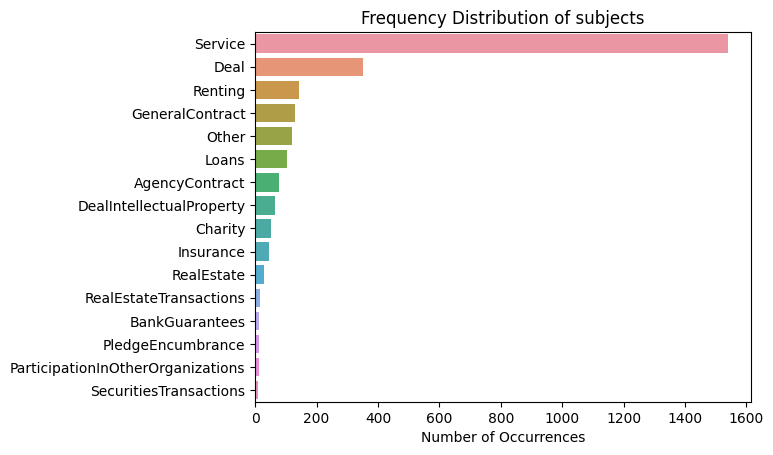


min 8
max 1539
total 2711


In [27]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [28]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['BankGuarantees', 'Loans', 'Service', 'AgencyContract', 'Charity', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.496310
Deal                                 0.620933
Renting                              0.735031
GeneralContract                      0.748364
Other                                0.760876
Loans                                0.781116
AgencyContract                       0.836110
DealIntellectualProperty             0.872628
Charity                              0.926462
Insurance                            0.951430
RealEstate                           1.060774
RealEstateTransactions               1.285708
BankGuarantees                       1.380298
PledgeEncumbrance                    1.420178
ParticipationInOtherOrganizations    1.465925
SecuritiesTransactions               1.657858
Name: subject, dtype: float64

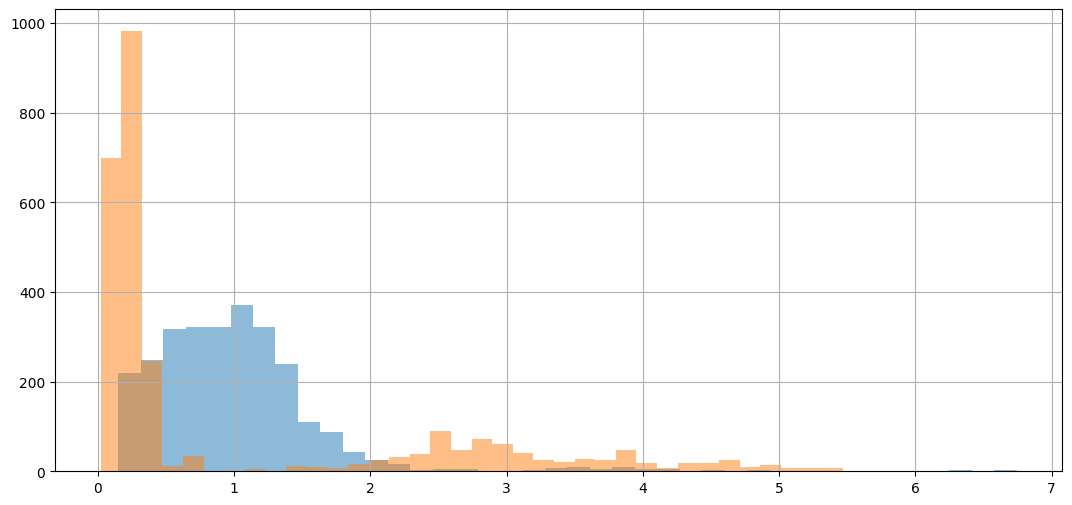

In [29]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

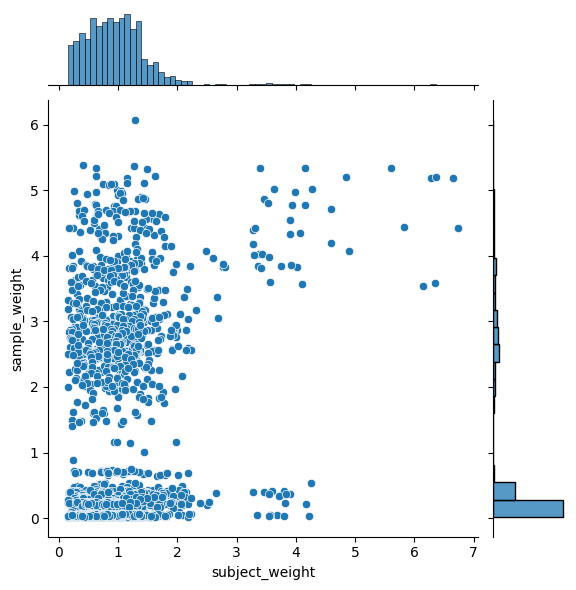

In [30]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


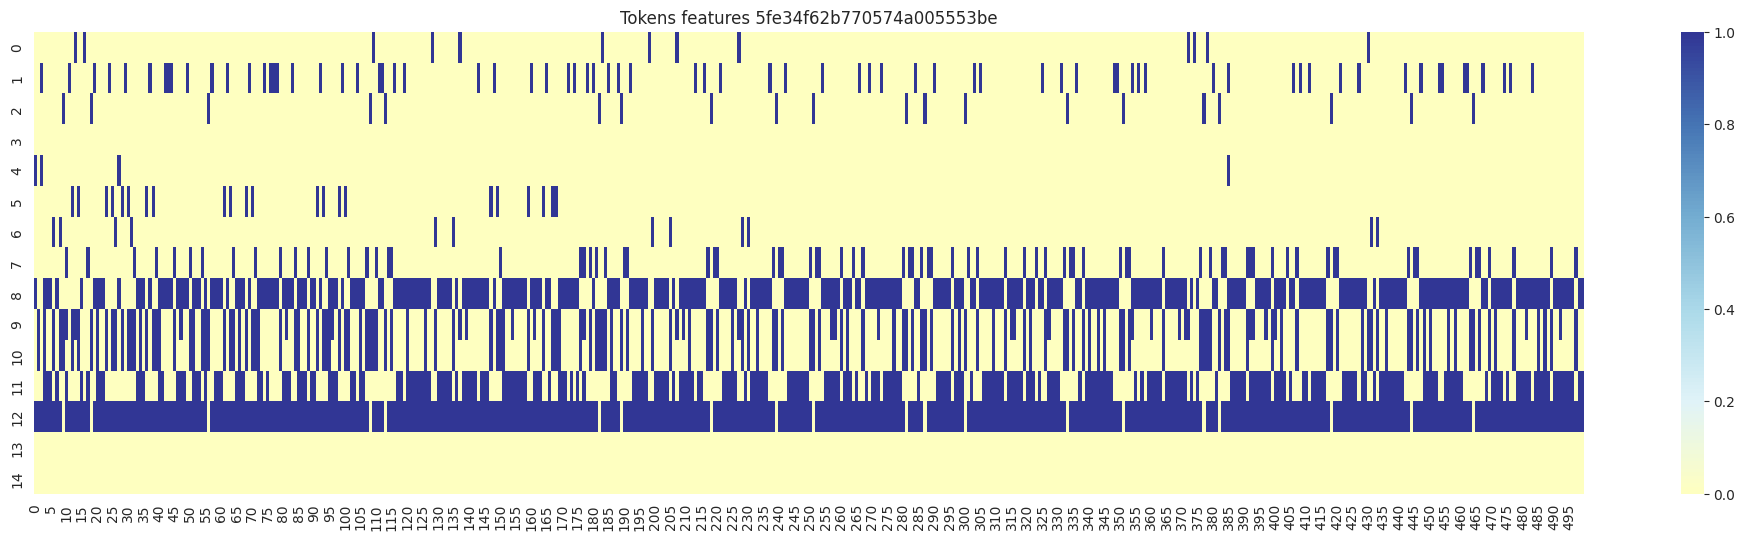

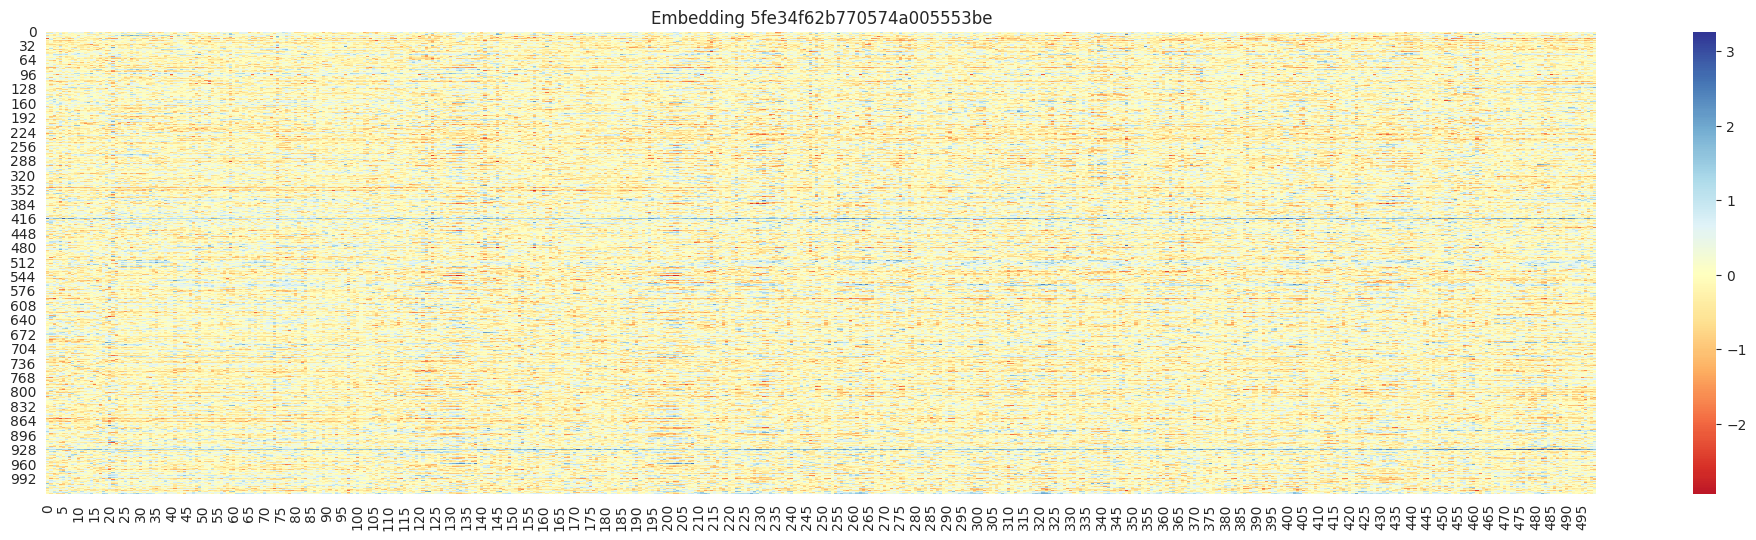

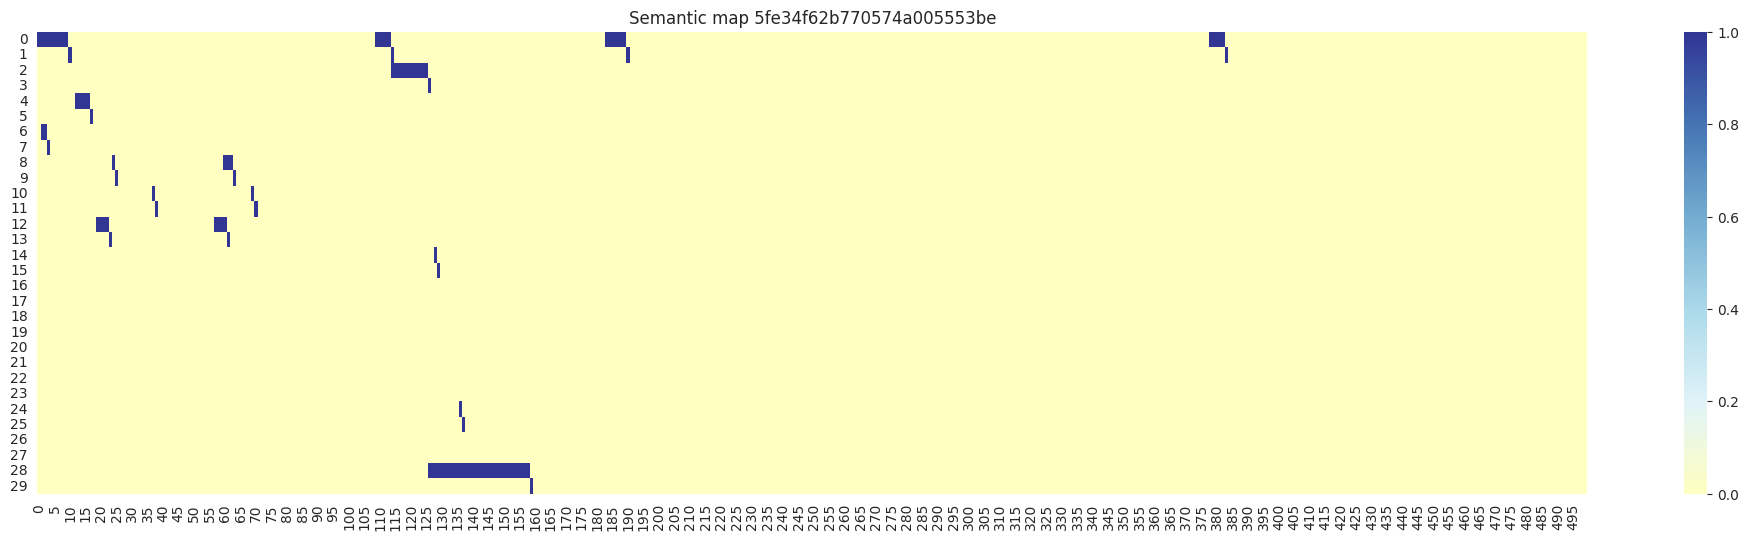

In [31]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 948, 30)


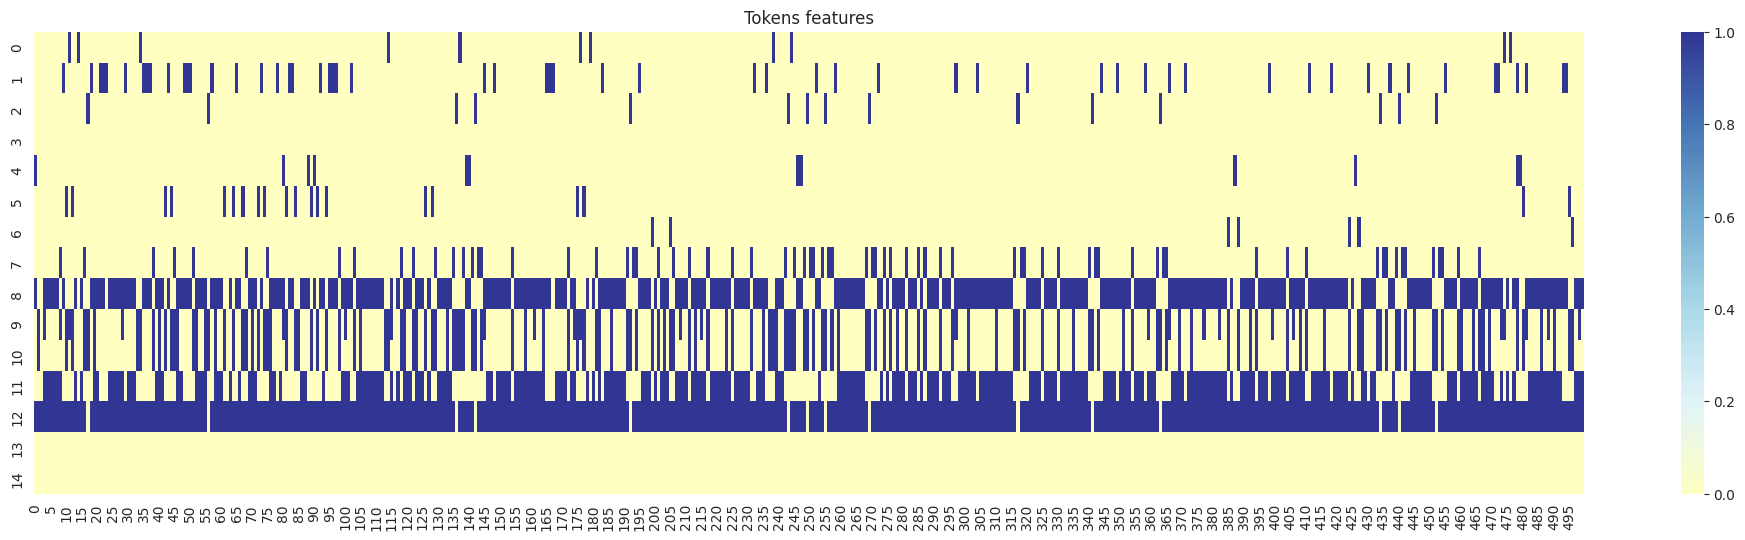

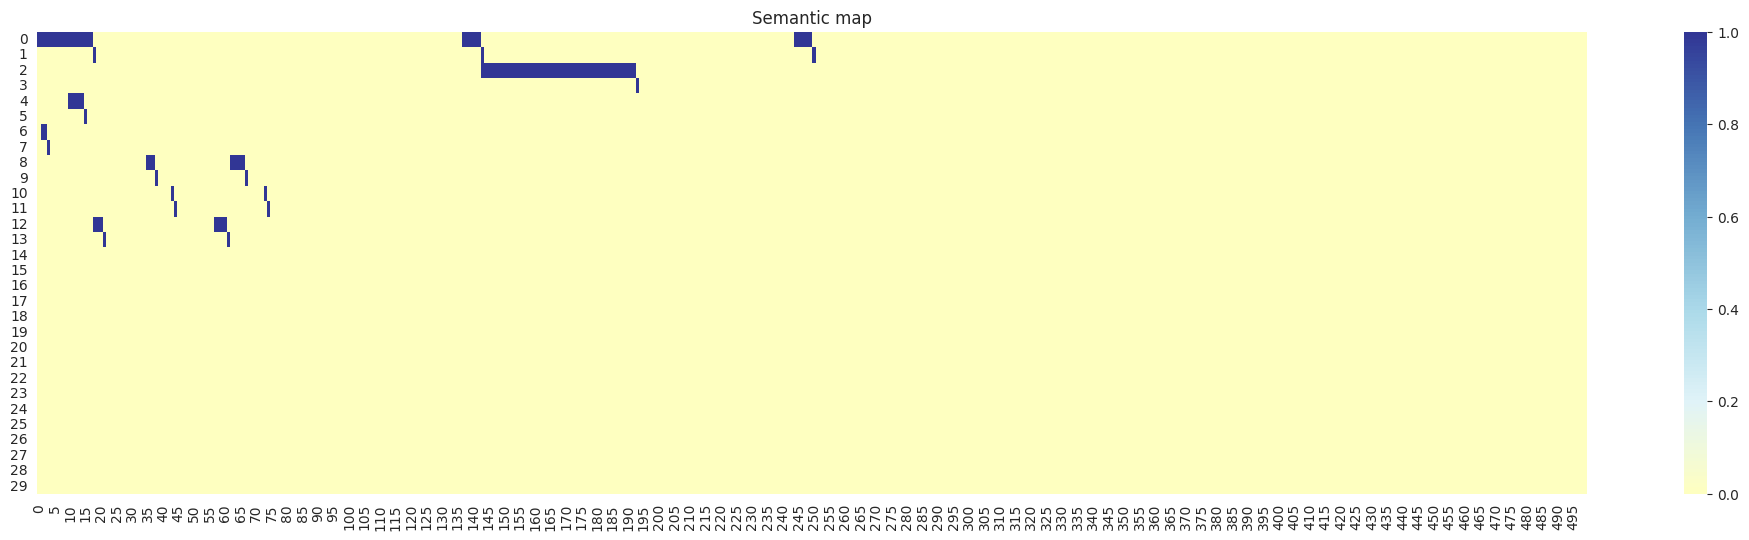

In [32]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [33]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

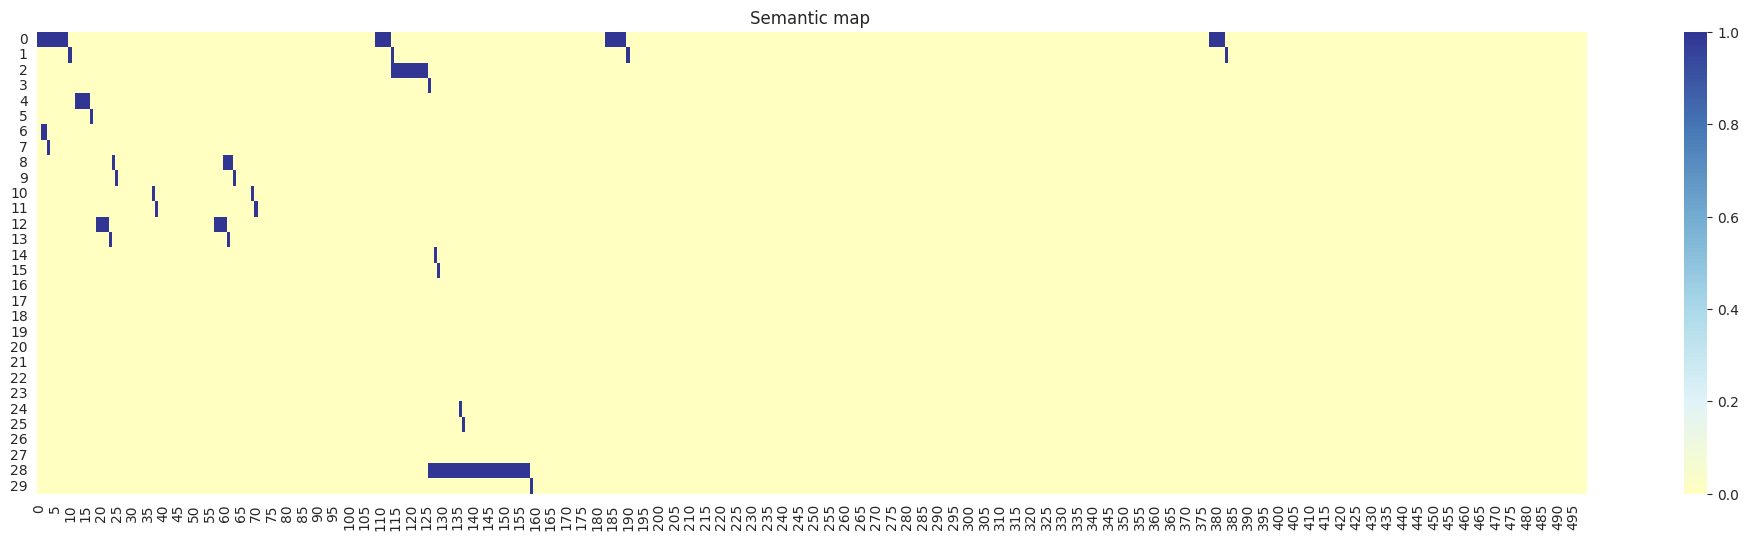

In [34]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5edbadccda3678279fbcaa27
test_indices[0]: 5fb674fd33c72547b754ffe3


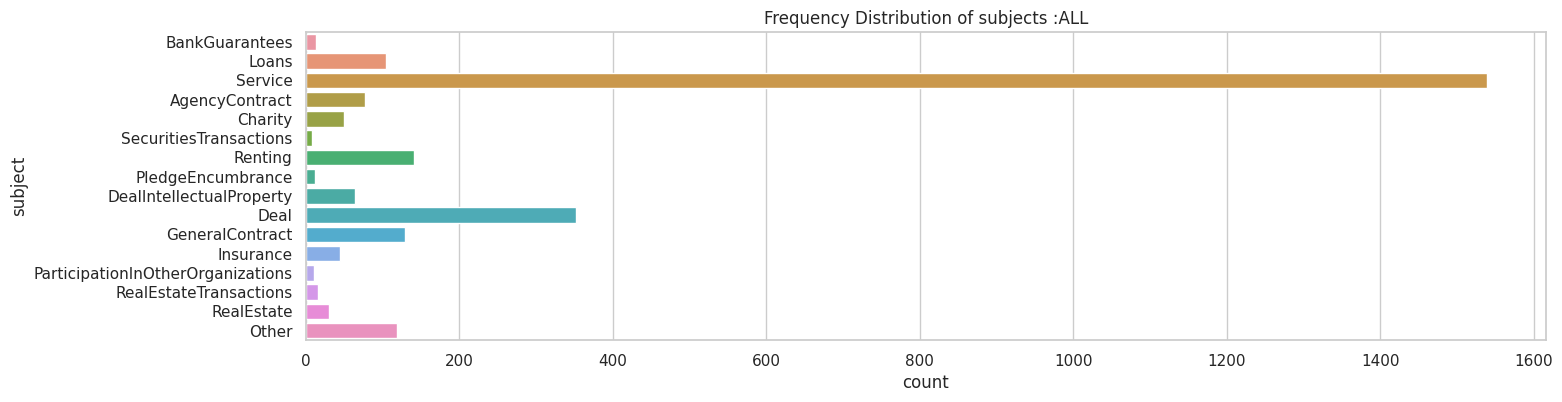

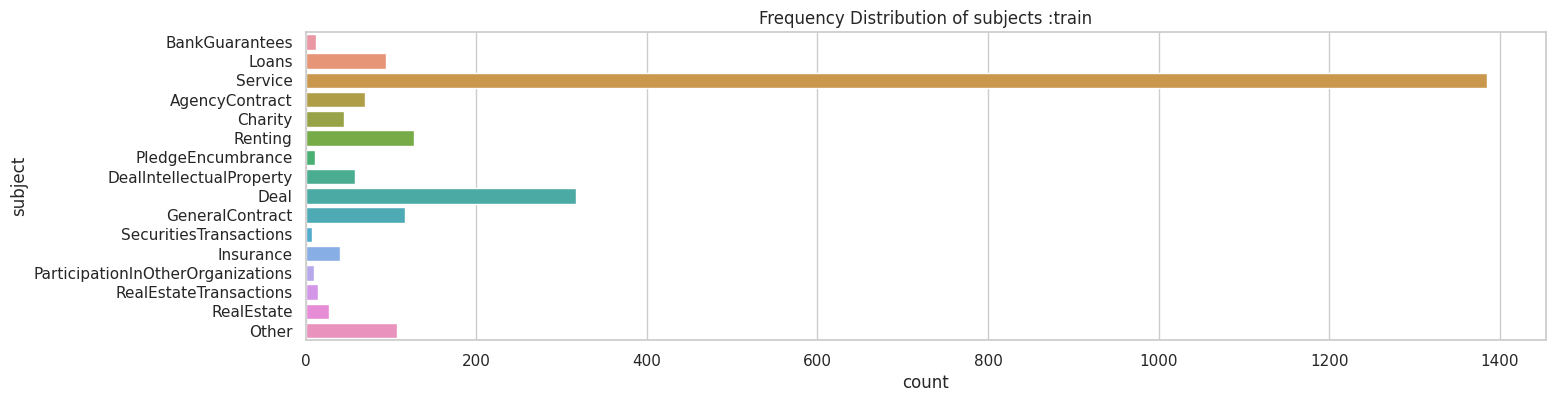

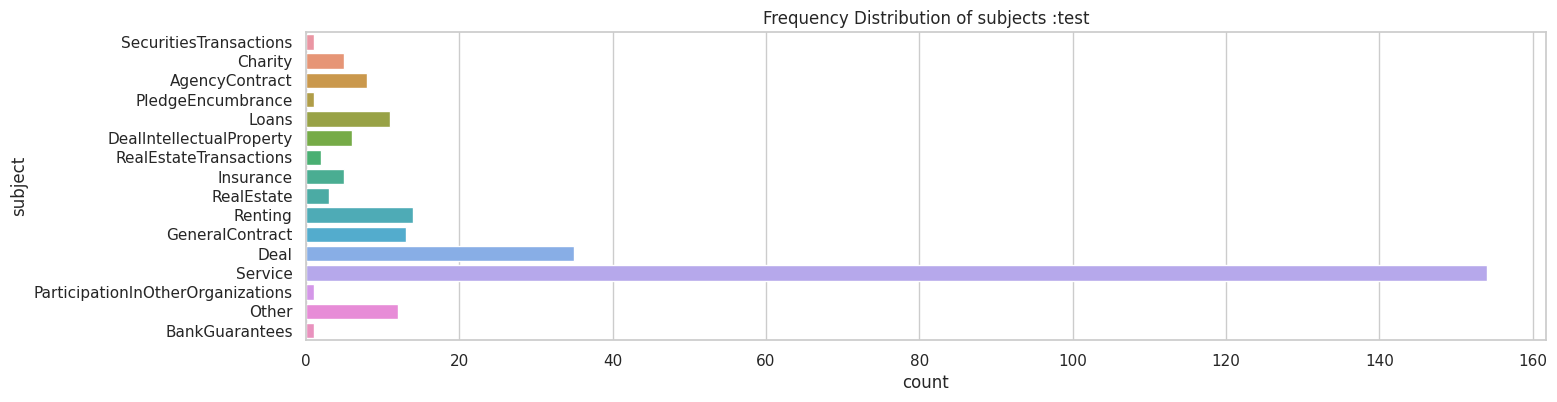

In [35]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9756
test_samples:	272
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [38]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [39]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [40]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [41]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [42]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [43]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-04 01:05:27.110035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-04 01:05:27.629486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 01:05:27.630148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-04 01:05:27.630163: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 01:05:27.630196: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-04 01:05:27.630211: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [44]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [45]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [46]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from functools import lru_cache
from pathlib import Path

import numpy as np
from pandas import DataFrame
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, LSTM, Bidirectional, Dense, MaxPooling1D, ReLU
from tensorflow.keras.layers import concatenate

from analyser.headers_detector import TOKEN_FEATURES
from analyser.hyperparams import work_dir

from analyser.structures import ContractSubject
from tf_support.addons import sigmoid_focal_crossentropy
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.01

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}


def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")

  # _out = layers.Dropout(0.3, name="drops")(input_text_emb)  # small_drops_of_poison
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
  _out1 = ReLU(name='O1_tagging')(_out)

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(_out1)
  _out = Dropout(0.15)(_out)

  _out2 = Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


 

    
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__
umodel = make_att_model()

# umodel.load_weights(weights, by_name=True, skip_mismatch=True)
# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [48]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-04 01:05:31.235227: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 01:05:31.257911: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-04 01:05:33.888485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-04 01:05:35.018206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-04 01:05:35.018249: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-04 01:05:35.082240: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-04 01:05:35.298091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 7:57 - loss: 0.5468 - O1_tagging_loss: 0.1668 - O2_subject_loss: 0.3799 - O1_tagging_mse: 0.0516 - O1_tagging_binary_crossentropy: 0.2004 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6954

  2/101 [..............................] - ETA: 43s - loss: 0.5664 - O1_tagging_loss: 0.1627 - O2_subject_loss: 0.4037 - O1_tagging_mse: 0.0470 - O1_tagging_binary_crossentropy: 0.1772 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6754 

  3/101 [..............................] - ETA: 54s - loss: 0.5525 - O1_tagging_loss: 0.1473 - O2_subject_loss: 0.4052 - O1_tagging_mse: 0.0432 - O1_tagging_binary_crossentropy: 0.1665 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6625

  4/101 [>.............................] - ETA: 1:06 - loss: 0.6008 - O1_tagging_loss: 0.1864 - O2_subject_loss: 0.4144 - O1_tagging_mse: 0.0476 - O1_tagging_binary_crossentropy: 0.1860 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6423

  5/101 [>.............................] - ETA: 58s - loss: 0.5899 - O1_tagging_loss: 0.1833 - O2_subject_loss: 0.4066 - O1_tagging_mse: 0.0457 - O1_tagging_binary_crossentropy: 0.1827 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6229 

  6/101 [>.............................] - ETA: 1:05 - loss: 0.5642 - O1_tagging_loss: 0.1687 - O2_subject_loss: 0.3955 - O1_tagging_mse: 0.0408 - O1_tagging_binary_crossentropy: 0.1683 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5978

  7/101 [=>............................] - ETA: 1:04 - loss: 0.5361 - O1_tagging_loss: 0.1581 - O2_subject_loss: 0.3781 - O1_tagging_mse: 0.0376 - O1_tagging_binary_crossentropy: 0.1592 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5680

  8/101 [=>............................] - ETA: 1:15 - loss: 0.5078 - O1_tagging_loss: 0.1479 - O2_subject_loss: 0.3599 - O1_tagging_mse: 0.0331 - O1_tagging_binary_crossentropy: 0.1448 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5355

  9/101 [=>............................] - ETA: 1:26 - loss: 0.4771 - O1_tagging_loss: 0.1390 - O2_subject_loss: 0.3380 - O1_tagging_mse: 0.0298 - O1_tagging_binary_crossentropy: 0.1332 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5038

 10/101 [=>............................] - ETA: 1:34 - loss: 0.4482 - O1_tagging_loss: 0.1326 - O2_subject_loss: 0.3156 - O1_tagging_mse: 0.0275 - O1_tagging_binary_crossentropy: 0.1253 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4736

 11/101 [==>...........................] - ETA: 1:36 - loss: 0.4252 - O1_tagging_loss: 0.1271 - O2_subject_loss: 0.2981 - O1_tagging_mse: 0.0259 - O1_tagging_binary_crossentropy: 0.1199 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4453

 12/101 [==>...........................] - ETA: 1:33 - loss: 0.4005 - O1_tagging_loss: 0.1216 - O2_subject_loss: 0.2789 - O1_tagging_mse: 0.0250 - O1_tagging_binary_crossentropy: 0.1170 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.4192

 13/101 [==>...........................] - ETA: 1:31 - loss: 0.3818 - O1_tagging_loss: 0.1187 - O2_subject_loss: 0.2631 - O1_tagging_mse: 0.0241 - O1_tagging_binary_crossentropy: 0.1142 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3958

 14/101 [===>..........................] - ETA: 1:30 - loss: 0.3659 - O1_tagging_loss: 0.1163 - O2_subject_loss: 0.2496 - O1_tagging_mse: 0.0228 - O1_tagging_binary_crossentropy: 0.1100 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3747

 15/101 [===>..........................] - ETA: 1:28 - loss: 0.3496 - O1_tagging_loss: 0.1128 - O2_subject_loss: 0.2368 - O1_tagging_mse: 0.0220 - O1_tagging_binary_crossentropy: 0.1076 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 0.3558

 16/101 [===>..........................] - ETA: 1:25 - loss: 0.3366 - O1_tagging_loss: 0.1107 - O2_subject_loss: 0.2259 - O1_tagging_mse: 0.0216 - O1_tagging_binary_crossentropy: 0.1063 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 0.3388

 17/101 [====>.........................] - ETA: 1:27 - loss: 0.3236 - O1_tagging_loss: 0.1074 - O2_subject_loss: 0.2161 - O1_tagging_mse: 0.0203 - O1_tagging_binary_crossentropy: 0.1018 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 0.3235

 18/101 [====>.........................] - ETA: 1:26 - loss: 0.3102 - O1_tagging_loss: 0.1035 - O2_subject_loss: 0.2067 - O1_tagging_mse: 0.0193 - O1_tagging_binary_crossentropy: 0.0983 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 0.3096

 19/101 [====>.........................] - ETA: 1:24 - loss: 0.3010 - O1_tagging_loss: 0.1018 - O2_subject_loss: 0.1992 - O1_tagging_mse: 0.0188 - O1_tagging_binary_crossentropy: 0.0965 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 0.2970

 20/101 [====>.........................] - ETA: 1:22 - loss: 0.2921 - O1_tagging_loss: 0.1003 - O2_subject_loss: 0.1918 - O1_tagging_mse: 0.0185 - O1_tagging_binary_crossentropy: 0.0958 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.2854

 21/101 [=====>........................] - ETA: 1:25 - loss: 0.2823 - O1_tagging_loss: 0.0973 - O2_subject_loss: 0.1850 - O1_tagging_mse: 0.0175 - O1_tagging_binary_crossentropy: 0.0914 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.2750

 22/101 [=====>........................] - ETA: 1:22 - loss: 0.2739 - O1_tagging_loss: 0.0957 - O2_subject_loss: 0.1782 - O1_tagging_mse: 0.0173 - O1_tagging_binary_crossentropy: 0.0908 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.2656

 23/101 [=====>........................] - ETA: 1:23 - loss: 0.2660 - O1_tagging_loss: 0.0936 - O2_subject_loss: 0.1724 - O1_tagging_mse: 0.0166 - O1_tagging_binary_crossentropy: 0.0887 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.2569

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.2596 - O1_tagging_loss: 0.0918 - O2_subject_loss: 0.1677 - O1_tagging_mse: 0.0162 - O1_tagging_binary_crossentropy: 0.0869 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.2490

 25/101 [======>.......................] - ETA: 1:21 - loss: 0.2527 - O1_tagging_loss: 0.0896 - O2_subject_loss: 0.1631 - O1_tagging_mse: 0.0158 - O1_tagging_binary_crossentropy: 0.0852 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.2420

 26/101 [======>.......................] - ETA: 1:20 - loss: 0.2476 - O1_tagging_loss: 0.0886 - O2_subject_loss: 0.1590 - O1_tagging_mse: 0.0154 - O1_tagging_binary_crossentropy: 0.0837 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.2352

 27/101 [=======>......................] - ETA: 1:20 - loss: 0.2423 - O1_tagging_loss: 0.0879 - O2_subject_loss: 0.1544 - O1_tagging_mse: 0.0153 - O1_tagging_binary_crossentropy: 0.0833 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.2285

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.2373 - O1_tagging_loss: 0.0863 - O2_subject_loss: 0.1510 - O1_tagging_mse: 0.0147 - O1_tagging_binary_crossentropy: 0.0810 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.2229

 29/101 [=======>......................] - ETA: 1:18 - loss: 0.2323 - O1_tagging_loss: 0.0849 - O2_subject_loss: 0.1474 - O1_tagging_mse: 0.0144 - O1_tagging_binary_crossentropy: 0.0798 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.2172

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.2273 - O1_tagging_loss: 0.0834 - O2_subject_loss: 0.1439 - O1_tagging_mse: 0.0140 - O1_tagging_binary_crossentropy: 0.0781 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.2121

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.2225 - O1_tagging_loss: 0.0823 - O2_subject_loss: 0.1401 - O1_tagging_mse: 0.0138 - O1_tagging_binary_crossentropy: 0.0772 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.2072

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.2189 - O1_tagging_loss: 0.0811 - O2_subject_loss: 0.1378 - O1_tagging_mse: 0.0134 - O1_tagging_binary_crossentropy: 0.0755 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.2029

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.2155 - O1_tagging_loss: 0.0802 - O2_subject_loss: 0.1353 - O1_tagging_mse: 0.0133 - O1_tagging_binary_crossentropy: 0.0748 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.1987

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.2115 - O1_tagging_loss: 0.0789 - O2_subject_loss: 0.1327 - O1_tagging_mse: 0.0129 - O1_tagging_binary_crossentropy: 0.0733 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1945

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.2080 - O1_tagging_loss: 0.0778 - O2_subject_loss: 0.1302 - O1_tagging_mse: 0.0126 - O1_tagging_binary_crossentropy: 0.0718 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1908

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.2051 - O1_tagging_loss: 0.0770 - O2_subject_loss: 0.1281 - O1_tagging_mse: 0.0122 - O1_tagging_binary_crossentropy: 0.0702 - O2_subject_mse: 0.0185 - O2_subject_binary_crossentropy: 0.1873

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.2028 - O1_tagging_loss: 0.0768 - O2_subject_loss: 0.1259 - O1_tagging_mse: 0.0122 - O1_tagging_binary_crossentropy: 0.0701 - O2_subject_mse: 0.0185 - O2_subject_binary_crossentropy: 0.1840

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.2000 - O1_tagging_loss: 0.0766 - O2_subject_loss: 0.1234 - O1_tagging_mse: 0.0121 - O1_tagging_binary_crossentropy: 0.0700 - O2_subject_mse: 0.0184 - O2_subject_binary_crossentropy: 0.1807

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.1969 - O1_tagging_loss: 0.0755 - O2_subject_loss: 0.1213 - O1_tagging_mse: 0.0119 - O1_tagging_binary_crossentropy: 0.0689 - O2_subject_mse: 0.0183 - O2_subject_binary_crossentropy: 0.1775

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.1940 - O1_tagging_loss: 0.0744 - O2_subject_loss: 0.1195 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0677 - O2_subject_mse: 0.0183 - O2_subject_binary_crossentropy: 0.1747

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.1922 - O1_tagging_loss: 0.0744 - O2_subject_loss: 0.1179 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0676 - O2_subject_mse: 0.0182 - O2_subject_binary_crossentropy: 0.1720

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.1899 - O1_tagging_loss: 0.0740 - O2_subject_loss: 0.1159 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0674 - O2_subject_mse: 0.0182 - O2_subject_binary_crossentropy: 0.1693

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.1871 - O1_tagging_loss: 0.0730 - O2_subject_loss: 0.1141 - O1_tagging_mse: 0.0113 - O1_tagging_binary_crossentropy: 0.0664 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1666

 44/101 [============>.................] - ETA: 1:05 - loss: 0.1848 - O1_tagging_loss: 0.0726 - O2_subject_loss: 0.1122 - O1_tagging_mse: 0.0113 - O1_tagging_binary_crossentropy: 0.0663 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.1640

 45/101 [============>.................] - ETA: 1:04 - loss: 0.1826 - O1_tagging_loss: 0.0718 - O2_subject_loss: 0.1107 - O1_tagging_mse: 0.0112 - O1_tagging_binary_crossentropy: 0.0655 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.1619

 46/101 [============>.................] - ETA: 1:03 - loss: 0.1803 - O1_tagging_loss: 0.0712 - O2_subject_loss: 0.1091 - O1_tagging_mse: 0.0110 - O1_tagging_binary_crossentropy: 0.0648 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.1595

 47/101 [============>.................] - ETA: 1:02 - loss: 0.1785 - O1_tagging_loss: 0.0708 - O2_subject_loss: 0.1077 - O1_tagging_mse: 0.0110 - O1_tagging_binary_crossentropy: 0.0646 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.1573

 48/101 [=============>................] - ETA: 1:01 - loss: 0.1761 - O1_tagging_loss: 0.0699 - O2_subject_loss: 0.1062 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0637 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.1551

 49/101 [=============>................] - ETA: 1:01 - loss: 0.1738 - O1_tagging_loss: 0.0689 - O2_subject_loss: 0.1048 - O1_tagging_mse: 0.0106 - O1_tagging_binary_crossentropy: 0.0627 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.1531

 50/101 [=============>................] - ETA: 1:00 - loss: 0.1717 - O1_tagging_loss: 0.0681 - O2_subject_loss: 0.1036 - O1_tagging_mse: 0.0104 - O1_tagging_binary_crossentropy: 0.0619 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.1511

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.1697 - O1_tagging_loss: 0.0673 - O2_subject_loss: 0.1024 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0609 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.1493

 52/101 [==============>...............] - ETA: 59s - loss: 0.1680 - O1_tagging_loss: 0.0668 - O2_subject_loss: 0.1013 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0603 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.1476 

 53/101 [==============>...............] - ETA: 58s - loss: 0.1661 - O1_tagging_loss: 0.0662 - O2_subject_loss: 0.0999 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0601 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.1458

 54/101 [===============>..............] - ETA: 56s - loss: 0.1658 - O1_tagging_loss: 0.0667 - O2_subject_loss: 0.0991 - O1_tagging_mse: 0.0100 - O1_tagging_binary_crossentropy: 0.0601 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.1443

 55/101 [===============>..............] - ETA: 55s - loss: 0.1648 - O1_tagging_loss: 0.0664 - O2_subject_loss: 0.0984 - O1_tagging_mse: 0.0100 - O1_tagging_binary_crossentropy: 0.0600 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.1428

 56/101 [===============>..............] - ETA: 54s - loss: 0.1629 - O1_tagging_loss: 0.0655 - O2_subject_loss: 0.0973 - O1_tagging_mse: 0.0099 - O1_tagging_binary_crossentropy: 0.0591 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.1413

 57/101 [===============>..............] - ETA: 52s - loss: 0.1614 - O1_tagging_loss: 0.0651 - O2_subject_loss: 0.0963 - O1_tagging_mse: 0.0098 - O1_tagging_binary_crossentropy: 0.0590 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.1399

 58/101 [================>.............] - ETA: 52s - loss: 0.1602 - O1_tagging_loss: 0.0645 - O2_subject_loss: 0.0957 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0583 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.1386

 59/101 [================>.............] - ETA: 50s - loss: 0.1599 - O1_tagging_loss: 0.0645 - O2_subject_loss: 0.0954 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0582 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.1374

 60/101 [================>.............] - ETA: 49s - loss: 0.1593 - O1_tagging_loss: 0.0644 - O2_subject_loss: 0.0949 - O1_tagging_mse: 0.0096 - O1_tagging_binary_crossentropy: 0.0581 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.1361

 61/101 [=================>............] - ETA: 48s - loss: 0.1579 - O1_tagging_loss: 0.0639 - O2_subject_loss: 0.0940 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0576 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.1349

 62/101 [=================>............] - ETA: 46s - loss: 0.1565 - O1_tagging_loss: 0.0634 - O2_subject_loss: 0.0932 - O1_tagging_mse: 0.0094 - O1_tagging_binary_crossentropy: 0.0570 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1337

 63/101 [=================>............] - ETA: 45s - loss: 0.1552 - O1_tagging_loss: 0.0629 - O2_subject_loss: 0.0923 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0565 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1325

 64/101 [==================>...........] - ETA: 44s - loss: 0.1541 - O1_tagging_loss: 0.0623 - O2_subject_loss: 0.0918 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0560 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1315

 65/101 [==================>...........] - ETA: 43s - loss: 0.1530 - O1_tagging_loss: 0.0618 - O2_subject_loss: 0.0912 - O1_tagging_mse: 0.0091 - O1_tagging_binary_crossentropy: 0.0554 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1305

 66/101 [==================>...........] - ETA: 42s - loss: 0.1518 - O1_tagging_loss: 0.0613 - O2_subject_loss: 0.0904 - O1_tagging_mse: 0.0089 - O1_tagging_binary_crossentropy: 0.0548 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1295

 67/101 [==================>...........] - ETA: 40s - loss: 0.1507 - O1_tagging_loss: 0.0610 - O2_subject_loss: 0.0897 - O1_tagging_mse: 0.0089 - O1_tagging_binary_crossentropy: 0.0547 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1286

 68/101 [===================>..........] - ETA: 39s - loss: 0.1498 - O1_tagging_loss: 0.0606 - O2_subject_loss: 0.0891 - O1_tagging_mse: 0.0089 - O1_tagging_binary_crossentropy: 0.0543 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.1276

 69/101 [===================>..........] - ETA: 38s - loss: 0.1489 - O1_tagging_loss: 0.0606 - O2_subject_loss: 0.0883 - O1_tagging_mse: 0.0088 - O1_tagging_binary_crossentropy: 0.0543 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.1266

 70/101 [===================>..........] - ETA: 37s - loss: 0.1482 - O1_tagging_loss: 0.0605 - O2_subject_loss: 0.0877 - O1_tagging_mse: 0.0088 - O1_tagging_binary_crossentropy: 0.0540 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.1256

 71/101 [====================>.........] - ETA: 36s - loss: 0.1474 - O1_tagging_loss: 0.0602 - O2_subject_loss: 0.0871 - O1_tagging_mse: 0.0088 - O1_tagging_binary_crossentropy: 0.0539 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.1247

 72/101 [====================>.........] - ETA: 35s - loss: 0.1468 - O1_tagging_loss: 0.0601 - O2_subject_loss: 0.0867 - O1_tagging_mse: 0.0087 - O1_tagging_binary_crossentropy: 0.0536 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1238

 73/101 [====================>.........] - ETA: 34s - loss: 0.1459 - O1_tagging_loss: 0.0598 - O2_subject_loss: 0.0861 - O1_tagging_mse: 0.0086 - O1_tagging_binary_crossentropy: 0.0532 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1229

 74/101 [====================>.........] - ETA: 32s - loss: 0.1453 - O1_tagging_loss: 0.0597 - O2_subject_loss: 0.0856 - O1_tagging_mse: 0.0086 - O1_tagging_binary_crossentropy: 0.0531 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1221

 75/101 [=====================>........] - ETA: 31s - loss: 0.1444 - O1_tagging_loss: 0.0593 - O2_subject_loss: 0.0851 - O1_tagging_mse: 0.0085 - O1_tagging_binary_crossentropy: 0.0528 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1213

 76/101 [=====================>........] - ETA: 30s - loss: 0.1435 - O1_tagging_loss: 0.0590 - O2_subject_loss: 0.0846 - O1_tagging_mse: 0.0085 - O1_tagging_binary_crossentropy: 0.0525 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1205

 77/101 [=====================>........] - ETA: 29s - loss: 0.1428 - O1_tagging_loss: 0.0587 - O2_subject_loss: 0.0841 - O1_tagging_mse: 0.0084 - O1_tagging_binary_crossentropy: 0.0522 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.1198

 78/101 [======================>.......] - ETA: 27s - loss: 0.1422 - O1_tagging_loss: 0.0585 - O2_subject_loss: 0.0836 - O1_tagging_mse: 0.0084 - O1_tagging_binary_crossentropy: 0.0520 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.1190

 79/101 [======================>.......] - ETA: 26s - loss: 0.1416 - O1_tagging_loss: 0.0583 - O2_subject_loss: 0.0832 - O1_tagging_mse: 0.0084 - O1_tagging_binary_crossentropy: 0.0520 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.1182

 80/101 [======================>.......] - ETA: 25s - loss: 0.1407 - O1_tagging_loss: 0.0580 - O2_subject_loss: 0.0827 - O1_tagging_mse: 0.0083 - O1_tagging_binary_crossentropy: 0.0517 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.1174

 81/101 [=======================>......] - ETA: 24s - loss: 0.1399 - O1_tagging_loss: 0.0577 - O2_subject_loss: 0.0822 - O1_tagging_mse: 0.0083 - O1_tagging_binary_crossentropy: 0.0516 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.1167

 82/101 [=======================>......] - ETA: 22s - loss: 0.1392 - O1_tagging_loss: 0.0574 - O2_subject_loss: 0.0817 - O1_tagging_mse: 0.0083 - O1_tagging_binary_crossentropy: 0.0515 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.1160

 83/101 [=======================>......] - ETA: 21s - loss: 0.1385 - O1_tagging_loss: 0.0572 - O2_subject_loss: 0.0813 - O1_tagging_mse: 0.0082 - O1_tagging_binary_crossentropy: 0.0512 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.1154

 84/101 [=======================>......] - ETA: 20s - loss: 0.1383 - O1_tagging_loss: 0.0574 - O2_subject_loss: 0.0809 - O1_tagging_mse: 0.0082 - O1_tagging_binary_crossentropy: 0.0513 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.1147

 85/101 [========================>.....] - ETA: 19s - loss: 0.1374 - O1_tagging_loss: 0.0570 - O2_subject_loss: 0.0804 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0509 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.1140

 86/101 [========================>.....] - ETA: 18s - loss: 0.1369 - O1_tagging_loss: 0.0570 - O2_subject_loss: 0.0799 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0509 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1134

 87/101 [========================>.....] - ETA: 16s - loss: 0.1363 - O1_tagging_loss: 0.0568 - O2_subject_loss: 0.0796 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0507 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1128

 88/101 [=========================>....] - ETA: 15s - loss: 0.1358 - O1_tagging_loss: 0.0565 - O2_subject_loss: 0.0793 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0505 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1122

 89/101 [=========================>....] - ETA: 14s - loss: 0.1349 - O1_tagging_loss: 0.0561 - O2_subject_loss: 0.0788 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0502 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1117

 90/101 [=========================>....] - ETA: 13s - loss: 0.1343 - O1_tagging_loss: 0.0558 - O2_subject_loss: 0.0785 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0500 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1112

 91/101 [==========================>...] - ETA: 12s - loss: 0.1338 - O1_tagging_loss: 0.0557 - O2_subject_loss: 0.0781 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0500 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1106

 92/101 [==========================>...] - ETA: 10s - loss: 0.1333 - O1_tagging_loss: 0.0555 - O2_subject_loss: 0.0778 - O1_tagging_mse: 0.0079 - O1_tagging_binary_crossentropy: 0.0497 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1101

 93/101 [==========================>...] - ETA: 9s - loss: 0.1331 - O1_tagging_loss: 0.0557 - O2_subject_loss: 0.0774 - O1_tagging_mse: 0.0079 - O1_tagging_binary_crossentropy: 0.0497 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1096 

 94/101 [==========================>...] - ETA: 8s - loss: 0.1327 - O1_tagging_loss: 0.0555 - O2_subject_loss: 0.0772 - O1_tagging_mse: 0.0079 - O1_tagging_binary_crossentropy: 0.0495 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1091

 95/101 [===========================>..] - ETA: 7s - loss: 0.1322 - O1_tagging_loss: 0.0552 - O2_subject_loss: 0.0770 - O1_tagging_mse: 0.0078 - O1_tagging_binary_crossentropy: 0.0492 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1086

 96/101 [===========================>..] - ETA: 6s - loss: 0.1316 - O1_tagging_loss: 0.0549 - O2_subject_loss: 0.0766 - O1_tagging_mse: 0.0077 - O1_tagging_binary_crossentropy: 0.0489 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.1082

 97/101 [===========================>..] - ETA: 4s - loss: 0.1309 - O1_tagging_loss: 0.0546 - O2_subject_loss: 0.0762 - O1_tagging_mse: 0.0077 - O1_tagging_binary_crossentropy: 0.0486 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.1076

 98/101 [============================>.] - ETA: 3s - loss: 0.1301 - O1_tagging_loss: 0.0543 - O2_subject_loss: 0.0758 - O1_tagging_mse: 0.0077 - O1_tagging_binary_crossentropy: 0.0485 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.1072

 99/101 [============================>.] - ETA: 2s - loss: 0.1298 - O1_tagging_loss: 0.0541 - O2_subject_loss: 0.0757 - O1_tagging_mse: 0.0077 - O1_tagging_binary_crossentropy: 0.0484 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.1067

100/101 [============================>.] - ETA: 1s - loss: 0.1291 - O1_tagging_loss: 0.0538 - O2_subject_loss: 0.0753 - O1_tagging_mse: 0.0076 - O1_tagging_binary_crossentropy: 0.0481 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.1061

101/101 [==============================] - ETA: 0s - loss: 0.1284 - O1_tagging_loss: 0.0535 - O2_subject_loss: 0.0749 - O1_tagging_mse: 0.0075 - O1_tagging_binary_crossentropy: 0.0477 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.1056

101/101 [==============================] - 214s 2s/step - loss: 0.1284 - O1_tagging_loss: 0.0535 - O2_subject_loss: 0.0749 - O1_tagging_mse: 0.0075 - O1_tagging_binary_crossentropy: 0.0477 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.1056 - val_loss: 0.2529 - val_O1_tagging_loss: 0.1833 - val_O2_subject_loss: 0.0696 - val_O1_tagging_mse: 0.0363 - val_O1_tagging_binary_crossentropy: 0.1801 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0583



Epoch 00001: val_loss improved from inf to 0.25295, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 14s - loss: 0.0986 - O1_tagging_loss: 0.0437 - O2_subject_loss: 0.0549 - O1_tagging_mse: 0.0061 - O1_tagging_binary_crossentropy: 0.0384 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0588

  2/101 [..............................] - ETA: 2:50 - loss: 0.0890 - O1_tagging_loss: 0.0398 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0306 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0592

  3/101 [..............................] - ETA: 2:30 - loss: 0.0785 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0299 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0575

  4/101 [>.............................] - ETA: 2:19 - loss: 0.0870 - O1_tagging_loss: 0.0395 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0877 - O1_tagging_loss: 0.0384 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

  6/101 [>.............................] - ETA: 2:19 - loss: 0.0829 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

  7/101 [=>............................] - ETA: 2:12 - loss: 0.0812 - O1_tagging_loss: 0.0337 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0306 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0799 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  9/101 [=>............................] - ETA: 2:02 - loss: 0.0876 - O1_tagging_loss: 0.0375 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0887 - O1_tagging_loss: 0.0380 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0611

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0881 - O1_tagging_loss: 0.0384 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0321 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0871 - O1_tagging_loss: 0.0378 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0612

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0863 - O1_tagging_loss: 0.0372 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0611

 14/101 [===>..........................] - ETA: 1:59 - loss: 0.0867 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0616

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0866 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0317 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0620

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0869 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0505 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0622

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0862 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0623

 18/101 [====>.........................] - ETA: 1:52 - loss: 0.0866 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0624

 19/101 [====>.........................] - ETA: 1:50 - loss: 0.0860 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0624

 20/101 [====>.........................] - ETA: 1:53 - loss: 0.0856 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0622

 21/101 [=====>........................] - ETA: 1:51 - loss: 0.0850 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0620

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0855 - O1_tagging_loss: 0.0369 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0619

 23/101 [=====>........................] - ETA: 1:48 - loss: 0.0855 - O1_tagging_loss: 0.0369 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0619

 24/101 [======>.......................] - ETA: 1:47 - loss: 0.0854 - O1_tagging_loss: 0.0368 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0619

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0850 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0620

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0845 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0620

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0846 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0620

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0848 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0619

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0844 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0618

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0837 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0842 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0839 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 33/101 [========>.....................] - ETA: 1:32 - loss: 0.0838 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0839 - O1_tagging_loss: 0.0368 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0833 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0827 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0831 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0833 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0830 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0829 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0828 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0831 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0830 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0832 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0833 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0831 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0828 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0821 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0822 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0819 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0817 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0820 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0820 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0817 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0821 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0820 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 57/101 [===============>..............] - ETA: 59s - loss: 0.0824 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608 

 58/101 [================>.............] - ETA: 58s - loss: 0.0825 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 59/101 [================>.............] - ETA: 57s - loss: 0.0826 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 60/101 [================>.............] - ETA: 56s - loss: 0.0824 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 61/101 [=================>............] - ETA: 54s - loss: 0.0827 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 62/101 [=================>............] - ETA: 53s - loss: 0.0831 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 63/101 [=================>............] - ETA: 52s - loss: 0.0830 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0610

 64/101 [==================>...........] - ETA: 50s - loss: 0.0831 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

 65/101 [==================>...........] - ETA: 49s - loss: 0.0832 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

 66/101 [==================>...........] - ETA: 48s - loss: 0.0831 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 67/101 [==================>...........] - ETA: 46s - loss: 0.0831 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

 68/101 [===================>..........] - ETA: 45s - loss: 0.0832 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 69/101 [===================>..........] - ETA: 44s - loss: 0.0830 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0305 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 70/101 [===================>..........] - ETA: 42s - loss: 0.0831 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0304 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 71/101 [====================>.........] - ETA: 41s - loss: 0.0832 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 72/101 [====================>.........] - ETA: 40s - loss: 0.0830 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 73/101 [====================>.........] - ETA: 38s - loss: 0.0831 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 74/101 [====================>.........] - ETA: 37s - loss: 0.0829 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 75/101 [=====================>........] - ETA: 36s - loss: 0.0828 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 76/101 [=====================>........] - ETA: 34s - loss: 0.0830 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 77/101 [=====================>........] - ETA: 33s - loss: 0.0829 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 78/101 [======================>.......] - ETA: 31s - loss: 0.0830 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 79/101 [======================>.......] - ETA: 30s - loss: 0.0830 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 80/101 [======================>.......] - ETA: 28s - loss: 0.0833 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 81/101 [=======================>......] - ETA: 27s - loss: 0.0833 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

 82/101 [=======================>......] - ETA: 25s - loss: 0.0834 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 83/101 [=======================>......] - ETA: 24s - loss: 0.0833 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 84/101 [=======================>......] - ETA: 23s - loss: 0.0832 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 85/101 [========================>.....] - ETA: 21s - loss: 0.0834 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 86/101 [========================>.....] - ETA: 20s - loss: 0.0832 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

 87/101 [========================>.....] - ETA: 19s - loss: 0.0832 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 88/101 [=========================>....] - ETA: 17s - loss: 0.0830 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 89/101 [=========================>....] - ETA: 16s - loss: 0.0829 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0299 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 90/101 [=========================>....] - ETA: 15s - loss: 0.0827 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 91/101 [==========================>...] - ETA: 13s - loss: 0.0824 - O1_tagging_loss: 0.0354 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 92/101 [==========================>...] - ETA: 12s - loss: 0.0824 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 93/101 [==========================>...] - ETA: 10s - loss: 0.0824 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 94/101 [==========================>...] - ETA: 9s - loss: 0.0824 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0823 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0297 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 96/101 [===========================>..] - ETA: 6s - loss: 0.0822 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0297 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 97/101 [===========================>..] - ETA: 5s - loss: 0.0819 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 98/101 [============================>.] - ETA: 4s - loss: 0.0821 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 99/101 [============================>.] - ETA: 2s - loss: 0.0819 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

100/101 [============================>.] - ETA: 1s - loss: 0.0817 - O1_tagging_loss: 0.0349 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

101/101 [==============================] - ETA: 0s - loss: 0.0817 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

101/101 [==============================] - 210s 2s/step - loss: 0.0817 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611 - val_loss: 0.1013 - val_O1_tagging_loss: 0.0312 - val_O2_subject_loss: 0.0700 - val_O1_tagging_mse: 0.0037 - val_O1_tagging_binary_crossentropy: 0.0308 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0585



Epoch 00002: val_loss improved from 0.25295 to 0.10126, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50


  1/101 [..............................] - ETA: 21s - loss: 0.0716 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0285 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0571

  2/101 [..............................] - ETA: 1:30 - loss: 0.0807 - O1_tagging_loss: 0.0375 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0322 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0577

  3/101 [..............................] - ETA: 1:57 - loss: 0.0776 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0280 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

  4/101 [>.............................] - ETA: 1:41 - loss: 0.0793 - O1_tagging_loss: 0.0341 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0290 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0573

  5/101 [>.............................] - ETA: 1:44 - loss: 0.0812 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0050 - O1_tagging_binary_crossentropy: 0.0293 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0579

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0794 - O1_tagging_loss: 0.0347 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0278 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0585

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0783 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0285 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0767 - O1_tagging_loss: 0.0338 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0280 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0577

  9/101 [=>............................] - ETA: 1:45 - loss: 0.0775 - O1_tagging_loss: 0.0345 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0286 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0580

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0780 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0288 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0576

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0785 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0294 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0579

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0796 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0293 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0815 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0295 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0808 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0294 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0805 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0295 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 16/101 [===>..........................] - ETA: 1:44 - loss: 0.0791 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0290 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0781 - O1_tagging_loss: 0.0348 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0286 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0786 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0789 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0292 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0790 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0292 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0781 - O1_tagging_loss: 0.0347 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0290 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0780 - O1_tagging_loss: 0.0343 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0288 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0784 - O1_tagging_loss: 0.0341 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0285 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0784 - O1_tagging_loss: 0.0338 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0283 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0781 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0280 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0782 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0280 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0778 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0277 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0777 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0279 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0770 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0277 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0767 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0278 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0772 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0279 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0767 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0582

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0770 - O1_tagging_loss: 0.0329 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0582

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0769 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0583

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0772 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0770 - O1_tagging_loss: 0.0324 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0772 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0774 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0775 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0778 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0775 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0779 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0779 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0782 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0785 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0277 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0783 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0781 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0780 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0781 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0783 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0791 - O1_tagging_loss: 0.0335 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 52/101 [==============>...............] - ETA: 59s - loss: 0.0790 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0791 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 54/101 [===============>..............] - ETA: 56s - loss: 0.0790 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 55/101 [===============>..............] - ETA: 55s - loss: 0.0788 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 56/101 [===============>..............] - ETA: 54s - loss: 0.0789 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 57/101 [===============>..............] - ETA: 53s - loss: 0.0786 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 58/101 [================>.............] - ETA: 51s - loss: 0.0785 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 59/101 [================>.............] - ETA: 50s - loss: 0.0786 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 60/101 [================>.............] - ETA: 49s - loss: 0.0786 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 61/101 [=================>............] - ETA: 48s - loss: 0.0784 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0271 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 62/101 [=================>............] - ETA: 46s - loss: 0.0786 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 63/101 [=================>............] - ETA: 45s - loss: 0.0785 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0271 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 64/101 [==================>...........] - ETA: 44s - loss: 0.0786 - O1_tagging_loss: 0.0329 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 65/101 [==================>...........] - ETA: 42s - loss: 0.0790 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 66/101 [==================>...........] - ETA: 41s - loss: 0.0792 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 67/101 [==================>...........] - ETA: 40s - loss: 0.0793 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 38s - loss: 0.0792 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 69/101 [===================>..........] - ETA: 37s - loss: 0.0793 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 70/101 [===================>..........] - ETA: 36s - loss: 0.0793 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 71/101 [====================>.........] - ETA: 35s - loss: 0.0792 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 34s - loss: 0.0795 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 33s - loss: 0.0796 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 74/101 [====================>.........] - ETA: 32s - loss: 0.0793 - O1_tagging_loss: 0.0329 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 30s - loss: 0.0794 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0274 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 76/101 [=====================>........] - ETA: 29s - loss: 0.0796 - O1_tagging_loss: 0.0332 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 77/101 [=====================>........] - ETA: 28s - loss: 0.0796 - O1_tagging_loss: 0.0331 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0275 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 78/101 [======================>.......] - ETA: 27s - loss: 0.0795 - O1_tagging_loss: 0.0329 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 79/101 [======================>.......] - ETA: 26s - loss: 0.0793 - O1_tagging_loss: 0.0328 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 80/101 [======================>.......] - ETA: 25s - loss: 0.0793 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 24s - loss: 0.0792 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0271 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 82/101 [=======================>......] - ETA: 23s - loss: 0.0790 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 83/101 [=======================>......] - ETA: 21s - loss: 0.0789 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 84/101 [=======================>......] - ETA: 20s - loss: 0.0788 - O1_tagging_loss: 0.0324 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 85/101 [========================>.....] - ETA: 19s - loss: 0.0787 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 86/101 [========================>.....] - ETA: 18s - loss: 0.0787 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 16s - loss: 0.0787 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 88/101 [=========================>....] - ETA: 15s - loss: 0.0786 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 14s - loss: 0.0789 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 90/101 [=========================>....] - ETA: 13s - loss: 0.0788 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 91/101 [==========================>...] - ETA: 12s - loss: 0.0788 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 10s - loss: 0.0787 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 9s - loss: 0.0787 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0787 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 95/101 [===========================>..] - ETA: 7s - loss: 0.0787 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 96/101 [===========================>..] - ETA: 6s - loss: 0.0786 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 4s - loss: 0.0786 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 98/101 [============================>.] - ETA: 3s - loss: 0.0787 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 2s - loss: 0.0788 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

100/101 [============================>.] - ETA: 1s - loss: 0.0789 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0789 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 198s 2s/step - loss: 0.0789 - O1_tagging_loss: 0.0321 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0269 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.1100 - val_O1_tagging_loss: 0.0370 - val_O2_subject_loss: 0.0730 - val_O1_tagging_mse: 0.0039 - val_O1_tagging_binary_crossentropy: 0.0342 - val_O2_subject_mse: 0.0155 - val_O2_subject_binary_crossentropy: 0.0605



Epoch 00003: val_loss did not improve from 0.10126
Epoch 4/50


  1/101 [..............................] - ETA: 46s - loss: 0.0726 - O1_tagging_loss: 0.0291 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

  2/101 [..............................] - ETA: 2:12 - loss: 0.0845 - O1_tagging_loss: 0.0342 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

  3/101 [..............................] - ETA: 2:14 - loss: 0.0826 - O1_tagging_loss: 0.0323 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0830 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0508 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0610

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0837 - O1_tagging_loss: 0.0314 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0797 - O1_tagging_loss: 0.0305 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

  7/101 [=>............................] - ETA: 2:04 - loss: 0.0798 - O1_tagging_loss: 0.0308 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0606

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0816 - O1_tagging_loss: 0.0318 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

  9/101 [=>............................] - ETA: 2:02 - loss: 0.0799 - O1_tagging_loss: 0.0308 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0781 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0770 - O1_tagging_loss: 0.0292 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 1:55 - loss: 0.0767 - O1_tagging_loss: 0.0287 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.0757 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.0751 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0764 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0766 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0594

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0769 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0780 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0591

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0778 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0591

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0774 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0774 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0766 - O1_tagging_loss: 0.0292 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0764 - O1_tagging_loss: 0.0291 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0756 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0761 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 26/101 [======>.......................] - ETA: 1:32 - loss: 0.0754 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0754 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0749 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0747 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0748 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0741 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0736 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0744 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0749 - O1_tagging_loss: 0.0287 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0751 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0750 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0753 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0753 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0749 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0747 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0745 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0744 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0742 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0737 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0737 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0738 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0737 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0739 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0740 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0740 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0738 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0737 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 53/101 [==============>...............] - ETA: 59s - loss: 0.0740 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0736 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 55/101 [===============>..............] - ETA: 57s - loss: 0.0736 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 56s - loss: 0.0738 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 54s - loss: 0.0739 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 58/101 [================>.............] - ETA: 53s - loss: 0.0738 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 59/101 [================>.............] - ETA: 52s - loss: 0.0739 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 50s - loss: 0.0740 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 61/101 [=================>............] - ETA: 49s - loss: 0.0741 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 62/101 [=================>............] - ETA: 48s - loss: 0.0739 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 47s - loss: 0.0739 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 64/101 [==================>...........] - ETA: 46s - loss: 0.0740 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 65/101 [==================>...........] - ETA: 45s - loss: 0.0738 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 43s - loss: 0.0739 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 67/101 [==================>...........] - ETA: 42s - loss: 0.0737 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 68/101 [===================>..........] - ETA: 40s - loss: 0.0736 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 69/101 [===================>..........] - ETA: 39s - loss: 0.0734 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 70/101 [===================>..........] - ETA: 38s - loss: 0.0734 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 71/101 [====================>.........] - ETA: 37s - loss: 0.0732 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 72/101 [====================>.........] - ETA: 36s - loss: 0.0733 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 73/101 [====================>.........] - ETA: 35s - loss: 0.0733 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 74/101 [====================>.........] - ETA: 33s - loss: 0.0737 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 75/101 [=====================>........] - ETA: 32s - loss: 0.0738 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 76/101 [=====================>........] - ETA: 30s - loss: 0.0739 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 77/101 [=====================>........] - ETA: 29s - loss: 0.0743 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 28s - loss: 0.0747 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 79/101 [======================>.......] - ETA: 27s - loss: 0.0745 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 80/101 [======================>.......] - ETA: 25s - loss: 0.0745 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 81/101 [=======================>......] - ETA: 24s - loss: 0.0744 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 23s - loss: 0.0746 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 22s - loss: 0.0745 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 84/101 [=======================>......] - ETA: 21s - loss: 0.0743 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 85/101 [========================>.....] - ETA: 19s - loss: 0.0742 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 86/101 [========================>.....] - ETA: 18s - loss: 0.0741 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 87/101 [========================>.....] - ETA: 17s - loss: 0.0742 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 88/101 [=========================>....] - ETA: 16s - loss: 0.0741 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 89/101 [=========================>....] - ETA: 14s - loss: 0.0740 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 90/101 [=========================>....] - ETA: 13s - loss: 0.0739 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 91/101 [==========================>...] - ETA: 12s - loss: 0.0739 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 92/101 [==========================>...] - ETA: 11s - loss: 0.0739 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 93/101 [==========================>...] - ETA: 9s - loss: 0.0738 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0739 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 95/101 [===========================>..] - ETA: 7s - loss: 0.0738 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 96/101 [===========================>..] - ETA: 6s - loss: 0.0738 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 97/101 [===========================>..] - ETA: 4s - loss: 0.0737 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 98/101 [============================>.] - ETA: 3s - loss: 0.0738 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 99/101 [============================>.] - ETA: 2s - loss: 0.0737 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

100/101 [============================>.] - ETA: 1s - loss: 0.0739 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - ETA: 0s - loss: 0.0739 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - 198s 2s/step - loss: 0.0739 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 - val_loss: 0.0977 - val_O1_tagging_loss: 0.0266 - val_O2_subject_loss: 0.0711 - val_O1_tagging_mse: 0.0036 - val_O1_tagging_binary_crossentropy: 0.0249 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0589



Epoch 00004: val_loss improved from 0.10126 to 0.09767, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 5/50


  1/101 [..............................] - ETA: 28s - loss: 0.0764 - O1_tagging_loss: 0.0255 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0585

  2/101 [..............................] - ETA: 2:35 - loss: 0.0814 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.0541 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0575

  3/101 [..............................] - ETA: 2:14 - loss: 0.0801 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0540 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0598

  4/101 [>.............................] - ETA: 1:52 - loss: 0.0743 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

  5/101 [>.............................] - ETA: 1:43 - loss: 0.0760 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0620

  6/101 [>.............................] - ETA: 1:42 - loss: 0.0762 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0749 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0619

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0738 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0719 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0609

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0721 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0716 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0701 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0606

 13/101 [==>...........................] - ETA: 1:47 - loss: 0.0701 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0693 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0691 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0707 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 17/101 [====>.........................] - ETA: 1:38 - loss: 0.0712 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0709 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0706 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0609

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0697 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0695 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0700 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0697 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0696 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0693 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0694 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0691 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0687 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0695 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0691 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0696 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0693 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0689 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0687 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0689 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0689 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0690 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0689 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0690 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0695 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0694 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0696 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0695 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0692 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0689 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0687 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0684 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0687 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0684 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0685 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0686 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 59s - loss: 0.0686 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0687 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 54/101 [===============>..............] - ETA: 56s - loss: 0.0685 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 55s - loss: 0.0687 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 54s - loss: 0.0686 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 52s - loss: 0.0688 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 58/101 [================>.............] - ETA: 51s - loss: 0.0690 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 59/101 [================>.............] - ETA: 50s - loss: 0.0688 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 48s - loss: 0.0691 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 61/101 [=================>............] - ETA: 47s - loss: 0.0688 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 46s - loss: 0.0691 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 63/101 [=================>............] - ETA: 45s - loss: 0.0692 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 64/101 [==================>...........] - ETA: 43s - loss: 0.0695 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 65/101 [==================>...........] - ETA: 42s - loss: 0.0693 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 66/101 [==================>...........] - ETA: 41s - loss: 0.0696 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 67/101 [==================>...........] - ETA: 40s - loss: 0.0695 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 68/101 [===================>..........] - ETA: 39s - loss: 0.0695 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 69/101 [===================>..........] - ETA: 37s - loss: 0.0696 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 70/101 [===================>..........] - ETA: 36s - loss: 0.0697 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 71/101 [====================>.........] - ETA: 35s - loss: 0.0698 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 72/101 [====================>.........] - ETA: 34s - loss: 0.0700 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 73/101 [====================>.........] - ETA: 32s - loss: 0.0701 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 74/101 [====================>.........] - ETA: 31s - loss: 0.0703 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 75/101 [=====================>........] - ETA: 30s - loss: 0.0703 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 76/101 [=====================>........] - ETA: 29s - loss: 0.0701 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 77/101 [=====================>........] - ETA: 28s - loss: 0.0701 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 78/101 [======================>.......] - ETA: 26s - loss: 0.0703 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 79/101 [======================>.......] - ETA: 25s - loss: 0.0703 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 80/101 [======================>.......] - ETA: 24s - loss: 0.0702 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 81/101 [=======================>......] - ETA: 23s - loss: 0.0701 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 82/101 [=======================>......] - ETA: 22s - loss: 0.0699 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 83/101 [=======================>......] - ETA: 21s - loss: 0.0700 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 84/101 [=======================>......] - ETA: 19s - loss: 0.0699 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 85/101 [========================>.....] - ETA: 18s - loss: 0.0698 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 86/101 [========================>.....] - ETA: 17s - loss: 0.0697 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 87/101 [========================>.....] - ETA: 16s - loss: 0.0696 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 88/101 [=========================>....] - ETA: 15s - loss: 0.0696 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 89/101 [=========================>....] - ETA: 14s - loss: 0.0696 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 90/101 [=========================>....] - ETA: 12s - loss: 0.0696 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 91/101 [==========================>...] - ETA: 11s - loss: 0.0697 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 92/101 [==========================>...] - ETA: 10s - loss: 0.0699 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 93/101 [==========================>...] - ETA: 9s - loss: 0.0701 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0698 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 95/101 [===========================>..] - ETA: 6s - loss: 0.0697 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 96/101 [===========================>..] - ETA: 5s - loss: 0.0697 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 97/101 [===========================>..] - ETA: 4s - loss: 0.0698 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 98/101 [============================>.] - ETA: 3s - loss: 0.0697 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 99/101 [============================>.] - ETA: 2s - loss: 0.0696 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0696 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - ETA: 0s - loss: 0.0696 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - 187s 2s/step - loss: 0.0696 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 - val_loss: 0.0938 - val_O1_tagging_loss: 0.0221 - val_O2_subject_loss: 0.0717 - val_O1_tagging_mse: 0.0034 - val_O1_tagging_binary_crossentropy: 0.0215 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0597



Epoch 00005: val_loss improved from 0.09767 to 0.09381, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 6/50


  1/101 [..............................] - ETA: 18s - loss: 0.0828 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0546 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0282 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0582

  2/101 [..............................] - ETA: 2:09 - loss: 0.0757 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0528 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0602

  3/101 [..............................] - ETA: 1:48 - loss: 0.0827 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.0532 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0593

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0755 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0599

  5/101 [>.............................] - ETA: 1:52 - loss: 0.0722 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0595

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0716 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0602

  7/101 [=>............................] - ETA: 1:44 - loss: 0.0695 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

  8/101 [=>............................] - ETA: 1:45 - loss: 0.0696 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

  9/101 [=>............................] - ETA: 1:42 - loss: 0.0682 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0676 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0678 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0602

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0668 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0598

 13/101 [==>...........................] - ETA: 1:37 - loss: 0.0665 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0595

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0667 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0597

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0673 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0600

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0677 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0675 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0684 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0690 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0686 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0689 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0691 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0693 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0690 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0692 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0691 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0693 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0692 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0693 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0695 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0692 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 32/101 [========>.....................] - ETA: 1:15 - loss: 0.0697 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0697 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 34/101 [=========>....................] - ETA: 1:13 - loss: 0.0695 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 35/101 [=========>....................] - ETA: 1:11 - loss: 0.0693 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 36/101 [=========>....................] - ETA: 1:10 - loss: 0.0692 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 37/101 [=========>....................] - ETA: 1:08 - loss: 0.0702 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 38/101 [==========>...................] - ETA: 1:07 - loss: 0.0702 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 39/101 [==========>...................] - ETA: 1:06 - loss: 0.0701 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 40/101 [==========>...................] - ETA: 1:05 - loss: 0.0695 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 41/101 [===========>..................] - ETA: 1:04 - loss: 0.0694 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 42/101 [===========>..................] - ETA: 1:02 - loss: 0.0695 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 43/101 [===========>..................] - ETA: 1:01 - loss: 0.0700 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 44/101 [============>.................] - ETA: 1:00 - loss: 0.0701 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 45/101 [============>.................] - ETA: 59s - loss: 0.0700 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601 

 46/101 [============>.................] - ETA: 59s - loss: 0.0698 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 47/101 [============>.................] - ETA: 57s - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 48/101 [=============>................] - ETA: 57s - loss: 0.0699 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 49/101 [=============>................] - ETA: 55s - loss: 0.0697 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 50/101 [=============>................] - ETA: 54s - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 51/101 [==============>...............] - ETA: 53s - loss: 0.0696 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 51s - loss: 0.0697 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 53/101 [==============>...............] - ETA: 51s - loss: 0.0695 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 54/101 [===============>..............] - ETA: 50s - loss: 0.0693 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 49s - loss: 0.0692 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 56/101 [===============>..............] - ETA: 48s - loss: 0.0690 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 57/101 [===============>..............] - ETA: 47s - loss: 0.0692 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 58/101 [================>.............] - ETA: 46s - loss: 0.0696 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 59/101 [================>.............] - ETA: 45s - loss: 0.0695 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 60/101 [================>.............] - ETA: 43s - loss: 0.0696 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 61/101 [=================>............] - ETA: 42s - loss: 0.0694 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 62/101 [=================>............] - ETA: 42s - loss: 0.0693 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 63/101 [=================>............] - ETA: 40s - loss: 0.0693 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 64/101 [==================>...........] - ETA: 39s - loss: 0.0691 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 65/101 [==================>...........] - ETA: 38s - loss: 0.0689 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 66/101 [==================>...........] - ETA: 38s - loss: 0.0689 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 67/101 [==================>...........] - ETA: 36s - loss: 0.0693 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 35s - loss: 0.0695 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 34s - loss: 0.0696 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 70/101 [===================>..........] - ETA: 33s - loss: 0.0697 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 71/101 [====================>.........] - ETA: 32s - loss: 0.0698 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 72/101 [====================>.........] - ETA: 31s - loss: 0.0696 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 73/101 [====================>.........] - ETA: 30s - loss: 0.0697 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 29s - loss: 0.0698 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 75/101 [=====================>........] - ETA: 28s - loss: 0.0699 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 76/101 [=====================>........] - ETA: 27s - loss: 0.0698 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 25s - loss: 0.0700 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 78/101 [======================>.......] - ETA: 24s - loss: 0.0700 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 79/101 [======================>.......] - ETA: 23s - loss: 0.0703 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 80/101 [======================>.......] - ETA: 22s - loss: 0.0703 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 81/101 [=======================>......] - ETA: 21s - loss: 0.0703 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 82/101 [=======================>......] - ETA: 20s - loss: 0.0703 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 83/101 [=======================>......] - ETA: 19s - loss: 0.0702 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 84/101 [=======================>......] - ETA: 18s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 85/101 [========================>.....] - ETA: 17s - loss: 0.0700 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 86/101 [========================>.....] - ETA: 16s - loss: 0.0702 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 87/101 [========================>.....] - ETA: 15s - loss: 0.0702 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 88/101 [=========================>....] - ETA: 14s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 89/101 [=========================>....] - ETA: 13s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 90/101 [=========================>....] - ETA: 11s - loss: 0.0702 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 91/101 [==========================>...] - ETA: 10s - loss: 0.0701 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 92/101 [==========================>...] - ETA: 9s - loss: 0.0703 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0706 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 94/101 [==========================>...] - ETA: 7s - loss: 0.0706 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 95/101 [===========================>..] - ETA: 6s - loss: 0.0706 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 96/101 [===========================>..] - ETA: 5s - loss: 0.0704 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 97/101 [===========================>..] - ETA: 4s - loss: 0.0702 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 98/101 [============================>.] - ETA: 3s - loss: 0.0702 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 99/101 [============================>.] - ETA: 2s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - ETA: 0s - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - 181s 2s/step - loss: 0.0701 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601 - val_loss: 0.0951 - val_O1_tagging_loss: 0.0237 - val_O2_subject_loss: 0.0713 - val_O1_tagging_mse: 0.0034 - val_O1_tagging_binary_crossentropy: 0.0222 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0584



Epoch 00006: val_loss did not improve from 0.09381
Epoch 7/50


  1/101 [..............................] - ETA: 30s - loss: 0.0600 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0574

  2/101 [..............................] - ETA: 2:11 - loss: 0.0613 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

  3/101 [..............................] - ETA: 1:50 - loss: 0.0683 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0617

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0664 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0624

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0644 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0657 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0606

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0638 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0600

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0668 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0602

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0681 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0604

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0682 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0601

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0709 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0599

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0693 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0597

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0708 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0599

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0702 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0600

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0702 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0600

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0700 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 17/101 [====>.........................] - ETA: 1:34 - loss: 0.0698 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 18/101 [====>.........................] - ETA: 1:32 - loss: 0.0699 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0695 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0686 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0681 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0682 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0686 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0685 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0680 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0682 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0683 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0687 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0681 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0688 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0685 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0687 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0691 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0693 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0691 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0688 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0697 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0702 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0707 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0703 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0699 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0699 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0699 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0700 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0701 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0697 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0697 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 50/101 [=============>................] - ETA: 58s - loss: 0.0696 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0700 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 52/101 [==============>...............] - ETA: 56s - loss: 0.0697 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 53/101 [==============>...............] - ETA: 55s - loss: 0.0695 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 54/101 [===============>..............] - ETA: 54s - loss: 0.0695 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 55/101 [===============>..............] - ETA: 53s - loss: 0.0695 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 56/101 [===============>..............] - ETA: 52s - loss: 0.0696 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 57/101 [===============>..............] - ETA: 51s - loss: 0.0698 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 58/101 [================>.............] - ETA: 49s - loss: 0.0699 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 59/101 [================>.............] - ETA: 48s - loss: 0.0702 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 60/101 [================>.............] - ETA: 47s - loss: 0.0703 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 61/101 [=================>............] - ETA: 46s - loss: 0.0703 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 62/101 [=================>............] - ETA: 45s - loss: 0.0701 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 63/101 [=================>............] - ETA: 44s - loss: 0.0698 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 64/101 [==================>...........] - ETA: 42s - loss: 0.0698 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 65/101 [==================>...........] - ETA: 41s - loss: 0.0698 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 66/101 [==================>...........] - ETA: 41s - loss: 0.0697 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 67/101 [==================>...........] - ETA: 40s - loss: 0.0696 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 38s - loss: 0.0693 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 37s - loss: 0.0695 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 70/101 [===================>..........] - ETA: 36s - loss: 0.0693 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 71/101 [====================>.........] - ETA: 35s - loss: 0.0692 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 72/101 [====================>.........] - ETA: 34s - loss: 0.0695 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 73/101 [====================>.........] - ETA: 33s - loss: 0.0698 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 32s - loss: 0.0699 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 75/101 [=====================>........] - ETA: 30s - loss: 0.0700 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 76/101 [=====================>........] - ETA: 29s - loss: 0.0700 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 77/101 [=====================>........] - ETA: 28s - loss: 0.0700 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 78/101 [======================>.......] - ETA: 27s - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 79/101 [======================>.......] - ETA: 26s - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 80/101 [======================>.......] - ETA: 25s - loss: 0.0699 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 81/101 [=======================>......] - ETA: 23s - loss: 0.0698 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 82/101 [=======================>......] - ETA: 22s - loss: 0.0700 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 83/101 [=======================>......] - ETA: 21s - loss: 0.0700 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 84/101 [=======================>......] - ETA: 20s - loss: 0.0700 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 85/101 [========================>.....] - ETA: 19s - loss: 0.0700 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 17s - loss: 0.0701 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 87/101 [========================>.....] - ETA: 16s - loss: 0.0701 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 88/101 [=========================>....] - ETA: 15s - loss: 0.0703 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 89/101 [=========================>....] - ETA: 14s - loss: 0.0702 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 90/101 [=========================>....] - ETA: 13s - loss: 0.0703 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 91/101 [==========================>...] - ETA: 11s - loss: 0.0702 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 92/101 [==========================>...] - ETA: 10s - loss: 0.0703 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 9s - loss: 0.0703 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0703 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 7s - loss: 0.0703 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 5s - loss: 0.0705 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 4s - loss: 0.0704 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 3s - loss: 0.0704 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0705 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0705 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - ETA: 0s - loss: 0.0705 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - 196s 2s/step - loss: 0.0705 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 - val_loss: 0.1001 - val_O1_tagging_loss: 0.0299 - val_O2_subject_loss: 0.0702 - val_O1_tagging_mse: 0.0042 - val_O1_tagging_binary_crossentropy: 0.0280 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0601



Epoch 00007: val_loss did not improve from 0.09381
Epoch 8/50
  1/101 [..............................] - ETA: 13s - loss: 0.0798 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0064 - O1_tagging_binary_crossentropy: 0.0295 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0639

  2/101 [..............................] - ETA: 2:07 - loss: 0.0757 - O1_tagging_loss: 0.0285 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

  3/101 [..............................] - ETA: 2:01 - loss: 0.0657 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0253 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0593

  4/101 [>.............................] - ETA: 2:19 - loss: 0.0638 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0594

  5/101 [>.............................] - ETA: 2:15 - loss: 0.0671 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0599

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0668 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0596

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0651 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0663 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0669 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0690 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0614

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0694 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0697 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 13/101 [==>...........................] - ETA: 1:47 - loss: 0.0704 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0703 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0698 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0702 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0606

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0709 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0703 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0696 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 20/101 [====>.........................] - ETA: 1:42 - loss: 0.0698 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0605

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0692 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0693 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0606

 23/101 [=====>........................] - ETA: 1:39 - loss: 0.0691 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0690 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0691 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0684 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0683 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0681 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 29/101 [=======>......................] - ETA: 1:31 - loss: 0.0684 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0684 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0684 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0686 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0683 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0681 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0680 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0679 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0677 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0674 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0673 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0673 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0678 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0679 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:13 - loss: 0.0678 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0681 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0678 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0684 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0682 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0683 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0682 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0678 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0679 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0679 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 53/101 [==============>...............] - ETA: 59s - loss: 0.0680 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0679 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 55/101 [===============>..............] - ETA: 56s - loss: 0.0679 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 56/101 [===============>..............] - ETA: 55s - loss: 0.0676 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 57/101 [===============>..............] - ETA: 53s - loss: 0.0674 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 58/101 [================>.............] - ETA: 52s - loss: 0.0674 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 59/101 [================>.............] - ETA: 51s - loss: 0.0676 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 60/101 [================>.............] - ETA: 50s - loss: 0.0674 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 61/101 [=================>............] - ETA: 49s - loss: 0.0673 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 62/101 [=================>............] - ETA: 48s - loss: 0.0672 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 63/101 [=================>............] - ETA: 47s - loss: 0.0670 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 64/101 [==================>...........] - ETA: 45s - loss: 0.0668 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 65/101 [==================>...........] - ETA: 44s - loss: 0.0667 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 66/101 [==================>...........] - ETA: 43s - loss: 0.0665 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 67/101 [==================>...........] - ETA: 41s - loss: 0.0664 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 68/101 [===================>..........] - ETA: 40s - loss: 0.0664 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 69/101 [===================>..........] - ETA: 39s - loss: 0.0665 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 70/101 [===================>..........] - ETA: 38s - loss: 0.0669 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 71/101 [====================>.........] - ETA: 37s - loss: 0.0668 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 72/101 [====================>.........] - ETA: 36s - loss: 0.0668 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 35s - loss: 0.0668 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 74/101 [====================>.........] - ETA: 33s - loss: 0.0669 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 75/101 [=====================>........] - ETA: 32s - loss: 0.0668 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 30s - loss: 0.0670 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 77/101 [=====================>........] - ETA: 29s - loss: 0.0670 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 78/101 [======================>.......] - ETA: 28s - loss: 0.0668 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 79/101 [======================>.......] - ETA: 27s - loss: 0.0667 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 80/101 [======================>.......] - ETA: 26s - loss: 0.0665 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 81/101 [=======================>......] - ETA: 24s - loss: 0.0668 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 82/101 [=======================>......] - ETA: 23s - loss: 0.0671 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 83/101 [=======================>......] - ETA: 22s - loss: 0.0672 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 84/101 [=======================>......] - ETA: 20s - loss: 0.0672 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 85/101 [========================>.....] - ETA: 19s - loss: 0.0673 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 86/101 [========================>.....] - ETA: 18s - loss: 0.0675 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 17s - loss: 0.0674 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 15s - loss: 0.0675 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 14s - loss: 0.0674 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 90/101 [=========================>....] - ETA: 13s - loss: 0.0673 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 91/101 [==========================>...] - ETA: 12s - loss: 0.0672 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 92/101 [==========================>...] - ETA: 11s - loss: 0.0672 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 93/101 [==========================>...] - ETA: 9s - loss: 0.0672 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0672 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 7s - loss: 0.0673 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 96/101 [===========================>..] - ETA: 6s - loss: 0.0673 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 97/101 [===========================>..] - ETA: 4s - loss: 0.0673 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 3s - loss: 0.0671 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0672 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0671 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

101/101 [==============================] - ETA: 0s - loss: 0.0671 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

101/101 [==============================] - 197s 2s/step - loss: 0.0671 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598 - val_loss: 0.0916 - val_O1_tagging_loss: 0.0224 - val_O2_subject_loss: 0.0692 - val_O1_tagging_mse: 0.0035 - val_O1_tagging_binary_crossentropy: 0.0219 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0578



Epoch 00008: val_loss improved from 0.09381 to 0.09165, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 9/50


  1/101 [..............................] - ETA: 18s - loss: 0.0725 - O1_tagging_loss: 0.0289 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0636

  2/101 [..............................] - ETA: 2:41 - loss: 0.0667 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0593

  3/101 [..............................] - ETA: 2:01 - loss: 0.0661 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0600

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0638 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0590

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0615 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0579

  6/101 [>.............................] - ETA: 1:48 - loss: 0.0667 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0686 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0591

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0680 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0591

  9/101 [=>............................] - ETA: 1:47 - loss: 0.0680 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0593

 10/101 [=>............................] - ETA: 1:44 - loss: 0.0675 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0594

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0672 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0595

 12/101 [==>...........................] - ETA: 1:39 - loss: 0.0683 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0595

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0679 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0600

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0675 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0602

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0677 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0603

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0676 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0602

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0674 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0607

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0670 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0669 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0663 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0607

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0663 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0607

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0661 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0606

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0662 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0605

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0663 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0658 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0657 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0649 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0648 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0645 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0595

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0651 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0650 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0594

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0651 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0594

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0648 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0594

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0652 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0649 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0650 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0642 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0644 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0647 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0646 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0645 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0646 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0644 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0641 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0646 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0649 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0649 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0649 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0650 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0650 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0649 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 52/101 [==============>...............] - ETA: 59s - loss: 0.0650 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0649 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 54/101 [===============>..............] - ETA: 56s - loss: 0.0648 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 55/101 [===============>..............] - ETA: 55s - loss: 0.0647 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 56/101 [===============>..............] - ETA: 53s - loss: 0.0648 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 57/101 [===============>..............] - ETA: 52s - loss: 0.0651 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 58/101 [================>.............] - ETA: 51s - loss: 0.0648 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 59/101 [================>.............] - ETA: 49s - loss: 0.0650 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 60/101 [================>.............] - ETA: 48s - loss: 0.0651 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 61/101 [=================>............] - ETA: 47s - loss: 0.0651 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 62/101 [=================>............] - ETA: 46s - loss: 0.0653 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 63/101 [=================>............] - ETA: 44s - loss: 0.0655 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 64/101 [==================>...........] - ETA: 43s - loss: 0.0652 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 65/101 [==================>...........] - ETA: 42s - loss: 0.0652 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 66/101 [==================>...........] - ETA: 41s - loss: 0.0650 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 67/101 [==================>...........] - ETA: 40s - loss: 0.0647 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 68/101 [===================>..........] - ETA: 39s - loss: 0.0652 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 69/101 [===================>..........] - ETA: 37s - loss: 0.0654 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 70/101 [===================>..........] - ETA: 36s - loss: 0.0655 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 71/101 [====================>.........] - ETA: 35s - loss: 0.0655 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 72/101 [====================>.........] - ETA: 34s - loss: 0.0655 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 73/101 [====================>.........] - ETA: 33s - loss: 0.0653 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 74/101 [====================>.........] - ETA: 32s - loss: 0.0652 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 75/101 [=====================>........] - ETA: 30s - loss: 0.0651 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 76/101 [=====================>........] - ETA: 30s - loss: 0.0649 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 77/101 [=====================>........] - ETA: 28s - loss: 0.0649 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 78/101 [======================>.......] - ETA: 27s - loss: 0.0647 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 79/101 [======================>.......] - ETA: 26s - loss: 0.0646 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 80/101 [======================>.......] - ETA: 25s - loss: 0.0645 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 81/101 [=======================>......] - ETA: 23s - loss: 0.0646 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 82/101 [=======================>......] - ETA: 22s - loss: 0.0647 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 83/101 [=======================>......] - ETA: 21s - loss: 0.0646 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 84/101 [=======================>......] - ETA: 20s - loss: 0.0645 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 85/101 [========================>.....] - ETA: 19s - loss: 0.0645 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 86/101 [========================>.....] - ETA: 17s - loss: 0.0643 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 87/101 [========================>.....] - ETA: 16s - loss: 0.0643 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 88/101 [=========================>....] - ETA: 15s - loss: 0.0644 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 89/101 [=========================>....] - ETA: 14s - loss: 0.0644 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 90/101 [=========================>....] - ETA: 13s - loss: 0.0647 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 91/101 [==========================>...] - ETA: 11s - loss: 0.0648 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 92/101 [==========================>...] - ETA: 10s - loss: 0.0646 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 93/101 [==========================>...] - ETA: 9s - loss: 0.0646 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0645 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 95/101 [===========================>..] - ETA: 7s - loss: 0.0645 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 96/101 [===========================>..] - ETA: 6s - loss: 0.0644 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 97/101 [===========================>..] - ETA: 4s - loss: 0.0644 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 98/101 [============================>.] - ETA: 3s - loss: 0.0643 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 99/101 [============================>.] - ETA: 2s - loss: 0.0644 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

100/101 [============================>.] - ETA: 1s - loss: 0.0644 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

101/101 [==============================] - ETA: 0s - loss: 0.0645 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

101/101 [==============================] - 194s 2s/step - loss: 0.0645 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583 - val_loss: 0.0875 - val_O1_tagging_loss: 0.0189 - val_O2_subject_loss: 0.0686 - val_O1_tagging_mse: 0.0029 - val_O1_tagging_binary_crossentropy: 0.0182 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0581



Epoch 00009: val_loss improved from 0.09165 to 0.08753, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 10/50


  1/101 [..............................] - ETA: 20s - loss: 0.0901 - O1_tagging_loss: 0.0312 - O2_subject_loss: 0.0589 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0630

  2/101 [..............................] - ETA: 1:41 - loss: 0.0804 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0524 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0617

  3/101 [..............................] - ETA: 1:57 - loss: 0.0760 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0635

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0692 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0620

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0667 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0614

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0640 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0688 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0611

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0702 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0618

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0693 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0616

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0692 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 11/101 [==>...........................] - ETA: 1:45 - loss: 0.0700 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0701 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0685 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0683 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0611

 15/101 [===>..........................] - ETA: 1:44 - loss: 0.0676 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0609

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0666 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0671 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0674 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0669 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0663 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0660 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0659 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0655 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0658 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0659 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0664 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0662 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0663 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0657 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0660 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0656 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0657 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0654 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0661 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0666 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0665 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0664 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0667 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0664 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0664 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0662 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0663 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0661 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0667 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0674 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0673 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0672 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0672 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0676 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 50/101 [=============>................] - ETA: 59s - loss: 0.0678 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0679 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 52/101 [==============>...............] - ETA: 56s - loss: 0.0679 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 53/101 [==============>...............] - ETA: 55s - loss: 0.0677 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 54/101 [===============>..............] - ETA: 54s - loss: 0.0677 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 55/101 [===============>..............] - ETA: 53s - loss: 0.0675 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 56/101 [===============>..............] - ETA: 52s - loss: 0.0674 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 57/101 [===============>..............] - ETA: 51s - loss: 0.0673 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 58/101 [================>.............] - ETA: 50s - loss: 0.0669 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 59/101 [================>.............] - ETA: 48s - loss: 0.0670 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 60/101 [================>.............] - ETA: 47s - loss: 0.0666 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 61/101 [=================>............] - ETA: 46s - loss: 0.0667 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 62/101 [=================>............] - ETA: 45s - loss: 0.0664 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 44s - loss: 0.0664 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 64/101 [==================>...........] - ETA: 43s - loss: 0.0662 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 65/101 [==================>...........] - ETA: 41s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 40s - loss: 0.0662 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 67/101 [==================>...........] - ETA: 39s - loss: 0.0661 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 68/101 [===================>..........] - ETA: 38s - loss: 0.0662 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 37s - loss: 0.0661 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 70/101 [===================>..........] - ETA: 35s - loss: 0.0662 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 71/101 [====================>.........] - ETA: 34s - loss: 0.0661 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 72/101 [====================>.........] - ETA: 33s - loss: 0.0661 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 32s - loss: 0.0660 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 31s - loss: 0.0660 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 75/101 [=====================>........] - ETA: 30s - loss: 0.0661 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 76/101 [=====================>........] - ETA: 29s - loss: 0.0660 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 77/101 [=====================>........] - ETA: 27s - loss: 0.0659 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 78/101 [======================>.......] - ETA: 26s - loss: 0.0661 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 79/101 [======================>.......] - ETA: 25s - loss: 0.0661 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 80/101 [======================>.......] - ETA: 24s - loss: 0.0661 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 81/101 [=======================>......] - ETA: 23s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 82/101 [=======================>......] - ETA: 22s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 83/101 [=======================>......] - ETA: 20s - loss: 0.0665 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0665 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 85/101 [========================>.....] - ETA: 18s - loss: 0.0664 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 17s - loss: 0.0664 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 87/101 [========================>.....] - ETA: 16s - loss: 0.0665 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 88/101 [=========================>....] - ETA: 14s - loss: 0.0665 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 89/101 [=========================>....] - ETA: 13s - loss: 0.0664 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 90/101 [=========================>....] - ETA: 12s - loss: 0.0665 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 91/101 [==========================>...] - ETA: 11s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 92/101 [==========================>...] - ETA: 10s - loss: 0.0665 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 93/101 [==========================>...] - ETA: 9s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0663 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 95/101 [===========================>..] - ETA: 6s - loss: 0.0662 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 96/101 [===========================>..] - ETA: 5s - loss: 0.0662 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 97/101 [===========================>..] - ETA: 4s - loss: 0.0661 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 98/101 [============================>.] - ETA: 3s - loss: 0.0659 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 99/101 [============================>.] - ETA: 2s - loss: 0.0658 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

100/101 [============================>.] - ETA: 1s - loss: 0.0657 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0656 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - 185s 2s/step - loss: 0.0656 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 - val_loss: 0.0848 - val_O1_tagging_loss: 0.0178 - val_O2_subject_loss: 0.0670 - val_O1_tagging_mse: 0.0030 - val_O1_tagging_binary_crossentropy: 0.0182 - val_O2_subject_mse: 0.0142 - val_O2_subject_binary_crossentropy: 0.0552



Epoch 00010: val_loss improved from 0.08753 to 0.08483, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 11/50


  1/101 [..............................] - ETA: 16s - loss: 0.0715 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0596

  2/101 [..............................] - ETA: 2:03 - loss: 0.0735 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

  3/101 [..............................] - ETA: 1:54 - loss: 0.0735 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0612

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0764 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0620

  5/101 [>.............................] - ETA: 1:41 - loss: 0.0734 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0613

  6/101 [>.............................] - ETA: 1:40 - loss: 0.0734 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0618

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0740 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0622

  8/101 [=>............................] - ETA: 1:41 - loss: 0.0711 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0617

  9/101 [=>............................] - ETA: 1:38 - loss: 0.0719 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0615

 10/101 [=>............................] - ETA: 1:34 - loss: 0.0734 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0616

 11/101 [==>...........................] - ETA: 1:32 - loss: 0.0734 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0609

 12/101 [==>...........................] - ETA: 1:29 - loss: 0.0720 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 13/101 [==>...........................] - ETA: 1:27 - loss: 0.0714 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 14/101 [===>..........................] - ETA: 1:26 - loss: 0.0712 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 15/101 [===>..........................] - ETA: 1:28 - loss: 0.0699 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.0685 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0681 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0686 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0687 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0676 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 21/101 [=====>........................] - ETA: 1:26 - loss: 0.0684 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0590

 22/101 [=====>........................] - ETA: 1:25 - loss: 0.0677 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 23/101 [=====>........................] - ETA: 1:24 - loss: 0.0676 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0589

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.0672 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0666 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 26/101 [======>.......................] - ETA: 1:20 - loss: 0.0668 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 27/101 [=======>......................] - ETA: 1:18 - loss: 0.0671 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0665 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0665 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0663 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0667 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 32/101 [========>.....................] - ETA: 1:14 - loss: 0.0668 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 33/101 [========>.....................] - ETA: 1:13 - loss: 0.0665 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 34/101 [=========>....................] - ETA: 1:11 - loss: 0.0660 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 35/101 [=========>....................] - ETA: 1:10 - loss: 0.0657 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 36/101 [=========>....................] - ETA: 1:10 - loss: 0.0653 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 37/101 [=========>....................] - ETA: 1:09 - loss: 0.0653 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0650 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 39/101 [==========>...................] - ETA: 1:07 - loss: 0.0654 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0658 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0660 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0660 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0660 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0659 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0660 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0657 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0656 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 48/101 [=============>................] - ETA: 59s - loss: 0.0657 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581 

 49/101 [=============>................] - ETA: 58s - loss: 0.0656 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581

 50/101 [=============>................] - ETA: 57s - loss: 0.0656 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 51/101 [==============>...............] - ETA: 56s - loss: 0.0658 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 52/101 [==============>...............] - ETA: 55s - loss: 0.0655 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 53/101 [==============>...............] - ETA: 53s - loss: 0.0654 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 54/101 [===============>..............] - ETA: 52s - loss: 0.0651 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 55/101 [===============>..............] - ETA: 51s - loss: 0.0651 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 56/101 [===============>..............] - ETA: 49s - loss: 0.0655 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 57/101 [===============>..............] - ETA: 48s - loss: 0.0655 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 58/101 [================>.............] - ETA: 47s - loss: 0.0654 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 59/101 [================>.............] - ETA: 46s - loss: 0.0652 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 60/101 [================>.............] - ETA: 46s - loss: 0.0650 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 61/101 [=================>............] - ETA: 44s - loss: 0.0649 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 62/101 [=================>............] - ETA: 43s - loss: 0.0651 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 63/101 [=================>............] - ETA: 42s - loss: 0.0650 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 64/101 [==================>...........] - ETA: 41s - loss: 0.0653 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 65/101 [==================>...........] - ETA: 40s - loss: 0.0653 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 66/101 [==================>...........] - ETA: 39s - loss: 0.0652 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 67/101 [==================>...........] - ETA: 37s - loss: 0.0655 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 68/101 [===================>..........] - ETA: 36s - loss: 0.0655 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 69/101 [===================>..........] - ETA: 35s - loss: 0.0655 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 70/101 [===================>..........] - ETA: 34s - loss: 0.0655 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 71/101 [====================>.........] - ETA: 33s - loss: 0.0654 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 72/101 [====================>.........] - ETA: 32s - loss: 0.0652 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 73/101 [====================>.........] - ETA: 31s - loss: 0.0652 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 74/101 [====================>.........] - ETA: 30s - loss: 0.0651 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 75/101 [=====================>........] - ETA: 29s - loss: 0.0651 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 76/101 [=====================>........] - ETA: 28s - loss: 0.0651 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 77/101 [=====================>........] - ETA: 27s - loss: 0.0649 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 78/101 [======================>.......] - ETA: 26s - loss: 0.0647 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 79/101 [======================>.......] - ETA: 24s - loss: 0.0648 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 80/101 [======================>.......] - ETA: 23s - loss: 0.0649 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 81/101 [=======================>......] - ETA: 22s - loss: 0.0649 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 82/101 [=======================>......] - ETA: 21s - loss: 0.0649 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 83/101 [=======================>......] - ETA: 20s - loss: 0.0651 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 84/101 [=======================>......] - ETA: 19s - loss: 0.0653 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 85/101 [========================>.....] - ETA: 18s - loss: 0.0653 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 86/101 [========================>.....] - ETA: 17s - loss: 0.0653 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 87/101 [========================>.....] - ETA: 15s - loss: 0.0653 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 88/101 [=========================>....] - ETA: 14s - loss: 0.0654 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 89/101 [=========================>....] - ETA: 13s - loss: 0.0655 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 90/101 [=========================>....] - ETA: 12s - loss: 0.0655 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 91/101 [==========================>...] - ETA: 11s - loss: 0.0655 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 92/101 [==========================>...] - ETA: 10s - loss: 0.0656 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 93/101 [==========================>...] - ETA: 8s - loss: 0.0658 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0659 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 95/101 [===========================>..] - ETA: 6s - loss: 0.0659 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 96/101 [===========================>..] - ETA: 5s - loss: 0.0659 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 97/101 [===========================>..] - ETA: 4s - loss: 0.0659 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 3s - loss: 0.0659 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 99/101 [============================>.] - ETA: 2s - loss: 0.0660 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

100/101 [============================>.] - ETA: 1s - loss: 0.0661 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

101/101 [==============================] - ETA: 0s - loss: 0.0661 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - 183s 2s/step - loss: 0.0661 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588 - val_loss: 0.0890 - val_O1_tagging_loss: 0.0223 - val_O2_subject_loss: 0.0668 - val_O1_tagging_mse: 0.0037 - val_O1_tagging_binary_crossentropy: 0.0218 - val_O2_subject_mse: 0.0146 - val_O2_subject_binary_crossentropy: 0.0567



Epoch 00011: val_loss did not improve from 0.08483
Epoch 12/50


  1/101 [..............................] - ETA: 36s - loss: 0.0600 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0615

  2/101 [..............................] - ETA: 1:58 - loss: 0.0590 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0588

  3/101 [..............................] - ETA: 2:12 - loss: 0.0553 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0390 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0588

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0556 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0583

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0586 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0589

  6/101 [>.............................] - ETA: 1:41 - loss: 0.0605 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0588

  7/101 [=>............................] - ETA: 1:33 - loss: 0.0627 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0590

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0635 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0592

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0636 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0587

 10/101 [=>............................] - ETA: 1:38 - loss: 0.0629 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0582

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0632 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0644 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0579

 13/101 [==>...........................] - ETA: 1:37 - loss: 0.0649 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0579

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0647 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0576

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0645 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0577

 16/101 [===>..........................] - ETA: 1:31 - loss: 0.0643 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0579

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0643 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0581

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0650 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0583

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0645 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0582

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0647 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0582

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0642 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0582

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0642 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0582

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0641 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0644 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0642 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0583

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0644 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0585

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0645 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0644 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0644 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0644 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0588

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0637 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0588

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0638 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.0634 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 34/101 [=========>....................] - ETA: 1:13 - loss: 0.0637 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

 35/101 [=========>....................] - ETA: 1:11 - loss: 0.0642 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0592

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0642 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0592

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0641 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0642 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0640 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0636 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0636 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0632 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0630 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0629 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0628 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0628 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0626 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0629 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0630 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0632 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 51/101 [==============>...............] - ETA: 58s - loss: 0.0632 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0632 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 53/101 [==============>...............] - ETA: 56s - loss: 0.0629 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 54/101 [===============>..............] - ETA: 54s - loss: 0.0628 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 55/101 [===============>..............] - ETA: 53s - loss: 0.0628 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 56/101 [===============>..............] - ETA: 52s - loss: 0.0627 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 57/101 [===============>..............] - ETA: 50s - loss: 0.0626 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 58/101 [================>.............] - ETA: 50s - loss: 0.0625 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

 59/101 [================>.............] - ETA: 49s - loss: 0.0626 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 60/101 [================>.............] - ETA: 48s - loss: 0.0628 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 61/101 [=================>............] - ETA: 46s - loss: 0.0629 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 62/101 [=================>............] - ETA: 45s - loss: 0.0630 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 63/101 [=================>............] - ETA: 44s - loss: 0.0629 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 64/101 [==================>...........] - ETA: 42s - loss: 0.0628 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 65/101 [==================>...........] - ETA: 41s - loss: 0.0624 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 66/101 [==================>...........] - ETA: 40s - loss: 0.0623 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 67/101 [==================>...........] - ETA: 39s - loss: 0.0623 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 68/101 [===================>..........] - ETA: 38s - loss: 0.0623 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 69/101 [===================>..........] - ETA: 37s - loss: 0.0623 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 70/101 [===================>..........] - ETA: 35s - loss: 0.0625 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 71/101 [====================>.........] - ETA: 34s - loss: 0.0626 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 72/101 [====================>.........] - ETA: 33s - loss: 0.0627 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 73/101 [====================>.........] - ETA: 32s - loss: 0.0629 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 74/101 [====================>.........] - ETA: 31s - loss: 0.0630 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 75/101 [=====================>........] - ETA: 29s - loss: 0.0629 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 76/101 [=====================>........] - ETA: 28s - loss: 0.0631 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 77/101 [=====================>........] - ETA: 27s - loss: 0.0632 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 78/101 [======================>.......] - ETA: 26s - loss: 0.0629 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 79/101 [======================>.......] - ETA: 25s - loss: 0.0629 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 80/101 [======================>.......] - ETA: 24s - loss: 0.0628 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 81/101 [=======================>......] - ETA: 23s - loss: 0.0628 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 82/101 [=======================>......] - ETA: 21s - loss: 0.0628 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 83/101 [=======================>......] - ETA: 20s - loss: 0.0627 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 84/101 [=======================>......] - ETA: 19s - loss: 0.0628 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0589

 85/101 [========================>.....] - ETA: 18s - loss: 0.0630 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 86/101 [========================>.....] - ETA: 17s - loss: 0.0630 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 87/101 [========================>.....] - ETA: 16s - loss: 0.0629 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 88/101 [=========================>....] - ETA: 14s - loss: 0.0629 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 89/101 [=========================>....] - ETA: 13s - loss: 0.0628 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0590

 90/101 [=========================>....] - ETA: 12s - loss: 0.0627 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 91/101 [==========================>...] - ETA: 11s - loss: 0.0628 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 92/101 [==========================>...] - ETA: 10s - loss: 0.0626 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 93/101 [==========================>...] - ETA: 9s - loss: 0.0625 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0627 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 95/101 [===========================>..] - ETA: 6s - loss: 0.0626 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 96/101 [===========================>..] - ETA: 5s - loss: 0.0628 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0589

 97/101 [===========================>..] - ETA: 4s - loss: 0.0627 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 98/101 [============================>.] - ETA: 3s - loss: 0.0627 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 99/101 [============================>.] - ETA: 2s - loss: 0.0628 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

100/101 [============================>.] - ETA: 1s - loss: 0.0627 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

101/101 [==============================] - ETA: 0s - loss: 0.0628 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

101/101 [==============================] - 183s 2s/step - loss: 0.0628 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589 - val_loss: 0.0875 - val_O1_tagging_loss: 0.0200 - val_O2_subject_loss: 0.0675 - val_O1_tagging_mse: 0.0032 - val_O1_tagging_binary_crossentropy: 0.0195 - val_O2_subject_mse: 0.0143 - val_O2_subject_binary_crossentropy: 0.0561



Epoch 00012: val_loss did not improve from 0.08483
Epoch 13/50
  1/101 [..............................] - ETA: 15s - loss: 0.0579 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0609

  2/101 [..............................] - ETA: 1:40 - loss: 0.0584 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

  3/101 [..............................] - ETA: 1:57 - loss: 0.0552 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0573 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0589

  5/101 [>.............................] - ETA: 1:52 - loss: 0.0581 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0587

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0586 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0590

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0576 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0396 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0588

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0569 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0587

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0557 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0386 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0555 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0578

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0581 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0573 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0579

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0570 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0582

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0568 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0578

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0574 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0576

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0576 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0574

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0581 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0574

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0590 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0574

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0588 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0574

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0585 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0572

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0584 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0572

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0582 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0570

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0589 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0571

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0590 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0570

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0587 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0588 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0567

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0592 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0596 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0569

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0596 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0567

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0598 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0566

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0600 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0600 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0569

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0601 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0570

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0605 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0573

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0604 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0574

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0604 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0575

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0608 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0578

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0609 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0577

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0612 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0578

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0613 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0580

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0613 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0617 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0619 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0581

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0620 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0621 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0620 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0619 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0616 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0618 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 50/101 [=============>................] - ETA: 58s - loss: 0.0617 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0619 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 52/101 [==============>...............] - ETA: 56s - loss: 0.0618 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 53/101 [==============>...............] - ETA: 54s - loss: 0.0621 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 54/101 [===============>..............] - ETA: 53s - loss: 0.0622 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 55/101 [===============>..............] - ETA: 52s - loss: 0.0625 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 56/101 [===============>..............] - ETA: 51s - loss: 0.0625 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 57/101 [===============>..............] - ETA: 50s - loss: 0.0622 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 58/101 [================>.............] - ETA: 49s - loss: 0.0621 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 59/101 [================>.............] - ETA: 48s - loss: 0.0621 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 60/101 [================>.............] - ETA: 47s - loss: 0.0619 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 61/101 [=================>............] - ETA: 45s - loss: 0.0619 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0582

 62/101 [=================>............] - ETA: 44s - loss: 0.0620 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 63/101 [=================>............] - ETA: 43s - loss: 0.0621 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 64/101 [==================>...........] - ETA: 42s - loss: 0.0621 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 65/101 [==================>...........] - ETA: 41s - loss: 0.0623 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0584

 66/101 [==================>...........] - ETA: 40s - loss: 0.0625 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 67/101 [==================>...........] - ETA: 39s - loss: 0.0624 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 68/101 [===================>..........] - ETA: 38s - loss: 0.0625 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 69/101 [===================>..........] - ETA: 37s - loss: 0.0625 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 70/101 [===================>..........] - ETA: 35s - loss: 0.0627 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 71/101 [====================>.........] - ETA: 34s - loss: 0.0627 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 72/101 [====================>.........] - ETA: 33s - loss: 0.0627 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 73/101 [====================>.........] - ETA: 32s - loss: 0.0627 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 74/101 [====================>.........] - ETA: 31s - loss: 0.0629 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 75/101 [=====================>........] - ETA: 29s - loss: 0.0626 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 76/101 [=====================>........] - ETA: 28s - loss: 0.0626 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 77/101 [=====================>........] - ETA: 27s - loss: 0.0626 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 78/101 [======================>.......] - ETA: 26s - loss: 0.0626 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 79/101 [======================>.......] - ETA: 25s - loss: 0.0628 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 80/101 [======================>.......] - ETA: 23s - loss: 0.0628 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 81/101 [=======================>......] - ETA: 22s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 82/101 [=======================>......] - ETA: 21s - loss: 0.0630 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 83/101 [=======================>......] - ETA: 20s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 84/101 [=======================>......] - ETA: 19s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 85/101 [========================>.....] - ETA: 18s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 86/101 [========================>.....] - ETA: 16s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 87/101 [========================>.....] - ETA: 15s - loss: 0.0628 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 88/101 [=========================>....] - ETA: 15s - loss: 0.0628 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 89/101 [=========================>....] - ETA: 13s - loss: 0.0629 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 90/101 [=========================>....] - ETA: 12s - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 91/101 [==========================>...] - ETA: 11s - loss: 0.0628 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 92/101 [==========================>...] - ETA: 10s - loss: 0.0628 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0588

 93/101 [==========================>...] - ETA: 9s - loss: 0.0627 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0626 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 95/101 [===========================>..] - ETA: 6s - loss: 0.0626 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 96/101 [===========================>..] - ETA: 5s - loss: 0.0626 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 97/101 [===========================>..] - ETA: 4s - loss: 0.0628 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 3s - loss: 0.0629 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 99/101 [============================>.] - ETA: 2s - loss: 0.0628 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

100/101 [============================>.] - ETA: 1s - loss: 0.0627 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

101/101 [==============================] - ETA: 0s - loss: 0.0629 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

101/101 [==============================] - 185s 2s/step - loss: 0.0629 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587 - val_loss: 0.1014 - val_O1_tagging_loss: 0.0311 - val_O2_subject_loss: 0.0703 - val_O1_tagging_mse: 0.0054 - val_O1_tagging_binary_crossentropy: 0.0301 - val_O2_subject_mse: 0.0160 - val_O2_subject_binary_crossentropy: 0.0618



Epoch 00013: val_loss did not improve from 0.08483
Epoch 14/50
  1/101 [..............................] - ETA: 12s - loss: 0.0685 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0555

  2/101 [..............................] - ETA: 2:23 - loss: 0.0644 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0540

  3/101 [..............................] - ETA: 2:04 - loss: 0.0706 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0577

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0714 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0514 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0584

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0691 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0579

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0682 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0673 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

  8/101 [=>............................] - ETA: 1:55 - loss: 0.0654 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0641 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0619 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0619 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0613 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0617 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0625 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0627 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0629 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 17/101 [====>.........................] - ETA: 1:32 - loss: 0.0628 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0635 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0634 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 20/101 [====>.........................] - ETA: 1:27 - loss: 0.0637 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0631 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0631 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0624 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0624 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0583

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0627 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

 26/101 [======>.......................] - ETA: 1:21 - loss: 0.0626 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0623 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0580

 28/101 [=======>......................] - ETA: 1:19 - loss: 0.0625 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0580

 29/101 [=======>......................] - ETA: 1:18 - loss: 0.0625 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0579

 30/101 [=======>......................] - ETA: 1:16 - loss: 0.0627 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0580

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0623 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 32/101 [========>.....................] - ETA: 1:15 - loss: 0.0624 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 33/101 [========>.....................] - ETA: 1:13 - loss: 0.0634 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0579

 34/101 [=========>....................] - ETA: 1:12 - loss: 0.0636 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0579

 35/101 [=========>....................] - ETA: 1:11 - loss: 0.0634 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 36/101 [=========>....................] - ETA: 1:09 - loss: 0.0634 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579

 37/101 [=========>....................] - ETA: 1:08 - loss: 0.0636 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579

 38/101 [==========>...................] - ETA: 1:08 - loss: 0.0637 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0579

 39/101 [==========>...................] - ETA: 1:07 - loss: 0.0634 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579

 40/101 [==========>...................] - ETA: 1:06 - loss: 0.0633 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0577

 41/101 [===========>..................] - ETA: 1:05 - loss: 0.0630 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0577

 42/101 [===========>..................] - ETA: 1:03 - loss: 0.0631 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 43/101 [===========>..................] - ETA: 1:03 - loss: 0.0629 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 44/101 [============>.................] - ETA: 1:02 - loss: 0.0635 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0635 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579

 46/101 [============>.................] - ETA: 59s - loss: 0.0638 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0579 

 47/101 [============>.................] - ETA: 58s - loss: 0.0636 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0577

 48/101 [=============>................] - ETA: 57s - loss: 0.0634 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0577

 49/101 [=============>................] - ETA: 56s - loss: 0.0633 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0577

 50/101 [=============>................] - ETA: 55s - loss: 0.0638 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 51/101 [==============>...............] - ETA: 54s - loss: 0.0638 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 52/101 [==============>...............] - ETA: 52s - loss: 0.0641 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 53/101 [==============>...............] - ETA: 52s - loss: 0.0638 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 54/101 [===============>..............] - ETA: 50s - loss: 0.0636 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0578

 55/101 [===============>..............] - ETA: 50s - loss: 0.0634 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0576

 56/101 [===============>..............] - ETA: 48s - loss: 0.0632 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0575

 57/101 [===============>..............] - ETA: 47s - loss: 0.0635 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0576

 58/101 [================>.............] - ETA: 46s - loss: 0.0633 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0576

 59/101 [================>.............] - ETA: 45s - loss: 0.0629 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0575

 60/101 [================>.............] - ETA: 44s - loss: 0.0632 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0574

 61/101 [=================>............] - ETA: 43s - loss: 0.0632 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0574

 62/101 [=================>............] - ETA: 42s - loss: 0.0633 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0574

 63/101 [=================>............] - ETA: 41s - loss: 0.0634 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0573

 64/101 [==================>...........] - ETA: 40s - loss: 0.0633 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0571

 65/101 [==================>...........] - ETA: 38s - loss: 0.0633 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0571

 66/101 [==================>...........] - ETA: 38s - loss: 0.0632 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0570

 67/101 [==================>...........] - ETA: 36s - loss: 0.0635 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0570

 68/101 [===================>..........] - ETA: 35s - loss: 0.0636 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 69/101 [===================>..........] - ETA: 34s - loss: 0.0634 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 70/101 [===================>..........] - ETA: 33s - loss: 0.0633 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0568

 71/101 [====================>.........] - ETA: 32s - loss: 0.0632 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 72/101 [====================>.........] - ETA: 31s - loss: 0.0635 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 73/101 [====================>.........] - ETA: 30s - loss: 0.0633 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0567

 74/101 [====================>.........] - ETA: 29s - loss: 0.0636 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0568

 75/101 [=====================>........] - ETA: 28s - loss: 0.0637 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 76/101 [=====================>........] - ETA: 27s - loss: 0.0636 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 77/101 [=====================>........] - ETA: 26s - loss: 0.0636 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 78/101 [======================>.......] - ETA: 25s - loss: 0.0634 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0568

 79/101 [======================>.......] - ETA: 24s - loss: 0.0635 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 80/101 [======================>.......] - ETA: 23s - loss: 0.0636 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 81/101 [=======================>......] - ETA: 21s - loss: 0.0636 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 82/101 [=======================>......] - ETA: 20s - loss: 0.0633 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0568

 83/101 [=======================>......] - ETA: 19s - loss: 0.0633 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 84/101 [=======================>......] - ETA: 18s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 85/101 [========================>.....] - ETA: 17s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 86/101 [========================>.....] - ETA: 16s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 87/101 [========================>.....] - ETA: 15s - loss: 0.0632 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 88/101 [=========================>....] - ETA: 14s - loss: 0.0633 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 89/101 [=========================>....] - ETA: 13s - loss: 0.0633 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 90/101 [=========================>....] - ETA: 12s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0568

 91/101 [==========================>...] - ETA: 10s - loss: 0.0633 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0568

 92/101 [==========================>...] - ETA: 9s - loss: 0.0634 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0568 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0634 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 94/101 [==========================>...] - ETA: 7s - loss: 0.0632 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 95/101 [===========================>..] - ETA: 6s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0567

 96/101 [===========================>..] - ETA: 5s - loss: 0.0632 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

 97/101 [===========================>..] - ETA: 4s - loss: 0.0633 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

 98/101 [============================>.] - ETA: 3s - loss: 0.0635 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

 99/101 [============================>.] - ETA: 2s - loss: 0.0635 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

100/101 [============================>.] - ETA: 1s - loss: 0.0634 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0565

101/101 [==============================] - ETA: 0s - loss: 0.0637 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

101/101 [==============================] - 179s 2s/step - loss: 0.0637 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566 - val_loss: 0.1970 - val_O1_tagging_loss: 0.1200 - val_O2_subject_loss: 0.0770 - val_O1_tagging_mse: 0.0341 - val_O1_tagging_binary_crossentropy: 0.1175 - val_O2_subject_mse: 0.0184 - val_O2_subject_binary_crossentropy: 0.0691



Epoch 00014: val_loss did not improve from 0.08483
Epoch 15/50


  1/101 [..............................] - ETA: 27s - loss: 0.0392 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0498

  2/101 [..............................] - ETA: 1:29 - loss: 0.0451 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0516

  3/101 [..............................] - ETA: 1:53 - loss: 0.0485 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0529

  4/101 [>.............................] - ETA: 1:38 - loss: 0.0551 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0533

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0559 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0540

  6/101 [>.............................] - ETA: 1:38 - loss: 0.0582 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0363 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0540

  7/101 [=>............................] - ETA: 1:40 - loss: 0.0585 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0547

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0589 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0552

  9/101 [=>............................] - ETA: 1:37 - loss: 0.0595 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0546

 10/101 [=>............................] - ETA: 1:38 - loss: 0.0601 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0386 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0554

 11/101 [==>...........................] - ETA: 1:39 - loss: 0.0589 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0554

 12/101 [==>...........................] - ETA: 1:35 - loss: 0.0605 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0557

 13/101 [==>...........................] - ETA: 1:33 - loss: 0.0621 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0391 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0557

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0617 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0557

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0619 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0556

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0640 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0560

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0648 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0564

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0651 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0566

 19/101 [====>.........................] - ETA: 1:26 - loss: 0.0645 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0567

 20/101 [====>.........................] - ETA: 1:25 - loss: 0.0644 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0569

 21/101 [=====>........................] - ETA: 1:25 - loss: 0.0649 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0646 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0571

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0643 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0569

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.0642 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0568

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0636 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0566

 26/101 [======>.......................] - ETA: 1:21 - loss: 0.0633 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0563

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0635 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0564

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0628 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0563

 29/101 [=======>......................] - ETA: 1:18 - loss: 0.0628 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0560

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0627 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0559

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0624 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0557

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0621 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0557

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.0629 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0559

 34/101 [=========>....................] - ETA: 1:13 - loss: 0.0629 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0559

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0626 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0558

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0624 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0396 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0559

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0623 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0559

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0622 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0561

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0622 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0561

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0620 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0561

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0621 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0562

 42/101 [===========>..................] - ETA: 1:04 - loss: 0.0621 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0561

 43/101 [===========>..................] - ETA: 1:03 - loss: 0.0620 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 44/101 [============>.................] - ETA: 1:02 - loss: 0.0621 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0563

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0623 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0563

 46/101 [============>.................] - ETA: 59s - loss: 0.0622 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0563 

 47/101 [============>.................] - ETA: 59s - loss: 0.0624 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 48/101 [=============>................] - ETA: 57s - loss: 0.0626 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0565

 49/101 [=============>................] - ETA: 57s - loss: 0.0628 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0565

 50/101 [=============>................] - ETA: 56s - loss: 0.0627 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0565

 51/101 [==============>...............] - ETA: 55s - loss: 0.0626 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0564

 52/101 [==============>...............] - ETA: 54s - loss: 0.0628 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0564

 53/101 [==============>...............] - ETA: 52s - loss: 0.0626 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 54/101 [===============>..............] - ETA: 51s - loss: 0.0626 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 55/101 [===============>..............] - ETA: 50s - loss: 0.0626 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0561

 56/101 [===============>..............] - ETA: 50s - loss: 0.0625 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0561

 57/101 [===============>..............] - ETA: 48s - loss: 0.0627 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0561

 58/101 [================>.............] - ETA: 47s - loss: 0.0627 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0561

 59/101 [================>.............] - ETA: 46s - loss: 0.0627 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 60/101 [================>.............] - ETA: 45s - loss: 0.0629 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 61/101 [=================>............] - ETA: 44s - loss: 0.0627 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0562

 62/101 [=================>............] - ETA: 43s - loss: 0.0628 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0563

 63/101 [=================>............] - ETA: 43s - loss: 0.0627 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0563

 64/101 [==================>...........] - ETA: 42s - loss: 0.0629 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0563

 65/101 [==================>...........] - ETA: 41s - loss: 0.0627 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0563

 66/101 [==================>...........] - ETA: 39s - loss: 0.0628 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 67/101 [==================>...........] - ETA: 38s - loss: 0.0628 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 68/101 [===================>..........] - ETA: 37s - loss: 0.0625 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 69/101 [===================>..........] - ETA: 36s - loss: 0.0625 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 70/101 [===================>..........] - ETA: 35s - loss: 0.0625 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 71/101 [====================>.........] - ETA: 34s - loss: 0.0623 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 72/101 [====================>.........] - ETA: 33s - loss: 0.0625 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0565

 73/101 [====================>.........] - ETA: 31s - loss: 0.0626 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0565

 74/101 [====================>.........] - ETA: 30s - loss: 0.0625 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0566

 75/101 [=====================>........] - ETA: 29s - loss: 0.0623 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0566

 76/101 [=====================>........] - ETA: 28s - loss: 0.0624 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0566

 77/101 [=====================>........] - ETA: 27s - loss: 0.0625 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0566

 78/101 [======================>.......] - ETA: 26s - loss: 0.0625 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0566

 79/101 [======================>.......] - ETA: 25s - loss: 0.0626 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0566

 80/101 [======================>.......] - ETA: 24s - loss: 0.0625 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 81/101 [=======================>......] - ETA: 23s - loss: 0.0625 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 82/101 [=======================>......] - ETA: 21s - loss: 0.0624 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 83/101 [=======================>......] - ETA: 20s - loss: 0.0627 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 84/101 [=======================>......] - ETA: 19s - loss: 0.0626 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 85/101 [========================>.....] - ETA: 18s - loss: 0.0629 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 86/101 [========================>.....] - ETA: 17s - loss: 0.0628 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 87/101 [========================>.....] - ETA: 16s - loss: 0.0626 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 88/101 [=========================>....] - ETA: 14s - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 89/101 [=========================>....] - ETA: 13s - loss: 0.0626 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 90/101 [=========================>....] - ETA: 12s - loss: 0.0626 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 91/101 [==========================>...] - ETA: 11s - loss: 0.0628 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 92/101 [==========================>...] - ETA: 10s - loss: 0.0626 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0566

 93/101 [==========================>...] - ETA: 9s - loss: 0.0626 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0627 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 95/101 [===========================>..] - ETA: 6s - loss: 0.0627 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 96/101 [===========================>..] - ETA: 5s - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 97/101 [===========================>..] - ETA: 4s - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 98/101 [============================>.] - ETA: 3s - loss: 0.0627 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 99/101 [============================>.] - ETA: 2s - loss: 0.0628 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

100/101 [============================>.] - ETA: 1s - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

101/101 [==============================] - ETA: 0s - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

101/101 [==============================] - 183s 2s/step - loss: 0.0627 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567 - val_loss: 0.1111 - val_O1_tagging_loss: 0.0474 - val_O2_subject_loss: 0.0637 - val_O1_tagging_mse: 0.0098 - val_O1_tagging_binary_crossentropy: 0.0448 - val_O2_subject_mse: 0.0133 - val_O2_subject_binary_crossentropy: 0.0537



Epoch 00015: val_loss did not improve from 0.08483
Epoch 16/50


  1/101 [..............................] - ETA: 27s - loss: 0.0692 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0536

  2/101 [..............................] - ETA: 2:06 - loss: 0.0616 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0554

  3/101 [..............................] - ETA: 1:54 - loss: 0.0594 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0552

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0605 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0549

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0623 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0553

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0609 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0557

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0641 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0566

  8/101 [=>............................] - ETA: 1:43 - loss: 0.0661 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0568

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0662 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0574

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0632 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0571

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0634 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0571

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0641 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0571

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0636 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0571

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0638 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0570

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0639 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0567

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0652 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0569

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0648 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0569

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0652 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0569

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0643 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0570

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0644 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0572

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0641 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0571

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0635 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0570

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0647 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0571

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0643 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0572

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0638 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0570

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0633 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0569

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0629 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0626 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0569

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0630 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0632 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0568

 31/101 [========>.....................] - ETA: 1:15 - loss: 0.0634 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0566

 32/101 [========>.....................] - ETA: 1:15 - loss: 0.0635 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0631 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0632 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0564

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0626 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0562

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0625 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0561

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0625 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0559

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0627 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0558

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0627 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0558

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0630 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0559

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0634 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0560

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0630 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0559

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0633 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0558

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0628 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0556

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0626 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0555

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0624 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0554

 47/101 [============>.................] - ETA: 59s - loss: 0.0626 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553 

 48/101 [=============>................] - ETA: 59s - loss: 0.0624 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0551

 49/101 [=============>................] - ETA: 57s - loss: 0.0627 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0551

 50/101 [=============>................] - ETA: 56s - loss: 0.0624 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0551

 51/101 [==============>...............] - ETA: 54s - loss: 0.0621 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 52/101 [==============>...............] - ETA: 54s - loss: 0.0619 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0548

 53/101 [==============>...............] - ETA: 53s - loss: 0.0615 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0546

 54/101 [===============>..............] - ETA: 51s - loss: 0.0616 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0547

 55/101 [===============>..............] - ETA: 50s - loss: 0.0613 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0546

 56/101 [===============>..............] - ETA: 49s - loss: 0.0612 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0546

 57/101 [===============>..............] - ETA: 48s - loss: 0.0611 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0396 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0545

 58/101 [================>.............] - ETA: 47s - loss: 0.0610 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0544

 59/101 [================>.............] - ETA: 46s - loss: 0.0610 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0545

 60/101 [================>.............] - ETA: 45s - loss: 0.0609 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0545

 61/101 [=================>............] - ETA: 44s - loss: 0.0610 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0545

 62/101 [=================>............] - ETA: 43s - loss: 0.0607 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0391 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0545

 63/101 [=================>............] - ETA: 41s - loss: 0.0606 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0391 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0544

 64/101 [==================>...........] - ETA: 40s - loss: 0.0607 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0545

 65/101 [==================>...........] - ETA: 39s - loss: 0.0607 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0545

 66/101 [==================>...........] - ETA: 38s - loss: 0.0612 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0545

 67/101 [==================>...........] - ETA: 37s - loss: 0.0615 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0547

 68/101 [===================>..........] - ETA: 36s - loss: 0.0617 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0548

 69/101 [===================>..........] - ETA: 34s - loss: 0.0620 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0548

 70/101 [===================>..........] - ETA: 34s - loss: 0.0622 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0548

 71/101 [====================>.........] - ETA: 33s - loss: 0.0623 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 72/101 [====================>.........] - ETA: 32s - loss: 0.0623 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 73/101 [====================>.........] - ETA: 30s - loss: 0.0624 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 74/101 [====================>.........] - ETA: 29s - loss: 0.0624 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 75/101 [=====================>........] - ETA: 28s - loss: 0.0625 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0550

 76/101 [=====================>........] - ETA: 27s - loss: 0.0625 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0550

 77/101 [=====================>........] - ETA: 26s - loss: 0.0626 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0550

 78/101 [======================>.......] - ETA: 25s - loss: 0.0629 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0551

 79/101 [======================>.......] - ETA: 24s - loss: 0.0629 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0551

 80/101 [======================>.......] - ETA: 22s - loss: 0.0629 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 81/101 [=======================>......] - ETA: 21s - loss: 0.0629 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 82/101 [=======================>......] - ETA: 20s - loss: 0.0632 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 83/101 [=======================>......] - ETA: 19s - loss: 0.0631 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 84/101 [=======================>......] - ETA: 18s - loss: 0.0632 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553

 85/101 [========================>.....] - ETA: 17s - loss: 0.0633 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553

 86/101 [========================>.....] - ETA: 16s - loss: 0.0634 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553

 87/101 [========================>.....] - ETA: 15s - loss: 0.0634 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553

 88/101 [=========================>....] - ETA: 14s - loss: 0.0634 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0553

 89/101 [=========================>....] - ETA: 13s - loss: 0.0635 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 90/101 [=========================>....] - ETA: 11s - loss: 0.0635 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 91/101 [==========================>...] - ETA: 10s - loss: 0.0636 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 92/101 [==========================>...] - ETA: 9s - loss: 0.0636 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0638 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 94/101 [==========================>...] - ETA: 7s - loss: 0.0637 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0552

 95/101 [===========================>..] - ETA: 6s - loss: 0.0637 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0551

 96/101 [===========================>..] - ETA: 5s - loss: 0.0636 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550

 97/101 [===========================>..] - ETA: 4s - loss: 0.0636 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0550

 98/101 [============================>.] - ETA: 3s - loss: 0.0635 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550

 99/101 [============================>.] - ETA: 2s - loss: 0.0635 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550

100/101 [============================>.] - ETA: 1s - loss: 0.0634 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550

101/101 [==============================] - ETA: 0s - loss: 0.0633 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550

101/101 [==============================] - 184s 2s/step - loss: 0.0633 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0550 - val_loss: 0.1037 - val_O1_tagging_loss: 0.0269 - val_O2_subject_loss: 0.0768 - val_O1_tagging_mse: 0.0047 - val_O1_tagging_binary_crossentropy: 0.0255 - val_O2_subject_mse: 0.0184 - val_O2_subject_binary_crossentropy: 0.0715



Epoch 00016: val_loss did not improve from 0.08483
Epoch 17/50


  1/101 [..............................] - ETA: 44s - loss: 0.0559 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0513

  2/101 [..............................] - ETA: 1:52 - loss: 0.0612 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.0517

  3/101 [..............................] - ETA: 1:52 - loss: 0.0608 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

  4/101 [>.............................] - ETA: 1:43 - loss: 0.0636 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0531

  5/101 [>.............................] - ETA: 1:33 - loss: 0.0631 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0539

  6/101 [>.............................] - ETA: 1:32 - loss: 0.0616 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0367 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0532

  7/101 [=>............................] - ETA: 1:36 - loss: 0.0619 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0536

  8/101 [=>............................] - ETA: 1:30 - loss: 0.0634 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0543

  9/101 [=>............................] - ETA: 1:30 - loss: 0.0621 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0367 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0547

 10/101 [=>............................] - ETA: 1:30 - loss: 0.0626 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0549

 11/101 [==>...........................] - ETA: 1:36 - loss: 0.0621 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0547

 12/101 [==>...........................] - ETA: 1:32 - loss: 0.0631 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0542

 13/101 [==>...........................] - ETA: 1:36 - loss: 0.0626 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0542

 14/101 [===>..........................] - ETA: 1:32 - loss: 0.0649 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0542

 15/101 [===>..........................] - ETA: 1:30 - loss: 0.0656 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0545

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.0655 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0543

 17/101 [====>.........................] - ETA: 1:27 - loss: 0.0652 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0545

 18/101 [====>.........................] - ETA: 1:26 - loss: 0.0654 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0547

 19/101 [====>.........................] - ETA: 1:25 - loss: 0.0647 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0390 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0547

 20/101 [====>.........................] - ETA: 1:27 - loss: 0.0636 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0547

 21/101 [=====>........................] - ETA: 1:26 - loss: 0.0637 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0546

 22/101 [=====>........................] - ETA: 1:22 - loss: 0.0634 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0543

 23/101 [=====>........................] - ETA: 1:21 - loss: 0.0629 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0545

 24/101 [======>.......................] - ETA: 1:22 - loss: 0.0628 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0541

 25/101 [======>.......................] - ETA: 1:21 - loss: 0.0620 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0537

 26/101 [======>.......................] - ETA: 1:21 - loss: 0.0616 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0536

 27/101 [=======>......................] - ETA: 1:20 - loss: 0.0616 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0535

 28/101 [=======>......................] - ETA: 1:19 - loss: 0.0617 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0534

 29/101 [=======>......................] - ETA: 1:18 - loss: 0.0618 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0534

 30/101 [=======>......................] - ETA: 1:16 - loss: 0.0624 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0533

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0625 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0533

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0622 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0533

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0622 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0534

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0625 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0532

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0624 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0531

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0625 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0531

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0627 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0532

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0626 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0531

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0624 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0623 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0531

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0621 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0532

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0617 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0531

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0620 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0532

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0619 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0531

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0618 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0617 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0614 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 48/101 [=============>................] - ETA: 59s - loss: 0.0613 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530 

 49/101 [=============>................] - ETA: 58s - loss: 0.0613 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0531

 50/101 [=============>................] - ETA: 57s - loss: 0.0615 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0530

 51/101 [==============>...............] - ETA: 56s - loss: 0.0613 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 52/101 [==============>...............] - ETA: 54s - loss: 0.0614 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 53/101 [==============>...............] - ETA: 53s - loss: 0.0613 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 54/101 [===============>..............] - ETA: 52s - loss: 0.0615 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 55/101 [===============>..............] - ETA: 51s - loss: 0.0611 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0529

 56/101 [===============>..............] - ETA: 50s - loss: 0.0611 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0529

 57/101 [===============>..............] - ETA: 48s - loss: 0.0609 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0530

 58/101 [================>.............] - ETA: 48s - loss: 0.0609 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0529

 59/101 [================>.............] - ETA: 47s - loss: 0.0609 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0529

 60/101 [================>.............] - ETA: 46s - loss: 0.0607 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0529

 61/101 [=================>............] - ETA: 45s - loss: 0.0608 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0528

 62/101 [=================>............] - ETA: 43s - loss: 0.0607 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0528

 63/101 [=================>............] - ETA: 42s - loss: 0.0607 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0528

 64/101 [==================>...........] - ETA: 42s - loss: 0.0605 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0526

 65/101 [==================>...........] - ETA: 41s - loss: 0.0607 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0527

 66/101 [==================>...........] - ETA: 39s - loss: 0.0608 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0526

 67/101 [==================>...........] - ETA: 38s - loss: 0.0609 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0526

 68/101 [===================>..........] - ETA: 37s - loss: 0.0607 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 69/101 [===================>..........] - ETA: 36s - loss: 0.0607 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 70/101 [===================>..........] - ETA: 35s - loss: 0.0607 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 71/101 [====================>.........] - ETA: 34s - loss: 0.0607 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 72/101 [====================>.........] - ETA: 33s - loss: 0.0608 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 73/101 [====================>.........] - ETA: 32s - loss: 0.0607 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 74/101 [====================>.........] - ETA: 30s - loss: 0.0606 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 75/101 [=====================>........] - ETA: 29s - loss: 0.0605 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 76/101 [=====================>........] - ETA: 28s - loss: 0.0607 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 77/101 [=====================>........] - ETA: 27s - loss: 0.0606 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 78/101 [======================>.......] - ETA: 26s - loss: 0.0606 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 79/101 [======================>.......] - ETA: 25s - loss: 0.0607 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 80/101 [======================>.......] - ETA: 24s - loss: 0.0609 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0524

 81/101 [=======================>......] - ETA: 22s - loss: 0.0611 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0525

 82/101 [=======================>......] - ETA: 21s - loss: 0.0609 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 83/101 [=======================>......] - ETA: 20s - loss: 0.0609 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 84/101 [=======================>......] - ETA: 19s - loss: 0.0608 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 85/101 [========================>.....] - ETA: 18s - loss: 0.0609 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 86/101 [========================>.....] - ETA: 17s - loss: 0.0610 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 87/101 [========================>.....] - ETA: 15s - loss: 0.0609 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.0523

 88/101 [=========================>....] - ETA: 14s - loss: 0.0607 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0522

 89/101 [=========================>....] - ETA: 13s - loss: 0.0609 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0522

 90/101 [=========================>....] - ETA: 12s - loss: 0.0607 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0522

 91/101 [==========================>...] - ETA: 11s - loss: 0.0607 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

 92/101 [==========================>...] - ETA: 10s - loss: 0.0606 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

 93/101 [==========================>...] - ETA: 9s - loss: 0.0605 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0607 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

 95/101 [===========================>..] - ETA: 6s - loss: 0.0608 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

 96/101 [===========================>..] - ETA: 5s - loss: 0.0606 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0520

 97/101 [===========================>..] - ETA: 4s - loss: 0.0606 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0520

 98/101 [============================>.] - ETA: 3s - loss: 0.0606 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0521

 99/101 [============================>.] - ETA: 2s - loss: 0.0607 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0520

100/101 [============================>.] - ETA: 1s - loss: 0.0605 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0520

101/101 [==============================] - ETA: 0s - loss: 0.0605 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0519

101/101 [==============================] - 185s 2s/step - loss: 0.0605 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0519 - val_loss: 0.1012 - val_O1_tagging_loss: 0.0377 - val_O2_subject_loss: 0.0635 - val_O1_tagging_mse: 0.0098 - val_O1_tagging_binary_crossentropy: 0.0380 - val_O2_subject_mse: 0.0147 - val_O2_subject_binary_crossentropy: 0.0503



Epoch 00017: val_loss did not improve from 0.08483
Epoch 18/50


  1/101 [..............................] - ETA: 43s - loss: 0.0564 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0463

  2/101 [..............................] - ETA: 1:25 - loss: 0.0568 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0484

  3/101 [..............................] - ETA: 1:42 - loss: 0.0569 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0472

  4/101 [>.............................] - ETA: 1:24 - loss: 0.0606 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0376 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0485

  5/101 [>.............................] - ETA: 1:27 - loss: 0.0566 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0487

  6/101 [>.............................] - ETA: 1:23 - loss: 0.0575 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0486

  7/101 [=>............................] - ETA: 1:24 - loss: 0.0579 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0494

  8/101 [=>............................] - ETA: 1:24 - loss: 0.0575 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0497

  9/101 [=>............................] - ETA: 1:25 - loss: 0.0584 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0493

 10/101 [=>............................] - ETA: 1:28 - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0493

 11/101 [==>...........................] - ETA: 1:27 - loss: 0.0570 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0493

 12/101 [==>...........................] - ETA: 1:28 - loss: 0.0567 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0493

 13/101 [==>...........................] - ETA: 1:26 - loss: 0.0568 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0492

 14/101 [===>..........................] - ETA: 1:23 - loss: 0.0567 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0493

 15/101 [===>..........................] - ETA: 1:27 - loss: 0.0565 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0490

 16/101 [===>..........................] - ETA: 1:26 - loss: 0.0566 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0491

 17/101 [====>.........................] - ETA: 1:25 - loss: 0.0568 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 18/101 [====>.........................] - ETA: 1:24 - loss: 0.0569 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 19/101 [====>.........................] - ETA: 1:22 - loss: 0.0570 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0490

 20/101 [====>.........................] - ETA: 1:21 - loss: 0.0565 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 21/101 [=====>........................] - ETA: 1:21 - loss: 0.0560 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 22/101 [=====>........................] - ETA: 1:19 - loss: 0.0562 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 23/101 [=====>........................] - ETA: 1:19 - loss: 0.0565 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0492

 24/101 [======>.......................] - ETA: 1:17 - loss: 0.0564 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0492

 25/101 [======>.......................] - ETA: 1:15 - loss: 0.0577 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0494

 26/101 [======>.......................] - ETA: 1:15 - loss: 0.0573 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0493

 27/101 [=======>......................] - ETA: 1:13 - loss: 0.0579 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0494

 28/101 [=======>......................] - ETA: 1:14 - loss: 0.0578 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 29/101 [=======>......................] - ETA: 1:15 - loss: 0.0574 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0493

 30/101 [=======>......................] - ETA: 1:13 - loss: 0.0575 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0493

 31/101 [========>.....................] - ETA: 1:12 - loss: 0.0575 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0496

 32/101 [========>.....................] - ETA: 1:13 - loss: 0.0576 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0496

 33/101 [========>.....................] - ETA: 1:12 - loss: 0.0572 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0494

 34/101 [=========>....................] - ETA: 1:11 - loss: 0.0575 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0494

 35/101 [=========>....................] - ETA: 1:11 - loss: 0.0572 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0493

 36/101 [=========>....................] - ETA: 1:09 - loss: 0.0574 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0492

 37/101 [=========>....................] - ETA: 1:09 - loss: 0.0572 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0492

 38/101 [==========>...................] - ETA: 1:07 - loss: 0.0574 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 39/101 [==========>...................] - ETA: 1:06 - loss: 0.0573 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0494

 40/101 [==========>...................] - ETA: 1:04 - loss: 0.0572 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 41/101 [===========>..................] - ETA: 1:04 - loss: 0.0569 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0493

 42/101 [===========>..................] - ETA: 1:03 - loss: 0.0569 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 43/101 [===========>..................] - ETA: 1:02 - loss: 0.0568 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0493

 44/101 [============>.................] - ETA: 1:01 - loss: 0.0570 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 45/101 [============>.................] - ETA: 1:00 - loss: 0.0571 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 46/101 [============>.................] - ETA: 59s - loss: 0.0573 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492 

 47/101 [============>.................] - ETA: 59s - loss: 0.0571 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 48/101 [=============>................] - ETA: 57s - loss: 0.0574 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 49/101 [=============>................] - ETA: 56s - loss: 0.0573 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 50/101 [=============>................] - ETA: 55s - loss: 0.0574 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 51/101 [==============>...............] - ETA: 54s - loss: 0.0573 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 52/101 [==============>...............] - ETA: 53s - loss: 0.0573 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 53/101 [==============>...............] - ETA: 52s - loss: 0.0574 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 54/101 [===============>..............] - ETA: 51s - loss: 0.0574 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

 55/101 [===============>..............] - ETA: 50s - loss: 0.0574 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0492

 56/101 [===============>..............] - ETA: 49s - loss: 0.0572 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 57/101 [===============>..............] - ETA: 48s - loss: 0.0571 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 58/101 [================>.............] - ETA: 47s - loss: 0.0572 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 59/101 [================>.............] - ETA: 45s - loss: 0.0574 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 60/101 [================>.............] - ETA: 44s - loss: 0.0573 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0491

 61/101 [=================>............] - ETA: 43s - loss: 0.0571 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 62/101 [=================>............] - ETA: 42s - loss: 0.0570 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0490

 63/101 [=================>............] - ETA: 41s - loss: 0.0571 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 64/101 [==================>...........] - ETA: 40s - loss: 0.0570 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 65/101 [==================>...........] - ETA: 39s - loss: 0.0569 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0490

 66/101 [==================>...........] - ETA: 38s - loss: 0.0568 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0489

 67/101 [==================>...........] - ETA: 37s - loss: 0.0567 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0489

 68/101 [===================>..........] - ETA: 35s - loss: 0.0568 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0489

 69/101 [===================>..........] - ETA: 34s - loss: 0.0570 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0489

 70/101 [===================>..........] - ETA: 33s - loss: 0.0571 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 71/101 [====================>.........] - ETA: 32s - loss: 0.0570 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 72/101 [====================>.........] - ETA: 31s - loss: 0.0570 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 73/101 [====================>.........] - ETA: 30s - loss: 0.0567 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 74/101 [====================>.........] - ETA: 29s - loss: 0.0568 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 75/101 [=====================>........] - ETA: 28s - loss: 0.0568 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 76/101 [=====================>........] - ETA: 26s - loss: 0.0567 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 77/101 [=====================>........] - ETA: 25s - loss: 0.0567 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 78/101 [======================>.......] - ETA: 24s - loss: 0.0566 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 79/101 [======================>.......] - ETA: 23s - loss: 0.0566 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 80/101 [======================>.......] - ETA: 22s - loss: 0.0564 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 81/101 [=======================>......] - ETA: 21s - loss: 0.0566 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 82/101 [=======================>......] - ETA: 20s - loss: 0.0565 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 83/101 [=======================>......] - ETA: 19s - loss: 0.0564 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 84/101 [=======================>......] - ETA: 18s - loss: 0.0563 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 85/101 [========================>.....] - ETA: 17s - loss: 0.0562 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 86/101 [========================>.....] - ETA: 16s - loss: 0.0562 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 87/101 [========================>.....] - ETA: 15s - loss: 0.0562 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0488

 88/101 [=========================>....] - ETA: 14s - loss: 0.0560 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 89/101 [=========================>....] - ETA: 13s - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 90/101 [=========================>....] - ETA: 11s - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 91/101 [==========================>...] - ETA: 10s - loss: 0.0561 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 92/101 [==========================>...] - ETA: 9s - loss: 0.0561 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 94/101 [==========================>...] - ETA: 7s - loss: 0.0561 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 95/101 [===========================>..] - ETA: 6s - loss: 0.0560 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 96/101 [===========================>..] - ETA: 5s - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 97/101 [===========================>..] - ETA: 4s - loss: 0.0559 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 98/101 [============================>.] - ETA: 3s - loss: 0.0559 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 99/101 [============================>.] - ETA: 2s - loss: 0.0561 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

100/101 [============================>.] - ETA: 1s - loss: 0.0561 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

101/101 [==============================] - ETA: 0s - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

101/101 [==============================] - 183s 2s/step - loss: 0.0560 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485 - val_loss: 0.0799 - val_O1_tagging_loss: 0.0272 - val_O2_subject_loss: 0.0527 - val_O1_tagging_mse: 0.0050 - val_O1_tagging_binary_crossentropy: 0.0251 - val_O2_subject_mse: 0.0108 - val_O2_subject_binary_crossentropy: 0.0436



Epoch 00018: val_loss improved from 0.08483 to 0.07985, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 19/50


  1/101 [..............................] - ETA: 48s - loss: 0.0632 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0507

  2/101 [..............................] - ETA: 1:18 - loss: 0.0613 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.0507

  3/101 [..............................] - ETA: 7:08 - loss: 0.0575 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0494

  4/101 [>.............................] - ETA: 5:11 - loss: 0.0564 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0492

  5/101 [>.............................] - ETA: 4:15 - loss: 0.0547 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0476

  6/101 [>.............................] - ETA: 3:38 - loss: 0.0567 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0485

  7/101 [=>............................] - ETA: 3:30 - loss: 0.0566 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0486

  8/101 [=>............................] - ETA: 3:10 - loss: 0.0563 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0489

  9/101 [=>............................] - ETA: 2:58 - loss: 0.0557 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 10/101 [=>............................] - ETA: 2:45 - loss: 0.0556 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0481

 11/101 [==>...........................] - ETA: 2:35 - loss: 0.0551 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0475

 12/101 [==>...........................] - ETA: 2:27 - loss: 0.0551 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0472

 13/101 [==>...........................] - ETA: 2:28 - loss: 0.0558 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0477

 14/101 [===>..........................] - ETA: 2:20 - loss: 0.0561 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0476

 15/101 [===>..........................] - ETA: 2:15 - loss: 0.0574 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0478

 16/101 [===>..........................] - ETA: 2:17 - loss: 0.0580 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 17/101 [====>.........................] - ETA: 2:17 - loss: 0.0570 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 18/101 [====>.........................] - ETA: 2:14 - loss: 0.0571 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 19/101 [====>.........................] - ETA: 2:10 - loss: 0.0572 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0568 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0479

 21/101 [=====>........................] - ETA: 2:04 - loss: 0.0569 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0571 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 23/101 [=====>........................] - ETA: 1:56 - loss: 0.0571 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0571 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0569 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0570 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0479

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0576 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0479

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0577 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0480

 29/101 [=======>......................] - ETA: 1:41 - loss: 0.0576 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0578 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0572 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0570 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 33/101 [========>.....................] - ETA: 1:35 - loss: 0.0569 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0568 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0565 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0479

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0569 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0569 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0568 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0570 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0573 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0571 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0578 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0577 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0577 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0578 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0577 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0577 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0574 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0576 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0577 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 51/101 [==============>...............] - ETA: 1:10 - loss: 0.0579 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0579 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0575 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0575 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0574 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0572 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0574 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0482

 58/101 [================>.............] - ETA: 59s - loss: 0.0579 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484 

 59/101 [================>.............] - ETA: 58s - loss: 0.0581 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 60/101 [================>.............] - ETA: 56s - loss: 0.0582 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 61/101 [=================>............] - ETA: 55s - loss: 0.0586 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 62/101 [=================>............] - ETA: 53s - loss: 0.0586 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 63/101 [=================>............] - ETA: 51s - loss: 0.0585 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 64/101 [==================>...........] - ETA: 50s - loss: 0.0586 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 65/101 [==================>...........] - ETA: 48s - loss: 0.0585 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 66/101 [==================>...........] - ETA: 47s - loss: 0.0587 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 67/101 [==================>...........] - ETA: 46s - loss: 0.0587 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0363 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 68/101 [===================>..........] - ETA: 45s - loss: 0.0586 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 69/101 [===================>..........] - ETA: 43s - loss: 0.0585 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 70/101 [===================>..........] - ETA: 42s - loss: 0.0585 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 71/101 [====================>.........] - ETA: 41s - loss: 0.0584 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 72/101 [====================>.........] - ETA: 39s - loss: 0.0585 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 73/101 [====================>.........] - ETA: 38s - loss: 0.0583 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 74/101 [====================>.........] - ETA: 37s - loss: 0.0581 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 75/101 [=====================>........] - ETA: 35s - loss: 0.0581 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 76/101 [=====================>........] - ETA: 34s - loss: 0.0580 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0486

 77/101 [=====================>........] - ETA: 32s - loss: 0.0581 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0486

 78/101 [======================>.......] - ETA: 31s - loss: 0.0581 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 79/101 [======================>.......] - ETA: 30s - loss: 0.0578 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 80/101 [======================>.......] - ETA: 28s - loss: 0.0582 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 81/101 [=======================>......] - ETA: 27s - loss: 0.0583 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 82/101 [=======================>......] - ETA: 25s - loss: 0.0583 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

 83/101 [=======================>......] - ETA: 24s - loss: 0.0582 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 84/101 [=======================>......] - ETA: 22s - loss: 0.0582 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 85/101 [========================>.....] - ETA: 21s - loss: 0.0582 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 86/101 [========================>.....] - ETA: 20s - loss: 0.0580 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0484

 87/101 [========================>.....] - ETA: 18s - loss: 0.0580 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0484

 88/101 [=========================>....] - ETA: 17s - loss: 0.0579 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0484

 89/101 [=========================>....] - ETA: 16s - loss: 0.0579 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0484

 90/101 [=========================>....] - ETA: 14s - loss: 0.0578 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0484

 91/101 [==========================>...] - ETA: 13s - loss: 0.0578 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 92/101 [==========================>...] - ETA: 12s - loss: 0.0578 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 93/101 [==========================>...] - ETA: 10s - loss: 0.0579 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 94/101 [==========================>...] - ETA: 9s - loss: 0.0578 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0579 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0485

 96/101 [===========================>..] - ETA: 6s - loss: 0.0579 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 97/101 [===========================>..] - ETA: 5s - loss: 0.0578 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 98/101 [============================>.] - ETA: 4s - loss: 0.0577 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

 99/101 [============================>.] - ETA: 2s - loss: 0.0578 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

100/101 [============================>.] - ETA: 1s - loss: 0.0578 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

101/101 [==============================] - ETA: 0s - loss: 0.0579 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485

101/101 [==============================] - 210s 2s/step - loss: 0.0579 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0485 - val_loss: 0.0819 - val_O1_tagging_loss: 0.0309 - val_O2_subject_loss: 0.0510 - val_O1_tagging_mse: 0.0075 - val_O1_tagging_binary_crossentropy: 0.0304 - val_O2_subject_mse: 0.0105 - val_O2_subject_binary_crossentropy: 0.0407



Epoch 00019: val_loss did not improve from 0.07985
Epoch 20/50
  1/101 [..............................] - ETA: 14s - loss: 0.0660 - O1_tagging_loss: 0.0313 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0443

  2/101 [..............................] - ETA: 1:52 - loss: 0.0596 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0446

  3/101 [..............................] - ETA: 1:55 - loss: 0.0544 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0440

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0550 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0456

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0542 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0448

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0536 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0440

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0538 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0448

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0537 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0447

  9/101 [=>............................] - ETA: 1:54 - loss: 0.0537 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0442

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0543 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0440

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0544 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0445

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0547 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0445

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0548 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0447

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0541 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0444

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0543 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0445

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0538 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0445

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0547 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0447

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0556 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0557 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0450

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0556 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0450

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0557 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0452

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0566 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0456

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0568 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0459

 24/101 [======>.......................] - ETA: 1:36 - loss: 0.0563 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462

 25/101 [======>.......................] - ETA: 1:34 - loss: 0.0566 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0463

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0568 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0364 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0567 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0572 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0366 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0467

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0571 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0366 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0467

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0575 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0366 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0572 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0363 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0573 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0574 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0469

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0579 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0578 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0577 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0575 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0577 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0576 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0467

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0574 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0574 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0467

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0571 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0467

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0573 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0468

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0574 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0579 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0577 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0575 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0573 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0573 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0575 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0575 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 52/101 [==============>...............] - ETA: 59s - loss: 0.0575 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0577 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 54/101 [===============>..............] - ETA: 56s - loss: 0.0574 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 55/101 [===============>..............] - ETA: 55s - loss: 0.0575 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 56/101 [===============>..............] - ETA: 54s - loss: 0.0572 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0468

 57/101 [===============>..............] - ETA: 52s - loss: 0.0573 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0468

 58/101 [================>.............] - ETA: 51s - loss: 0.0572 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0468

 59/101 [================>.............] - ETA: 50s - loss: 0.0572 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 60/101 [================>.............] - ETA: 48s - loss: 0.0572 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 61/101 [=================>............] - ETA: 47s - loss: 0.0570 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0468

 62/101 [=================>............] - ETA: 46s - loss: 0.0567 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0468

 63/101 [=================>............] - ETA: 44s - loss: 0.0566 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 64/101 [==================>...........] - ETA: 44s - loss: 0.0566 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 65/101 [==================>...........] - ETA: 42s - loss: 0.0565 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 66/101 [==================>...........] - ETA: 41s - loss: 0.0565 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 67/101 [==================>...........] - ETA: 40s - loss: 0.0565 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0469

 68/101 [===================>..........] - ETA: 39s - loss: 0.0564 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

 69/101 [===================>..........] - ETA: 37s - loss: 0.0566 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 70/101 [===================>..........] - ETA: 36s - loss: 0.0566 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 71/101 [====================>.........] - ETA: 35s - loss: 0.0565 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 72/101 [====================>.........] - ETA: 34s - loss: 0.0565 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 73/101 [====================>.........] - ETA: 33s - loss: 0.0564 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 74/101 [====================>.........] - ETA: 32s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 75/101 [=====================>........] - ETA: 31s - loss: 0.0562 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 76/101 [=====================>........] - ETA: 29s - loss: 0.0561 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 77/101 [=====================>........] - ETA: 28s - loss: 0.0560 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 78/101 [======================>.......] - ETA: 27s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 79/101 [======================>.......] - ETA: 26s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 80/101 [======================>.......] - ETA: 24s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 81/101 [=======================>......] - ETA: 23s - loss: 0.0561 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 82/101 [=======================>......] - ETA: 22s - loss: 0.0561 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 83/101 [=======================>......] - ETA: 21s - loss: 0.0559 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0471

 84/101 [=======================>......] - ETA: 20s - loss: 0.0560 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 85/101 [========================>.....] - ETA: 19s - loss: 0.0560 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 86/101 [========================>.....] - ETA: 17s - loss: 0.0561 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0473

 87/101 [========================>.....] - ETA: 16s - loss: 0.0559 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 88/101 [=========================>....] - ETA: 15s - loss: 0.0560 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 89/101 [=========================>....] - ETA: 14s - loss: 0.0560 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0473

 90/101 [=========================>....] - ETA: 13s - loss: 0.0560 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 91/101 [==========================>...] - ETA: 11s - loss: 0.0561 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0473

 92/101 [==========================>...] - ETA: 10s - loss: 0.0560 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472

 93/101 [==========================>...] - ETA: 9s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0472 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0563 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 95/101 [===========================>..] - ETA: 7s - loss: 0.0563 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 96/101 [===========================>..] - ETA: 5s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 97/101 [===========================>..] - ETA: 4s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 98/101 [============================>.] - ETA: 3s - loss: 0.0562 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

 99/101 [============================>.] - ETA: 2s - loss: 0.0562 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

100/101 [============================>.] - ETA: 1s - loss: 0.0562 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0471

101/101 [==============================] - ETA: 0s - loss: 0.0561 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470

101/101 [==============================] - 192s 2s/step - loss: 0.0561 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0470 - val_loss: 0.0773 - val_O1_tagging_loss: 0.0231 - val_O2_subject_loss: 0.0542 - val_O1_tagging_mse: 0.0044 - val_O1_tagging_binary_crossentropy: 0.0235 - val_O2_subject_mse: 0.0114 - val_O2_subject_binary_crossentropy: 0.0454



Epoch 00020: val_loss improved from 0.07985 to 0.07732, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 21/50


  1/101 [..............................] - ETA: 17s - loss: 0.0625 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0369 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0485

  2/101 [..............................] - ETA: 1:46 - loss: 0.0704 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.0510

  3/101 [..............................] - ETA: 1:58 - loss: 0.0632 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0364 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0486

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0612 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0492

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0608 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.0496

  6/101 [>.............................] - ETA: 1:43 - loss: 0.0622 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.0505

  7/101 [=>............................] - ETA: 1:44 - loss: 0.0601 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0501

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0585 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0497

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0578 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0348 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0496

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0579 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0501

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0589 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0499

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0590 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0497

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0597 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0495

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0594 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0495

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0587 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0496

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0575 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0494

 17/101 [====>.........................] - ETA: 1:38 - loss: 0.0565 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0491

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0559 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0487

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0558 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0556 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0550 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0552 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0483

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0555 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0561 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0555 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0556 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0555 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0555 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0557 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0479

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0559 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0562 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0479

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0560 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0476

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0563 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0478

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0557 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0477

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0562 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0477

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0562 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0478

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0569 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0477

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0567 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0478

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0568 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0477

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0571 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0479

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0572 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0479

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0576 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0479

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0580 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0578 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0577 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0579 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0579 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0583 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0484

 49/101 [=============>................] - ETA: 59s - loss: 0.0586 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0485 

 50/101 [=============>................] - ETA: 58s - loss: 0.0588 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0485

 51/101 [==============>...............] - ETA: 56s - loss: 0.0586 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0485

 52/101 [==============>...............] - ETA: 55s - loss: 0.0585 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 53/101 [==============>...............] - ETA: 54s - loss: 0.0584 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 54/101 [===============>..............] - ETA: 53s - loss: 0.0586 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 55/101 [===============>..............] - ETA: 52s - loss: 0.0585 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0487

 56/101 [===============>..............] - ETA: 51s - loss: 0.0585 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0485

 57/101 [===============>..............] - ETA: 50s - loss: 0.0586 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0486

 58/101 [================>.............] - ETA: 49s - loss: 0.0585 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0485

 59/101 [================>.............] - ETA: 48s - loss: 0.0584 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0484

 60/101 [================>.............] - ETA: 47s - loss: 0.0584 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0484

 61/101 [=================>............] - ETA: 45s - loss: 0.0581 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0484

 62/101 [=================>............] - ETA: 44s - loss: 0.0582 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 63/101 [=================>............] - ETA: 43s - loss: 0.0582 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 64/101 [==================>...........] - ETA: 42s - loss: 0.0582 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0483

 65/101 [==================>...........] - ETA: 41s - loss: 0.0580 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 66/101 [==================>...........] - ETA: 40s - loss: 0.0578 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 67/101 [==================>...........] - ETA: 39s - loss: 0.0579 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 68/101 [===================>..........] - ETA: 38s - loss: 0.0580 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 69/101 [===================>..........] - ETA: 36s - loss: 0.0581 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 70/101 [===================>..........] - ETA: 35s - loss: 0.0581 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 71/101 [====================>.........] - ETA: 34s - loss: 0.0583 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 72/101 [====================>.........] - ETA: 33s - loss: 0.0584 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 73/101 [====================>.........] - ETA: 32s - loss: 0.0585 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 74/101 [====================>.........] - ETA: 30s - loss: 0.0586 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 75/101 [=====================>........] - ETA: 29s - loss: 0.0584 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 76/101 [=====================>........] - ETA: 28s - loss: 0.0585 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 77/101 [=====================>........] - ETA: 27s - loss: 0.0584 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 78/101 [======================>.......] - ETA: 26s - loss: 0.0586 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 79/101 [======================>.......] - ETA: 25s - loss: 0.0584 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 80/101 [======================>.......] - ETA: 24s - loss: 0.0583 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

 81/101 [=======================>......] - ETA: 23s - loss: 0.0582 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 82/101 [=======================>......] - ETA: 22s - loss: 0.0582 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 83/101 [=======================>......] - ETA: 20s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 84/101 [=======================>......] - ETA: 19s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0480

 85/101 [========================>.....] - ETA: 18s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 86/101 [========================>.....] - ETA: 17s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 87/101 [========================>.....] - ETA: 16s - loss: 0.0580 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0480

 88/101 [=========================>....] - ETA: 15s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 89/101 [=========================>....] - ETA: 13s - loss: 0.0584 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 90/101 [=========================>....] - ETA: 12s - loss: 0.0585 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 91/101 [==========================>...] - ETA: 11s - loss: 0.0584 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482

 92/101 [==========================>...] - ETA: 10s - loss: 0.0584 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 93/101 [==========================>...] - ETA: 9s - loss: 0.0586 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0482 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0584 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 95/101 [===========================>..] - ETA: 6s - loss: 0.0584 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 96/101 [===========================>..] - ETA: 5s - loss: 0.0583 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 97/101 [===========================>..] - ETA: 4s - loss: 0.0584 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 98/101 [============================>.] - ETA: 3s - loss: 0.0583 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0481

 99/101 [============================>.] - ETA: 2s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

100/101 [============================>.] - ETA: 1s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

101/101 [==============================] - ETA: 0s - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481

101/101 [==============================] - 192s 2s/step - loss: 0.0582 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0481 - val_loss: 0.0832 - val_O1_tagging_loss: 0.0253 - val_O2_subject_loss: 0.0579 - val_O1_tagging_mse: 0.0045 - val_O1_tagging_binary_crossentropy: 0.0234 - val_O2_subject_mse: 0.0123 - val_O2_subject_binary_crossentropy: 0.0492



Epoch 00021: val_loss did not improve from 0.07732
Epoch 22/50


  1/101 [..............................] - ETA: 36s - loss: 0.0582 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0372 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0477

  2/101 [..............................] - ETA: 2:02 - loss: 0.0564 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0474

  3/101 [..............................] - ETA: 1:36 - loss: 0.0546 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0469

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0553 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0464

  5/101 [>.............................] - ETA: 1:39 - loss: 0.0594 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0464

  6/101 [>.............................] - ETA: 1:38 - loss: 0.0588 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462

  7/101 [=>............................] - ETA: 1:44 - loss: 0.0563 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0457

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0553 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0459

  9/101 [=>............................] - ETA: 1:42 - loss: 0.0547 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0457

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0536 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 11/101 [==>...........................] - ETA: 1:39 - loss: 0.0552 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0456

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0551 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0555 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0550 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0547 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0546 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0547 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0551 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0554 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0551 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0551 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0550 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0547 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0546 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0546 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0545 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0453

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0544 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0544 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0457

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0545 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0458

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0544 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0460

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0545 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0458

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0545 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0458

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0547 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0458

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0545 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0459

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0548 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0461

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0548 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0547 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0549 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0548 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0550 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0549 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0546 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0545 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0546 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0545 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0544 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0542 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0541 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0544 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0543 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0543 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462

 52/101 [==============>...............] - ETA: 58s - loss: 0.0541 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0542 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462

 54/101 [===============>..............] - ETA: 56s - loss: 0.0541 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 55/101 [===============>..............] - ETA: 54s - loss: 0.0542 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 56/101 [===============>..............] - ETA: 53s - loss: 0.0544 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 57/101 [===============>..............] - ETA: 52s - loss: 0.0542 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 58/101 [================>.............] - ETA: 51s - loss: 0.0545 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 59/101 [================>.............] - ETA: 50s - loss: 0.0546 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 60/101 [================>.............] - ETA: 48s - loss: 0.0548 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0462

 61/101 [=================>............] - ETA: 47s - loss: 0.0553 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 62/101 [=================>............] - ETA: 46s - loss: 0.0553 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 63/101 [=================>............] - ETA: 45s - loss: 0.0554 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 64/101 [==================>...........] - ETA: 44s - loss: 0.0554 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 65/101 [==================>...........] - ETA: 42s - loss: 0.0554 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 66/101 [==================>...........] - ETA: 41s - loss: 0.0555 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 67/101 [==================>...........] - ETA: 40s - loss: 0.0555 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0465

 68/101 [===================>..........] - ETA: 38s - loss: 0.0554 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0465

 69/101 [===================>..........] - ETA: 37s - loss: 0.0553 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0465

 70/101 [===================>..........] - ETA: 36s - loss: 0.0554 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0465

 71/101 [====================>.........] - ETA: 35s - loss: 0.0555 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 72/101 [====================>.........] - ETA: 33s - loss: 0.0554 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 73/101 [====================>.........] - ETA: 32s - loss: 0.0553 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 74/101 [====================>.........] - ETA: 31s - loss: 0.0553 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 75/101 [=====================>........] - ETA: 30s - loss: 0.0552 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 76/101 [=====================>........] - ETA: 29s - loss: 0.0550 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 77/101 [=====================>........] - ETA: 28s - loss: 0.0553 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 78/101 [======================>.......] - ETA: 26s - loss: 0.0554 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 79/101 [======================>.......] - ETA: 25s - loss: 0.0554 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 80/101 [======================>.......] - ETA: 24s - loss: 0.0552 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 81/101 [=======================>......] - ETA: 23s - loss: 0.0553 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 82/101 [=======================>......] - ETA: 22s - loss: 0.0552 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 83/101 [=======================>......] - ETA: 21s - loss: 0.0551 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 84/101 [=======================>......] - ETA: 20s - loss: 0.0552 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 85/101 [========================>.....] - ETA: 18s - loss: 0.0551 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 86/101 [========================>.....] - ETA: 17s - loss: 0.0552 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0466

 87/101 [========================>.....] - ETA: 16s - loss: 0.0551 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0341 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 88/101 [=========================>....] - ETA: 15s - loss: 0.0552 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

 89/101 [=========================>....] - ETA: 14s - loss: 0.0552 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

 90/101 [=========================>....] - ETA: 12s - loss: 0.0552 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 91/101 [==========================>...] - ETA: 11s - loss: 0.0553 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 92/101 [==========================>...] - ETA: 10s - loss: 0.0556 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

 93/101 [==========================>...] - ETA: 9s - loss: 0.0556 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0557 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 95/101 [===========================>..] - ETA: 7s - loss: 0.0557 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 96/101 [===========================>..] - ETA: 5s - loss: 0.0559 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0464

 97/101 [===========================>..] - ETA: 4s - loss: 0.0558 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

 98/101 [============================>.] - ETA: 3s - loss: 0.0557 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0344 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0462

 99/101 [============================>.] - ETA: 2s - loss: 0.0557 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

100/101 [============================>.] - ETA: 1s - loss: 0.0555 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

101/101 [==============================] - ETA: 0s - loss: 0.0554 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463

101/101 [==============================] - 192s 2s/step - loss: 0.0554 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0463 - val_loss: 0.0740 - val_O1_tagging_loss: 0.0195 - val_O2_subject_loss: 0.0544 - val_O1_tagging_mse: 0.0032 - val_O1_tagging_binary_crossentropy: 0.0190 - val_O2_subject_mse: 0.0119 - val_O2_subject_binary_crossentropy: 0.0414



Epoch 00022: val_loss improved from 0.07732 to 0.07399, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 23/50


  1/101 [..............................] - ETA: 22s - loss: 0.0594 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0489

  2/101 [..............................] - ETA: 2:00 - loss: 0.0586 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0459

  3/101 [..............................] - ETA: 1:50 - loss: 0.0544 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0449

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0554 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0457

  5/101 [>.............................] - ETA: 1:39 - loss: 0.0556 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0464

  6/101 [>.............................] - ETA: 1:39 - loss: 0.0547 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

  7/101 [=>............................] - ETA: 1:34 - loss: 0.0544 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0461

  8/101 [=>............................] - ETA: 1:30 - loss: 0.0570 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

  9/101 [=>............................] - ETA: 1:36 - loss: 0.0567 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 10/101 [=>............................] - ETA: 1:33 - loss: 0.0561 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0554 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0460

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0557 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0460

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0562 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0467

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0556 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0468

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0554 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0468

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0550 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0466

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0544 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0466

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0540 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0470

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0545 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0552 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0545 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0545 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0541 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0540 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0476

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0534 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0475

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0537 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0476

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0532 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0475

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0529 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0526 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0529 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0527 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0526 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0529 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0536 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0535 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0535 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0534 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0539 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0475

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0541 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0476

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0542 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0476

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0543 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0475

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0540 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0540 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0542 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0542 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0541 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0539 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0539 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 50/101 [=============>................] - ETA: 59s - loss: 0.0543 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 52/101 [==============>...............] - ETA: 56s - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 53/101 [==============>...............] - ETA: 55s - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 54/101 [===============>..............] - ETA: 54s - loss: 0.0542 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 55/101 [===============>..............] - ETA: 53s - loss: 0.0539 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 56/101 [===============>..............] - ETA: 52s - loss: 0.0541 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 57/101 [===============>..............] - ETA: 51s - loss: 0.0543 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 58/101 [================>.............] - ETA: 50s - loss: 0.0542 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 59/101 [================>.............] - ETA: 48s - loss: 0.0544 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 60/101 [================>.............] - ETA: 47s - loss: 0.0543 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 61/101 [=================>............] - ETA: 46s - loss: 0.0545 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0470

 62/101 [=================>............] - ETA: 45s - loss: 0.0545 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 63/101 [=================>............] - ETA: 44s - loss: 0.0544 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 64/101 [==================>...........] - ETA: 43s - loss: 0.0544 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 65/101 [==================>...........] - ETA: 42s - loss: 0.0544 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 66/101 [==================>...........] - ETA: 41s - loss: 0.0543 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 67/101 [==================>...........] - ETA: 39s - loss: 0.0541 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 68/101 [===================>..........] - ETA: 38s - loss: 0.0542 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 69/101 [===================>..........] - ETA: 37s - loss: 0.0542 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 70/101 [===================>..........] - ETA: 36s - loss: 0.0542 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 71/101 [====================>.........] - ETA: 35s - loss: 0.0542 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 72/101 [====================>.........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 73/101 [====================>.........] - ETA: 32s - loss: 0.0540 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 74/101 [====================>.........] - ETA: 31s - loss: 0.0539 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 75/101 [=====================>........] - ETA: 30s - loss: 0.0538 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 76/101 [=====================>........] - ETA: 29s - loss: 0.0536 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 77/101 [=====================>........] - ETA: 28s - loss: 0.0537 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 78/101 [======================>.......] - ETA: 27s - loss: 0.0536 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0472

 79/101 [======================>.......] - ETA: 25s - loss: 0.0535 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0470

 80/101 [======================>.......] - ETA: 24s - loss: 0.0534 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 81/101 [=======================>......] - ETA: 23s - loss: 0.0534 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 82/101 [=======================>......] - ETA: 22s - loss: 0.0533 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 83/101 [=======================>......] - ETA: 21s - loss: 0.0533 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 84/101 [=======================>......] - ETA: 19s - loss: 0.0534 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 85/101 [========================>.....] - ETA: 18s - loss: 0.0535 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 86/101 [========================>.....] - ETA: 17s - loss: 0.0536 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 87/101 [========================>.....] - ETA: 16s - loss: 0.0535 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 88/101 [=========================>....] - ETA: 15s - loss: 0.0533 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 89/101 [=========================>....] - ETA: 14s - loss: 0.0532 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0470

 90/101 [=========================>....] - ETA: 12s - loss: 0.0533 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0470

 91/101 [==========================>...] - ETA: 11s - loss: 0.0534 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0471

 92/101 [==========================>...] - ETA: 10s - loss: 0.0536 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0472

 93/101 [==========================>...] - ETA: 9s - loss: 0.0537 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0537 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 95/101 [===========================>..] - ETA: 6s - loss: 0.0538 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 96/101 [===========================>..] - ETA: 5s - loss: 0.0538 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 97/101 [===========================>..] - ETA: 4s - loss: 0.0538 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 98/101 [============================>.] - ETA: 3s - loss: 0.0539 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0473

 99/101 [============================>.] - ETA: 2s - loss: 0.0539 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

100/101 [============================>.] - ETA: 1s - loss: 0.0538 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0474

101/101 [==============================] - ETA: 0s - loss: 0.0537 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0473

101/101 [==============================] - 189s 2s/step - loss: 0.0537 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0473 - val_loss: 0.0857 - val_O1_tagging_loss: 0.0240 - val_O2_subject_loss: 0.0617 - val_O1_tagging_mse: 0.0054 - val_O1_tagging_binary_crossentropy: 0.0250 - val_O2_subject_mse: 0.0139 - val_O2_subject_binary_crossentropy: 0.0480



Epoch 00023: val_loss did not improve from 0.07399
Epoch 24/50


  1/101 [..............................] - ETA: 17s - loss: 0.0416 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0409

  2/101 [..............................] - ETA: 1:49 - loss: 0.0447 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0435

  3/101 [..............................] - ETA: 1:56 - loss: 0.0431 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0428

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0465 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

  5/101 [>.............................] - ETA: 1:52 - loss: 0.0454 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0472 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0473 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0446

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0507 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0442

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0509 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0502 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0437

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0503 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0433

 12/101 [==>...........................] - ETA: 1:39 - loss: 0.0511 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0432

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0519 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 14/101 [===>..........................] - ETA: 1:36 - loss: 0.0511 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0505 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0495 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0426

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0496 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 18/101 [====>.........................] - ETA: 1:31 - loss: 0.0500 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0426

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0503 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0513 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0430

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0512 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0513 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0517 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0518 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0438

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0515 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0510 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0439

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0512 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0516 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0521 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0524 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0524 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0524 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0444

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0524 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0524 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0521 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0523 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0524 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0524 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0523 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0447

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0525 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0527 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0526 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0529 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0528 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0530 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0531 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0528 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0447

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0527 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 49/101 [=============>................] - ETA: 59s - loss: 0.0526 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449 

 50/101 [=============>................] - ETA: 58s - loss: 0.0528 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 51/101 [==============>...............] - ETA: 56s - loss: 0.0530 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 52/101 [==============>...............] - ETA: 56s - loss: 0.0529 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 53/101 [==============>...............] - ETA: 54s - loss: 0.0530 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 54/101 [===============>..............] - ETA: 54s - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 55/101 [===============>..............] - ETA: 52s - loss: 0.0533 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 56/101 [===============>..............] - ETA: 51s - loss: 0.0533 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 57/101 [===============>..............] - ETA: 50s - loss: 0.0534 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 58/101 [================>.............] - ETA: 49s - loss: 0.0532 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 59/101 [================>.............] - ETA: 48s - loss: 0.0531 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 60/101 [================>.............] - ETA: 46s - loss: 0.0532 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 61/101 [=================>............] - ETA: 45s - loss: 0.0532 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 62/101 [=================>............] - ETA: 44s - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 63/101 [=================>............] - ETA: 43s - loss: 0.0531 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 64/101 [==================>...........] - ETA: 42s - loss: 0.0534 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 65/101 [==================>...........] - ETA: 41s - loss: 0.0535 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 66/101 [==================>...........] - ETA: 39s - loss: 0.0538 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 67/101 [==================>...........] - ETA: 38s - loss: 0.0537 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 68/101 [===================>..........] - ETA: 37s - loss: 0.0537 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 69/101 [===================>..........] - ETA: 36s - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 70/101 [===================>..........] - ETA: 35s - loss: 0.0541 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 71/101 [====================>.........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 72/101 [====================>.........] - ETA: 32s - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 73/101 [====================>.........] - ETA: 31s - loss: 0.0541 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 74/101 [====================>.........] - ETA: 30s - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 75/101 [=====================>........] - ETA: 29s - loss: 0.0539 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 76/101 [=====================>........] - ETA: 28s - loss: 0.0541 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 77/101 [=====================>........] - ETA: 27s - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 78/101 [======================>.......] - ETA: 26s - loss: 0.0540 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 79/101 [======================>.......] - ETA: 24s - loss: 0.0539 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 80/101 [======================>.......] - ETA: 23s - loss: 0.0538 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 81/101 [=======================>......] - ETA: 22s - loss: 0.0537 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 82/101 [=======================>......] - ETA: 21s - loss: 0.0536 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 83/101 [=======================>......] - ETA: 20s - loss: 0.0535 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 84/101 [=======================>......] - ETA: 19s - loss: 0.0534 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 85/101 [========================>.....] - ETA: 18s - loss: 0.0533 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 86/101 [========================>.....] - ETA: 16s - loss: 0.0532 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 87/101 [========================>.....] - ETA: 15s - loss: 0.0532 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 88/101 [=========================>....] - ETA: 14s - loss: 0.0532 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 89/101 [=========================>....] - ETA: 13s - loss: 0.0533 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 90/101 [=========================>....] - ETA: 12s - loss: 0.0531 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 91/101 [==========================>...] - ETA: 11s - loss: 0.0531 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 92/101 [==========================>...] - ETA: 10s - loss: 0.0531 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 93/101 [==========================>...] - ETA: 9s - loss: 0.0530 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0530 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 95/101 [===========================>..] - ETA: 6s - loss: 0.0531 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 96/101 [===========================>..] - ETA: 5s - loss: 0.0532 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

 97/101 [===========================>..] - ETA: 4s - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 98/101 [============================>.] - ETA: 3s - loss: 0.0533 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 99/101 [============================>.] - ETA: 2s - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

100/101 [============================>.] - ETA: 1s - loss: 0.0533 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

101/101 [==============================] - ETA: 0s - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

101/101 [==============================] - 183s 2s/step - loss: 0.0532 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453 - val_loss: 0.0646 - val_O1_tagging_loss: 0.0189 - val_O2_subject_loss: 0.0457 - val_O1_tagging_mse: 0.0030 - val_O1_tagging_binary_crossentropy: 0.0176 - val_O2_subject_mse: 0.0095 - val_O2_subject_binary_crossentropy: 0.0355



Epoch 00024: val_loss improved from 0.07399 to 0.06457, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 25/50


  1/101 [..............................] - ETA: 29s - loss: 0.0580 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0483

  2/101 [..............................] - ETA: 2:20 - loss: 0.0527 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0467

  3/101 [..............................] - ETA: 1:36 - loss: 0.0527 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0477

  4/101 [>.............................] - ETA: 4:09 - loss: 0.0542 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0467

  5/101 [>.............................] - ETA: 3:23 - loss: 0.0529 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0460

  6/101 [>.............................] - ETA: 3:03 - loss: 0.0527 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0457

  7/101 [=>............................] - ETA: 2:44 - loss: 0.0526 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0455

  8/101 [=>............................] - ETA: 2:29 - loss: 0.0520 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0514 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0446

 10/101 [=>............................] - ETA: 2:21 - loss: 0.0505 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0445

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0507 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0446

 12/101 [==>...........................] - ETA: 2:05 - loss: 0.0513 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0507 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0502 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0450

 15/101 [===>..........................] - ETA: 1:55 - loss: 0.0498 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0448

 16/101 [===>..........................] - ETA: 1:57 - loss: 0.0496 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0446

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0497 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0496 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0450

 19/101 [====>.........................] - ETA: 1:49 - loss: 0.0494 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0450

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0497 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0451

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0499 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0451

 22/101 [=====>........................] - ETA: 1:45 - loss: 0.0503 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0453

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0501 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0452

 24/101 [======>.......................] - ETA: 1:43 - loss: 0.0498 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0501 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 26/101 [======>.......................] - ETA: 1:40 - loss: 0.0498 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0450

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0508 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0453

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0510 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0453

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0511 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.0508 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.0511 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.0510 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 33/101 [========>.....................] - ETA: 1:26 - loss: 0.0510 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0514 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0512 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.0510 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0516 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0517 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0454

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0517 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0454

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0515 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0514 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0513 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0512 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0510 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0513 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0512 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0512 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0511 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0514 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0516 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0518 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0518 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451

 53/101 [==============>...............] - ETA: 58s - loss: 0.0517 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0451 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0518 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 55/101 [===============>..............] - ETA: 56s - loss: 0.0519 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 56/101 [===============>..............] - ETA: 54s - loss: 0.0520 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 57/101 [===============>..............] - ETA: 53s - loss: 0.0520 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 58/101 [================>.............] - ETA: 52s - loss: 0.0522 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 59/101 [================>.............] - ETA: 51s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 60/101 [================>.............] - ETA: 49s - loss: 0.0519 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 61/101 [=================>............] - ETA: 48s - loss: 0.0518 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 62/101 [=================>............] - ETA: 46s - loss: 0.0517 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 63/101 [=================>............] - ETA: 45s - loss: 0.0517 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 64/101 [==================>...........] - ETA: 44s - loss: 0.0518 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0454

 65/101 [==================>...........] - ETA: 43s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 66/101 [==================>...........] - ETA: 41s - loss: 0.0521 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 67/101 [==================>...........] - ETA: 40s - loss: 0.0519 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0455

 68/101 [===================>..........] - ETA: 39s - loss: 0.0517 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 69/101 [===================>..........] - ETA: 38s - loss: 0.0516 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 70/101 [===================>..........] - ETA: 36s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 71/101 [====================>.........] - ETA: 35s - loss: 0.0518 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 72/101 [====================>.........] - ETA: 34s - loss: 0.0519 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 73/101 [====================>.........] - ETA: 33s - loss: 0.0519 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 74/101 [====================>.........] - ETA: 32s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 75/101 [=====================>........] - ETA: 31s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 76/101 [=====================>........] - ETA: 29s - loss: 0.0520 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 77/101 [=====================>........] - ETA: 28s - loss: 0.0521 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 78/101 [======================>.......] - ETA: 27s - loss: 0.0521 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0455

 79/101 [======================>.......] - ETA: 25s - loss: 0.0520 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 80/101 [======================>.......] - ETA: 24s - loss: 0.0519 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 81/101 [=======================>......] - ETA: 23s - loss: 0.0521 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 82/101 [=======================>......] - ETA: 22s - loss: 0.0521 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 83/101 [=======================>......] - ETA: 21s - loss: 0.0520 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 84/101 [=======================>......] - ETA: 19s - loss: 0.0519 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 85/101 [========================>.....] - ETA: 18s - loss: 0.0520 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0452

 86/101 [========================>.....] - ETA: 17s - loss: 0.0518 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 87/101 [========================>.....] - ETA: 16s - loss: 0.0517 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 88/101 [=========================>....] - ETA: 15s - loss: 0.0517 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0452

 89/101 [=========================>....] - ETA: 13s - loss: 0.0518 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 90/101 [=========================>....] - ETA: 12s - loss: 0.0518 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 91/101 [==========================>...] - ETA: 11s - loss: 0.0517 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 92/101 [==========================>...] - ETA: 10s - loss: 0.0516 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 93/101 [==========================>...] - ETA: 9s - loss: 0.0517 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0517 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 95/101 [===========================>..] - ETA: 6s - loss: 0.0519 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 96/101 [===========================>..] - ETA: 5s - loss: 0.0518 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 97/101 [===========================>..] - ETA: 4s - loss: 0.0517 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 98/101 [============================>.] - ETA: 3s - loss: 0.0516 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 99/101 [============================>.] - ETA: 2s - loss: 0.0516 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

100/101 [============================>.] - ETA: 1s - loss: 0.0515 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

101/101 [==============================] - ETA: 0s - loss: 0.0517 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

101/101 [==============================] - 185s 2s/step - loss: 0.0517 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451 - val_loss: 0.0639 - val_O1_tagging_loss: 0.0169 - val_O2_subject_loss: 0.0471 - val_O1_tagging_mse: 0.0026 - val_O1_tagging_binary_crossentropy: 0.0161 - val_O2_subject_mse: 0.0097 - val_O2_subject_binary_crossentropy: 0.0365



Epoch 00025: val_loss improved from 0.06457 to 0.06390, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 26/50


  1/101 [..............................] - ETA: 19s - loss: 0.0598 - O1_tagging_loss: 0.0292 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0414

  2/101 [..............................] - ETA: 2:03 - loss: 0.0536 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0415

  3/101 [..............................] - ETA: 1:55 - loss: 0.0523 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0421

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0520 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0508 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0432

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0512 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0429

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0507 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0425

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0496 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0426

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0495 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0502 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0432

 11/101 [==>...........................] - ETA: 1:39 - loss: 0.0499 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0430

 12/101 [==>...........................] - ETA: 1:39 - loss: 0.0509 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0434

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0503 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0432

 14/101 [===>..........................] - ETA: 1:34 - loss: 0.0506 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0435

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0502 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0433

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0500 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0506 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0436

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0507 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0437

 19/101 [====>.........................] - ETA: 1:35 - loss: 0.0500 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0505 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0504 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0508 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0505 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0502 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0500 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0426

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0493 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0423

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0497 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0496 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0502 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0504 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0426

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0501 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0500 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0501 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0423

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0499 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0423

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0503 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0503 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0502 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0499 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0498 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0422

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0498 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0421

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0497 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0421

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0502 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0502 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0502 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0501 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0499 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0500 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0499 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 49/101 [=============>................] - ETA: 59s - loss: 0.0500 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424 

 50/101 [=============>................] - ETA: 58s - loss: 0.0498 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 51/101 [==============>...............] - ETA: 56s - loss: 0.0497 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 52/101 [==============>...............] - ETA: 55s - loss: 0.0497 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 53/101 [==============>...............] - ETA: 54s - loss: 0.0499 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 54/101 [===============>..............] - ETA: 53s - loss: 0.0500 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 55/101 [===============>..............] - ETA: 51s - loss: 0.0502 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 56/101 [===============>..............] - ETA: 50s - loss: 0.0501 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0425

 57/101 [===============>..............] - ETA: 49s - loss: 0.0499 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 58/101 [================>.............] - ETA: 48s - loss: 0.0500 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 59/101 [================>.............] - ETA: 47s - loss: 0.0498 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 60/101 [================>.............] - ETA: 46s - loss: 0.0498 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 61/101 [=================>............] - ETA: 44s - loss: 0.0497 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 62/101 [=================>............] - ETA: 43s - loss: 0.0498 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0425

 63/101 [=================>............] - ETA: 42s - loss: 0.0500 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0424

 64/101 [==================>...........] - ETA: 41s - loss: 0.0500 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0425

 65/101 [==================>...........] - ETA: 40s - loss: 0.0502 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0425

 66/101 [==================>...........] - ETA: 39s - loss: 0.0502 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0426

 67/101 [==================>...........] - ETA: 37s - loss: 0.0506 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0427

 68/101 [===================>..........] - ETA: 36s - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 69/101 [===================>..........] - ETA: 35s - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 70/101 [===================>..........] - ETA: 34s - loss: 0.0507 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 71/101 [====================>.........] - ETA: 33s - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 72/101 [====================>.........] - ETA: 32s - loss: 0.0507 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 73/101 [====================>.........] - ETA: 31s - loss: 0.0508 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 74/101 [====================>.........] - ETA: 29s - loss: 0.0507 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 75/101 [=====================>........] - ETA: 28s - loss: 0.0506 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 76/101 [=====================>........] - ETA: 27s - loss: 0.0507 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 77/101 [=====================>........] - ETA: 26s - loss: 0.0507 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 78/101 [======================>.......] - ETA: 25s - loss: 0.0508 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 79/101 [======================>.......] - ETA: 24s - loss: 0.0508 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0433

 80/101 [======================>.......] - ETA: 23s - loss: 0.0505 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0433

 81/101 [=======================>......] - ETA: 22s - loss: 0.0505 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 82/101 [=======================>......] - ETA: 21s - loss: 0.0505 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 83/101 [=======================>......] - ETA: 20s - loss: 0.0504 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 84/101 [=======================>......] - ETA: 19s - loss: 0.0504 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 85/101 [========================>.....] - ETA: 18s - loss: 0.0504 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 86/101 [========================>.....] - ETA: 16s - loss: 0.0505 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 87/101 [========================>.....] - ETA: 15s - loss: 0.0505 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 88/101 [=========================>....] - ETA: 14s - loss: 0.0506 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0431

 89/101 [=========================>....] - ETA: 13s - loss: 0.0506 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 90/101 [=========================>....] - ETA: 12s - loss: 0.0506 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 91/101 [==========================>...] - ETA: 11s - loss: 0.0507 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 92/101 [==========================>...] - ETA: 10s - loss: 0.0505 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 93/101 [==========================>...] - ETA: 8s - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0505 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 95/101 [===========================>..] - ETA: 6s - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 96/101 [===========================>..] - ETA: 5s - loss: 0.0505 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 97/101 [===========================>..] - ETA: 4s - loss: 0.0504 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 98/101 [============================>.] - ETA: 3s - loss: 0.0502 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0429

 99/101 [============================>.] - ETA: 2s - loss: 0.0502 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

100/101 [============================>.] - ETA: 1s - loss: 0.0501 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

101/101 [==============================] - ETA: 0s - loss: 0.0501 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

101/101 [==============================] - 184s 2s/step - loss: 0.0501 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430 - val_loss: 0.0672 - val_O1_tagging_loss: 0.0184 - val_O2_subject_loss: 0.0488 - val_O1_tagging_mse: 0.0030 - val_O1_tagging_binary_crossentropy: 0.0178 - val_O2_subject_mse: 0.0104 - val_O2_subject_binary_crossentropy: 0.0394



Epoch 00026: val_loss did not improve from 0.06390
Epoch 27/50


  1/101 [..............................] - ETA: 44s - loss: 0.0448 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0422

  2/101 [..............................] - ETA: 1:21 - loss: 0.0456 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0404

  3/101 [..............................] - ETA: 1:43 - loss: 0.0444 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0391

  4/101 [>.............................] - ETA: 1:39 - loss: 0.0419 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0381

  5/101 [>.............................] - ETA: 1:45 - loss: 0.0455 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0389

  6/101 [>.............................] - ETA: 1:43 - loss: 0.0472 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0396

  7/101 [=>............................] - ETA: 1:40 - loss: 0.0472 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0399

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0489 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0412

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0469 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0401

 10/101 [=>............................] - ETA: 1:50 - loss: 0.0462 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0398

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0465 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0400

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0466 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0394

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0470 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0479 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0482 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0410

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0493 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0410

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0500 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0413

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0504 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0418

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0508 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0425

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0512 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0427

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0523 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0532 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0529 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0433

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0527 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0529 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0534 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0537 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0536 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 29/101 [=======>......................] - ETA: 1:22 - loss: 0.0540 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0548 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0545 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0543 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0541 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0542 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0540 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0541 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0443

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0543 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0545 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0546 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0545 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0540 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0542 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0544 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0542 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0543 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0543 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 48/101 [=============>................] - ETA: 59s - loss: 0.0541 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0438 

 49/101 [=============>................] - ETA: 58s - loss: 0.0540 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 50/101 [=============>................] - ETA: 57s - loss: 0.0539 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0436

 51/101 [==============>...............] - ETA: 55s - loss: 0.0544 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0435

 52/101 [==============>...............] - ETA: 54s - loss: 0.0546 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0435

 53/101 [==============>...............] - ETA: 54s - loss: 0.0549 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 54/101 [===============>..............] - ETA: 53s - loss: 0.0547 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 55/101 [===============>..............] - ETA: 52s - loss: 0.0545 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 56/101 [===============>..............] - ETA: 50s - loss: 0.0545 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 57/101 [===============>..............] - ETA: 49s - loss: 0.0547 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 58/101 [================>.............] - ETA: 48s - loss: 0.0545 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 59/101 [================>.............] - ETA: 47s - loss: 0.0546 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 60/101 [================>.............] - ETA: 46s - loss: 0.0544 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 61/101 [=================>............] - ETA: 45s - loss: 0.0547 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0435

 62/101 [=================>............] - ETA: 43s - loss: 0.0545 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0435

 63/101 [=================>............] - ETA: 42s - loss: 0.0545 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 64/101 [==================>...........] - ETA: 41s - loss: 0.0547 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 65/101 [==================>...........] - ETA: 40s - loss: 0.0546 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 66/101 [==================>...........] - ETA: 39s - loss: 0.0546 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 67/101 [==================>...........] - ETA: 38s - loss: 0.0546 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 68/101 [===================>..........] - ETA: 37s - loss: 0.0544 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 69/101 [===================>..........] - ETA: 36s - loss: 0.0542 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 70/101 [===================>..........] - ETA: 34s - loss: 0.0546 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 71/101 [====================>.........] - ETA: 33s - loss: 0.0547 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 72/101 [====================>.........] - ETA: 32s - loss: 0.0546 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 73/101 [====================>.........] - ETA: 31s - loss: 0.0547 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 74/101 [====================>.........] - ETA: 30s - loss: 0.0547 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 75/101 [=====================>........] - ETA: 29s - loss: 0.0547 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 76/101 [=====================>........] - ETA: 28s - loss: 0.0546 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 77/101 [=====================>........] - ETA: 27s - loss: 0.0546 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 78/101 [======================>.......] - ETA: 26s - loss: 0.0546 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 79/101 [======================>.......] - ETA: 24s - loss: 0.0546 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 80/101 [======================>.......] - ETA: 23s - loss: 0.0545 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0432

 81/101 [=======================>......] - ETA: 22s - loss: 0.0545 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 82/101 [=======================>......] - ETA: 21s - loss: 0.0546 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 83/101 [=======================>......] - ETA: 20s - loss: 0.0548 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 84/101 [=======================>......] - ETA: 19s - loss: 0.0547 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 85/101 [========================>.....] - ETA: 18s - loss: 0.0546 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 86/101 [========================>.....] - ETA: 17s - loss: 0.0545 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 87/101 [========================>.....] - ETA: 15s - loss: 0.0544 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 88/101 [=========================>....] - ETA: 14s - loss: 0.0543 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 89/101 [=========================>....] - ETA: 13s - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 90/101 [=========================>....] - ETA: 12s - loss: 0.0544 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 91/101 [==========================>...] - ETA: 11s - loss: 0.0545 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 92/101 [==========================>...] - ETA: 10s - loss: 0.0544 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 93/101 [==========================>...] - ETA: 9s - loss: 0.0543 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0543 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 95/101 [===========================>..] - ETA: 6s - loss: 0.0542 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 96/101 [===========================>..] - ETA: 5s - loss: 0.0542 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 97/101 [===========================>..] - ETA: 4s - loss: 0.0545 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 98/101 [============================>.] - ETA: 3s - loss: 0.0543 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 99/101 [============================>.] - ETA: 2s - loss: 0.0543 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

100/101 [============================>.] - ETA: 1s - loss: 0.0543 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

101/101 [==============================] - ETA: 0s - loss: 0.0541 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

101/101 [==============================] - 185s 2s/step - loss: 0.0541 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433 - val_loss: 0.0680 - val_O1_tagging_loss: 0.0195 - val_O2_subject_loss: 0.0485 - val_O1_tagging_mse: 0.0037 - val_O1_tagging_binary_crossentropy: 0.0197 - val_O2_subject_mse: 0.0101 - val_O2_subject_binary_crossentropy: 0.0372



Epoch 00027: val_loss did not improve from 0.06390
Epoch 28/50


  1/101 [..............................] - ETA: 23s - loss: 0.0485 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0444

  2/101 [..............................] - ETA: 1:55 - loss: 0.0517 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0432

  3/101 [..............................] - ETA: 1:32 - loss: 0.0525 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

  4/101 [>.............................] - ETA: 1:38 - loss: 0.0508 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

  5/101 [>.............................] - ETA: 1:31 - loss: 0.0506 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

  6/101 [>.............................] - ETA: 1:34 - loss: 0.0509 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

  7/101 [=>............................] - ETA: 1:32 - loss: 0.0507 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0448

  8/101 [=>............................] - ETA: 1:41 - loss: 0.0494 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0445

  9/101 [=>............................] - ETA: 1:40 - loss: 0.0510 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0452

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0506 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0523 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0524 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0455

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0508 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0455

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0514 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0456

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0517 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0509 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0457

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0509 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0515 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0457

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0508 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0453

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0505 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0510 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0511 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0449

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0514 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0516 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0521 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0526 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0450

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0525 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0449

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0523 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

 30/101 [=======>......................] - ETA: 1:20 - loss: 0.0523 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0526 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0526 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0533 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0448

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0538 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0448

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0535 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0537 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0533 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0445

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0535 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0444

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0534 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0534 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0533 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0535 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0535 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0537 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0440

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0536 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0538 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0539 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 48/101 [=============>................] - ETA: 58s - loss: 0.0539 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443 

 49/101 [=============>................] - ETA: 57s - loss: 0.0538 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 50/101 [=============>................] - ETA: 57s - loss: 0.0537 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 51/101 [==============>...............] - ETA: 56s - loss: 0.0538 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 52/101 [==============>...............] - ETA: 54s - loss: 0.0539 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0443

 53/101 [==============>...............] - ETA: 53s - loss: 0.0541 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0443

 54/101 [===============>..............] - ETA: 52s - loss: 0.0544 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 55/101 [===============>..............] - ETA: 51s - loss: 0.0543 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 56/101 [===============>..............] - ETA: 50s - loss: 0.0544 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 57/101 [===============>..............] - ETA: 49s - loss: 0.0546 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 58/101 [================>.............] - ETA: 48s - loss: 0.0546 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 59/101 [================>.............] - ETA: 46s - loss: 0.0547 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 60/101 [================>.............] - ETA: 45s - loss: 0.0548 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 61/101 [=================>............] - ETA: 44s - loss: 0.0546 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 62/101 [=================>............] - ETA: 43s - loss: 0.0548 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0447

 63/101 [=================>............] - ETA: 41s - loss: 0.0545 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0446

 64/101 [==================>...........] - ETA: 40s - loss: 0.0543 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 65/101 [==================>...........] - ETA: 39s - loss: 0.0544 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0445

 66/101 [==================>...........] - ETA: 38s - loss: 0.0544 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0444

 67/101 [==================>...........] - ETA: 37s - loss: 0.0542 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0443

 68/101 [===================>..........] - ETA: 36s - loss: 0.0541 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 69/101 [===================>..........] - ETA: 35s - loss: 0.0540 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0441

 70/101 [===================>..........] - ETA: 34s - loss: 0.0539 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 71/101 [====================>.........] - ETA: 33s - loss: 0.0536 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 72/101 [====================>.........] - ETA: 32s - loss: 0.0536 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0438

 73/101 [====================>.........] - ETA: 30s - loss: 0.0536 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 74/101 [====================>.........] - ETA: 29s - loss: 0.0537 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

 75/101 [=====================>........] - ETA: 28s - loss: 0.0536 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0439

 76/101 [=====================>........] - ETA: 27s - loss: 0.0535 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0438

 77/101 [=====================>........] - ETA: 26s - loss: 0.0535 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 78/101 [======================>.......] - ETA: 25s - loss: 0.0534 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0438

 79/101 [======================>.......] - ETA: 24s - loss: 0.0533 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 80/101 [======================>.......] - ETA: 23s - loss: 0.0533 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 81/101 [=======================>......] - ETA: 22s - loss: 0.0533 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 82/101 [=======================>......] - ETA: 20s - loss: 0.0534 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 83/101 [=======================>......] - ETA: 19s - loss: 0.0535 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 84/101 [=======================>......] - ETA: 18s - loss: 0.0534 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 85/101 [========================>.....] - ETA: 17s - loss: 0.0534 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 86/101 [========================>.....] - ETA: 16s - loss: 0.0533 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 87/101 [========================>.....] - ETA: 15s - loss: 0.0533 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 88/101 [=========================>....] - ETA: 14s - loss: 0.0532 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 89/101 [=========================>....] - ETA: 13s - loss: 0.0534 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0437

 90/101 [=========================>....] - ETA: 12s - loss: 0.0531 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 91/101 [==========================>...] - ETA: 11s - loss: 0.0531 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 92/101 [==========================>...] - ETA: 10s - loss: 0.0530 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0436

 93/101 [==========================>...] - ETA: 8s - loss: 0.0529 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0529 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 95/101 [===========================>..] - ETA: 6s - loss: 0.0527 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 96/101 [===========================>..] - ETA: 5s - loss: 0.0529 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0435

 97/101 [===========================>..] - ETA: 4s - loss: 0.0528 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 98/101 [============================>.] - ETA: 3s - loss: 0.0527 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 99/101 [============================>.] - ETA: 2s - loss: 0.0526 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

100/101 [============================>.] - ETA: 1s - loss: 0.0526 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

101/101 [==============================] - ETA: 0s - loss: 0.0526 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

101/101 [==============================] - 180s 2s/step - loss: 0.0526 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433 - val_loss: 0.0720 - val_O1_tagging_loss: 0.0231 - val_O2_subject_loss: 0.0489 - val_O1_tagging_mse: 0.0041 - val_O1_tagging_binary_crossentropy: 0.0224 - val_O2_subject_mse: 0.0100 - val_O2_subject_binary_crossentropy: 0.0376



Epoch 00028: val_loss did not improve from 0.06390
Epoch 29/50


  1/101 [..............................] - ETA: 30s - loss: 0.0460 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0475

  2/101 [..............................] - ETA: 2:14 - loss: 0.0523 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0476

  3/101 [..............................] - ETA: 1:43 - loss: 0.0532 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0457

  4/101 [>.............................] - ETA: 1:42 - loss: 0.0553 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0455

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0524 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0353 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0454

  6/101 [>.............................] - ETA: 1:35 - loss: 0.0529 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0465

  7/101 [=>............................] - ETA: 1:35 - loss: 0.0533 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0464

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0517 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0460

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0511 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0463

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0533 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0465

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0531 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0466

 12/101 [==>...........................] - ETA: 1:44 - loss: 0.0524 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0350 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0467

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0516 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0461

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0516 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0454

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0524 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0451

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0529 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0451

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0531 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0347 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0451

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0522 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0444

 19/101 [====>.........................] - ETA: 1:35 - loss: 0.0521 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0513 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0442

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0513 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0439

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0511 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0437

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0517 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0436

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0515 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0511 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0432

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0513 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0432

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0517 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0337 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0513 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0434

 29/101 [=======>......................] - ETA: 1:22 - loss: 0.0514 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0515 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0518 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0434

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0515 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0513 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0516 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0435

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0515 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0514 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0433

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0512 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0511 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0513 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0430

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0510 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0428

 41/101 [===========>..................] - ETA: 1:05 - loss: 0.0511 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 42/101 [===========>..................] - ETA: 1:04 - loss: 0.0511 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 43/101 [===========>..................] - ETA: 1:03 - loss: 0.0510 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 44/101 [============>.................] - ETA: 1:02 - loss: 0.0508 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0505 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0428

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0509 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0509 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 48/101 [=============>................] - ETA: 58s - loss: 0.0508 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431 

 49/101 [=============>................] - ETA: 57s - loss: 0.0507 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 50/101 [=============>................] - ETA: 56s - loss: 0.0507 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 51/101 [==============>...............] - ETA: 55s - loss: 0.0507 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 52/101 [==============>...............] - ETA: 54s - loss: 0.0505 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 53/101 [==============>...............] - ETA: 53s - loss: 0.0504 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

 54/101 [===============>..............] - ETA: 52s - loss: 0.0503 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 55/101 [===============>..............] - ETA: 51s - loss: 0.0504 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0429

 56/101 [===============>..............] - ETA: 50s - loss: 0.0502 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 57/101 [===============>..............] - ETA: 49s - loss: 0.0504 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0428

 58/101 [================>.............] - ETA: 47s - loss: 0.0503 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0426

 59/101 [================>.............] - ETA: 46s - loss: 0.0503 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0426

 60/101 [================>.............] - ETA: 45s - loss: 0.0501 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 61/101 [=================>............] - ETA: 44s - loss: 0.0500 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 62/101 [=================>............] - ETA: 43s - loss: 0.0498 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0423

 63/101 [=================>............] - ETA: 42s - loss: 0.0497 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0423

 64/101 [==================>...........] - ETA: 41s - loss: 0.0494 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0422

 65/101 [==================>...........] - ETA: 40s - loss: 0.0494 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0422

 66/101 [==================>...........] - ETA: 38s - loss: 0.0495 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 67/101 [==================>...........] - ETA: 37s - loss: 0.0495 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 68/101 [===================>..........] - ETA: 36s - loss: 0.0495 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 69/101 [===================>..........] - ETA: 35s - loss: 0.0493 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 70/101 [===================>..........] - ETA: 34s - loss: 0.0492 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 71/101 [====================>.........] - ETA: 33s - loss: 0.0492 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 72/101 [====================>.........] - ETA: 32s - loss: 0.0494 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 73/101 [====================>.........] - ETA: 31s - loss: 0.0494 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 74/101 [====================>.........] - ETA: 29s - loss: 0.0495 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 75/101 [=====================>........] - ETA: 28s - loss: 0.0494 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 76/101 [=====================>........] - ETA: 27s - loss: 0.0492 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

 77/101 [=====================>........] - ETA: 26s - loss: 0.0491 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0418

 78/101 [======================>.......] - ETA: 25s - loss: 0.0489 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 79/101 [======================>.......] - ETA: 24s - loss: 0.0489 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 80/101 [======================>.......] - ETA: 23s - loss: 0.0488 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 81/101 [=======================>......] - ETA: 22s - loss: 0.0489 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0418

 82/101 [=======================>......] - ETA: 21s - loss: 0.0487 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0418

 83/101 [=======================>......] - ETA: 20s - loss: 0.0487 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0418

 84/101 [=======================>......] - ETA: 19s - loss: 0.0489 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0418

 85/101 [========================>.....] - ETA: 18s - loss: 0.0491 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

 86/101 [========================>.....] - ETA: 16s - loss: 0.0490 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

 87/101 [========================>.....] - ETA: 15s - loss: 0.0491 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 88/101 [=========================>....] - ETA: 14s - loss: 0.0490 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 89/101 [=========================>....] - ETA: 13s - loss: 0.0491 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 90/101 [=========================>....] - ETA: 12s - loss: 0.0494 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 91/101 [==========================>...] - ETA: 11s - loss: 0.0495 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 92/101 [==========================>...] - ETA: 10s - loss: 0.0496 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 93/101 [==========================>...] - ETA: 9s - loss: 0.0496 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0496 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 95/101 [===========================>..] - ETA: 6s - loss: 0.0496 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0420

 96/101 [===========================>..] - ETA: 5s - loss: 0.0496 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0420

 97/101 [===========================>..] - ETA: 4s - loss: 0.0495 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0420

 98/101 [============================>.] - ETA: 3s - loss: 0.0494 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

 99/101 [============================>.] - ETA: 2s - loss: 0.0494 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

100/101 [============================>.] - ETA: 1s - loss: 0.0493 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

101/101 [==============================] - ETA: 0s - loss: 0.0494 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419

101/101 [==============================] - 182s 2s/step - loss: 0.0494 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0419 - val_loss: 0.0822 - val_O1_tagging_loss: 0.0232 - val_O2_subject_loss: 0.0590 - val_O1_tagging_mse: 0.0038 - val_O1_tagging_binary_crossentropy: 0.0219 - val_O2_subject_mse: 0.0133 - val_O2_subject_binary_crossentropy: 0.0460



Epoch 00029: val_loss did not improve from 0.06390
Epoch 30/50


  1/101 [..............................] - ETA: 20s - loss: 0.0401 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0415

  2/101 [..............................] - ETA: 2:16 - loss: 0.0498 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0448

  3/101 [..............................] - ETA: 1:48 - loss: 0.0527 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0454

  4/101 [>.............................] - ETA: 1:36 - loss: 0.0533 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0453

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0520 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0335 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0459

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0534 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0460

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0527 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0343 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0446

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0548 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0450

  9/101 [=>............................] - ETA: 1:38 - loss: 0.0533 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0349 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0452

 10/101 [=>............................] - ETA: 1:44 - loss: 0.0527 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0345 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0456

 11/101 [==>...........................] - ETA: 1:45 - loss: 0.0525 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0454

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0511 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0448

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0510 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0448

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0502 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0445

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0510 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0442

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0507 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0444

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0507 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0441

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0507 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0442

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0505 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0438

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0509 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0442

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0509 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0440

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0508 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0442

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0504 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0441

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0501 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0442

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0503 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0443

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0506 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0442

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0503 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0441

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0504 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0438

 29/101 [=======>......................] - ETA: 1:22 - loss: 0.0507 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0438

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0506 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0436

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0506 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0435

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0508 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0434

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0505 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0432

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0502 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0432

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0504 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0430

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0505 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0504 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0504 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0427

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0501 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0500 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0502 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0501 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0501 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0427

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0503 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0427

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0503 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0502 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0429

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0502 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0429

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0498 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0429

 49/101 [=============>................] - ETA: 58s - loss: 0.0497 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0428 

 50/101 [=============>................] - ETA: 57s - loss: 0.0497 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 51/101 [==============>...............] - ETA: 56s - loss: 0.0496 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 52/101 [==============>...............] - ETA: 55s - loss: 0.0495 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 53/101 [==============>...............] - ETA: 54s - loss: 0.0498 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0428

 54/101 [===============>..............] - ETA: 52s - loss: 0.0496 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 55/101 [===============>..............] - ETA: 51s - loss: 0.0494 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 56/101 [===============>..............] - ETA: 50s - loss: 0.0493 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 57/101 [===============>..............] - ETA: 49s - loss: 0.0492 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0427

 58/101 [================>.............] - ETA: 49s - loss: 0.0489 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 59/101 [================>.............] - ETA: 48s - loss: 0.0487 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 60/101 [================>.............] - ETA: 46s - loss: 0.0486 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 61/101 [=================>............] - ETA: 45s - loss: 0.0484 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 62/101 [=================>............] - ETA: 44s - loss: 0.0487 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0425

 63/101 [=================>............] - ETA: 43s - loss: 0.0487 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 64/101 [==================>...........] - ETA: 41s - loss: 0.0488 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

 65/101 [==================>...........] - ETA: 40s - loss: 0.0489 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 66/101 [==================>...........] - ETA: 39s - loss: 0.0488 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 67/101 [==================>...........] - ETA: 38s - loss: 0.0487 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 68/101 [===================>..........] - ETA: 37s - loss: 0.0486 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0423

 69/101 [===================>..........] - ETA: 36s - loss: 0.0485 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0423

 70/101 [===================>..........] - ETA: 34s - loss: 0.0486 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0422

 71/101 [====================>.........] - ETA: 33s - loss: 0.0485 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0422

 72/101 [====================>.........] - ETA: 32s - loss: 0.0485 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 73/101 [====================>.........] - ETA: 31s - loss: 0.0483 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 74/101 [====================>.........] - ETA: 30s - loss: 0.0482 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 75/101 [=====================>........] - ETA: 29s - loss: 0.0482 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 76/101 [=====================>........] - ETA: 27s - loss: 0.0483 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 77/101 [=====================>........] - ETA: 26s - loss: 0.0481 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 78/101 [======================>.......] - ETA: 25s - loss: 0.0479 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 79/101 [======================>.......] - ETA: 24s - loss: 0.0479 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 80/101 [======================>.......] - ETA: 23s - loss: 0.0479 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0416

 81/101 [=======================>......] - ETA: 22s - loss: 0.0478 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 82/101 [=======================>......] - ETA: 21s - loss: 0.0479 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0415

 83/101 [=======================>......] - ETA: 20s - loss: 0.0480 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0416

 84/101 [=======================>......] - ETA: 19s - loss: 0.0479 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 85/101 [========================>.....] - ETA: 17s - loss: 0.0479 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 86/101 [========================>.....] - ETA: 18s - loss: 0.0478 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 87/101 [========================>.....] - ETA: 16s - loss: 0.0477 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 88/101 [=========================>....] - ETA: 15s - loss: 0.0477 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 89/101 [=========================>....] - ETA: 14s - loss: 0.0477 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 90/101 [=========================>....] - ETA: 13s - loss: 0.0479 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 91/101 [==========================>...] - ETA: 11s - loss: 0.0478 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0413

 92/101 [==========================>...] - ETA: 10s - loss: 0.0478 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 93/101 [==========================>...] - ETA: 9s - loss: 0.0479 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0479 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 95/101 [===========================>..] - ETA: 7s - loss: 0.0479 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 96/101 [===========================>..] - ETA: 5s - loss: 0.0479 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 97/101 [===========================>..] - ETA: 4s - loss: 0.0479 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 98/101 [============================>.] - ETA: 3s - loss: 0.0477 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 99/101 [============================>.] - ETA: 2s - loss: 0.0479 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

100/101 [============================>.] - ETA: 1s - loss: 0.0478 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

101/101 [==============================] - ETA: 0s - loss: 0.0477 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

101/101 [==============================] - 191s 2s/step - loss: 0.0477 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414 - val_loss: 0.0634 - val_O1_tagging_loss: 0.0166 - val_O2_subject_loss: 0.0467 - val_O1_tagging_mse: 0.0024 - val_O1_tagging_binary_crossentropy: 0.0155 - val_O2_subject_mse: 0.0096 - val_O2_subject_binary_crossentropy: 0.0367



Epoch 00030: val_loss improved from 0.06390 to 0.06337, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 31/50


  1/101 [..............................] - ETA: 43s - loss: 0.0431 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0426

  2/101 [..............................] - ETA: 2:10 - loss: 0.0435 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0447

  3/101 [..............................] - ETA: 1:48 - loss: 0.0429 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0441

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0425 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0438

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0429 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0452

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0421 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0448

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0456 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0452

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0449 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0441

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0450 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0431

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0460 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0433

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0464 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0428

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0468 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0426

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0460 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0461 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0422

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0458 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0420

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0460 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0466 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0421

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0466 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0421

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0459 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0463 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0420

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0462 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0460 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0415

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0459 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0414

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0461 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0413

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0462 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0412

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0460 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0414

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0456 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0412

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0453 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0453 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0410

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0453 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0454 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0410

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0454 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0456 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0454 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0454 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0452 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0452 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0449 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0403

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0453 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0452 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0452 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0453 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0402

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0453 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0402

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0453 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0402

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0455 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0401

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0452 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0450 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0400

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0450 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0400

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0449 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0401

 50/101 [=============>................] - ETA: 59s - loss: 0.0447 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0451 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0400

 52/101 [==============>...............] - ETA: 56s - loss: 0.0452 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0401

 53/101 [==============>...............] - ETA: 55s - loss: 0.0450 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 54/101 [===============>..............] - ETA: 54s - loss: 0.0448 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 55/101 [===============>..............] - ETA: 53s - loss: 0.0449 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0398

 56/101 [===============>..............] - ETA: 51s - loss: 0.0450 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 57/101 [===============>..............] - ETA: 50s - loss: 0.0453 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 58/101 [================>.............] - ETA: 49s - loss: 0.0452 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 59/101 [================>.............] - ETA: 48s - loss: 0.0450 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0400

 60/101 [================>.............] - ETA: 47s - loss: 0.0452 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0401

 61/101 [=================>............] - ETA: 46s - loss: 0.0452 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0401

 62/101 [=================>............] - ETA: 45s - loss: 0.0453 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0402

 63/101 [=================>............] - ETA: 43s - loss: 0.0454 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0403

 64/101 [==================>...........] - ETA: 42s - loss: 0.0452 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0403

 65/101 [==================>...........] - ETA: 41s - loss: 0.0457 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0405

 66/101 [==================>...........] - ETA: 40s - loss: 0.0458 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0404

 67/101 [==================>...........] - ETA: 38s - loss: 0.0456 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0404

 68/101 [===================>..........] - ETA: 37s - loss: 0.0456 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0404

 69/101 [===================>..........] - ETA: 36s - loss: 0.0455 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0403

 70/101 [===================>..........] - ETA: 35s - loss: 0.0457 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0405

 71/101 [====================>.........] - ETA: 34s - loss: 0.0456 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0404

 72/101 [====================>.........] - ETA: 33s - loss: 0.0456 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0405

 73/101 [====================>.........] - ETA: 32s - loss: 0.0456 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0405

 74/101 [====================>.........] - ETA: 30s - loss: 0.0456 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0405

 75/101 [=====================>........] - ETA: 29s - loss: 0.0456 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

 76/101 [=====================>........] - ETA: 28s - loss: 0.0457 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 77/101 [=====================>........] - ETA: 27s - loss: 0.0457 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 78/101 [======================>.......] - ETA: 26s - loss: 0.0457 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 79/101 [======================>.......] - ETA: 25s - loss: 0.0459 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 80/101 [======================>.......] - ETA: 23s - loss: 0.0458 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 81/101 [=======================>......] - ETA: 22s - loss: 0.0459 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 82/101 [=======================>......] - ETA: 21s - loss: 0.0459 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 83/101 [=======================>......] - ETA: 20s - loss: 0.0459 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 84/101 [=======================>......] - ETA: 19s - loss: 0.0459 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 85/101 [========================>.....] - ETA: 18s - loss: 0.0460 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 86/101 [========================>.....] - ETA: 16s - loss: 0.0462 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 87/101 [========================>.....] - ETA: 15s - loss: 0.0463 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 88/101 [=========================>....] - ETA: 14s - loss: 0.0462 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 89/101 [=========================>....] - ETA: 13s - loss: 0.0461 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 90/101 [=========================>....] - ETA: 12s - loss: 0.0462 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 91/101 [==========================>...] - ETA: 11s - loss: 0.0464 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 92/101 [==========================>...] - ETA: 10s - loss: 0.0464 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

 93/101 [==========================>...] - ETA: 9s - loss: 0.0464 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0464 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 95/101 [===========================>..] - ETA: 6s - loss: 0.0464 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 96/101 [===========================>..] - ETA: 5s - loss: 0.0463 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 97/101 [===========================>..] - ETA: 4s - loss: 0.0463 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 98/101 [============================>.] - ETA: 3s - loss: 0.0463 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

 99/101 [============================>.] - ETA: 2s - loss: 0.0463 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

100/101 [============================>.] - ETA: 1s - loss: 0.0463 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

101/101 [==============================] - ETA: 0s - loss: 0.0462 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406

101/101 [==============================] - 184s 2s/step - loss: 0.0462 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406 - val_loss: 0.0685 - val_O1_tagging_loss: 0.0166 - val_O2_subject_loss: 0.0519 - val_O1_tagging_mse: 0.0025 - val_O1_tagging_binary_crossentropy: 0.0168 - val_O2_subject_mse: 0.0118 - val_O2_subject_binary_crossentropy: 0.0392



Epoch 00031: val_loss did not improve from 0.06337
Epoch 32/50


  1/101 [..............................] - ETA: 27s - loss: 0.0468 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

  2/101 [..............................] - ETA: 1:44 - loss: 0.0408 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0426

  3/101 [..............................] - ETA: 1:45 - loss: 0.0460 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0452

  4/101 [>.............................] - ETA: 1:49 - loss: 0.0449 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0446

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0431

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0433 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0422

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0425 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0421

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0464 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0424

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0467 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0429

 10/101 [=>............................] - ETA: 1:50 - loss: 0.0473 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0427

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0469 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0426

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0473 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0427

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0463 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0427

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0455 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0425

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0451 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0427

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0450 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0422

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0449 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0422

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0449 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0419

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0452 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0420

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0453 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0420

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0452 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0419

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0454 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0419

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0457 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0458 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0416

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0465 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0467 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0420

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0462 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0418

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0461 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0418

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0462 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0464 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0415

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0470 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0472 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0415

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0471 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0417

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0471 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0472 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0469 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0418

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0472 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0418

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0471 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0470 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0416

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0472 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0472 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0471 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0412

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0470 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0412

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0470 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0413

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0468 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0411

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0467 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0411

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0464 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0410

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0461 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0409

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0462 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0409

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0461 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0409

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0461 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0462 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0409

 53/101 [==============>...............] - ETA: 58s - loss: 0.0466 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0468 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 55/101 [===============>..............] - ETA: 56s - loss: 0.0469 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0410

 56/101 [===============>..............] - ETA: 54s - loss: 0.0469 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0410

 57/101 [===============>..............] - ETA: 53s - loss: 0.0470 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 58/101 [================>.............] - ETA: 53s - loss: 0.0469 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0409

 59/101 [================>.............] - ETA: 52s - loss: 0.0469 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 60/101 [================>.............] - ETA: 50s - loss: 0.0471 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0407

 61/101 [=================>............] - ETA: 49s - loss: 0.0471 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406

 62/101 [=================>............] - ETA: 47s - loss: 0.0469 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 63/101 [=================>............] - ETA: 47s - loss: 0.0471 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 64/101 [==================>...........] - ETA: 45s - loss: 0.0470 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406

 65/101 [==================>...........] - ETA: 44s - loss: 0.0468 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 66/101 [==================>...........] - ETA: 43s - loss: 0.0467 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 67/101 [==================>...........] - ETA: 41s - loss: 0.0468 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 68/101 [===================>..........] - ETA: 40s - loss: 0.0468 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 69/101 [===================>..........] - ETA: 39s - loss: 0.0467 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 70/101 [===================>..........] - ETA: 38s - loss: 0.0465 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 71/101 [====================>.........] - ETA: 36s - loss: 0.0464 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 72/101 [====================>.........] - ETA: 35s - loss: 0.0465 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 73/101 [====================>.........] - ETA: 34s - loss: 0.0464 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0404

 74/101 [====================>.........] - ETA: 32s - loss: 0.0462 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 75/101 [=====================>........] - ETA: 31s - loss: 0.0462 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 76/101 [=====================>........] - ETA: 30s - loss: 0.0460 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 77/101 [=====================>........] - ETA: 29s - loss: 0.0460 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 78/101 [======================>.......] - ETA: 27s - loss: 0.0461 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 79/101 [======================>.......] - ETA: 26s - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400

 80/101 [======================>.......] - ETA: 25s - loss: 0.0458 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 81/101 [=======================>......] - ETA: 24s - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 82/101 [=======================>......] - ETA: 22s - loss: 0.0458 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 83/101 [=======================>......] - ETA: 21s - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 84/101 [=======================>......] - ETA: 20s - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 85/101 [========================>.....] - ETA: 19s - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 86/101 [========================>.....] - ETA: 18s - loss: 0.0459 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 87/101 [========================>.....] - ETA: 16s - loss: 0.0459 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 88/101 [=========================>....] - ETA: 15s - loss: 0.0458 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 89/101 [=========================>....] - ETA: 14s - loss: 0.0459 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 90/101 [=========================>....] - ETA: 13s - loss: 0.0459 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 91/101 [==========================>...] - ETA: 12s - loss: 0.0457 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 92/101 [==========================>...] - ETA: 10s - loss: 0.0457 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 93/101 [==========================>...] - ETA: 9s - loss: 0.0457 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0457 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 95/101 [===========================>..] - ETA: 7s - loss: 0.0458 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 96/101 [===========================>..] - ETA: 6s - loss: 0.0458 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 97/101 [===========================>..] - ETA: 4s - loss: 0.0458 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 98/101 [============================>.] - ETA: 3s - loss: 0.0456 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 99/101 [============================>.] - ETA: 2s - loss: 0.0456 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

100/101 [============================>.] - ETA: 1s - loss: 0.0456 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

101/101 [==============================] - ETA: 0s - loss: 0.0455 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

101/101 [==============================] - 191s 2s/step - loss: 0.0455 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393 - val_loss: 0.0970 - val_O1_tagging_loss: 0.0260 - val_O2_subject_loss: 0.0710 - val_O1_tagging_mse: 0.0038 - val_O1_tagging_binary_crossentropy: 0.0244 - val_O2_subject_mse: 0.0147 - val_O2_subject_binary_crossentropy: 0.0558



Epoch 00032: val_loss did not improve from 0.06337
Epoch 33/50
  1/101 [..............................] - ETA: 19s - loss: 0.0435 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0315

  2/101 [..............................] - ETA: 1:58 - loss: 0.0477 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0341

  3/101 [..............................] - ETA: 2:15 - loss: 0.0423 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0342

  4/101 [>.............................] - ETA: 2:01 - loss: 0.0432 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0352

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0434 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0355

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0430 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0360

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0430 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0362

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0436 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0367

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0438 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0375

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0422 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0419 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0429 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0427 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0425 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0371

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0432 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0433 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0437 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0441 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0435 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0433 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0438 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0440 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0440 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0436 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0438 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 27/101 [=======>......................] - ETA: 1:23 - loss: 0.0433 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0440 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0387

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0438 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0387

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0438 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0441 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0441 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0440 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0439 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0434 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0434 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0443 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0442 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0438 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0438 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0436 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0434 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0433 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0434 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0434 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400

 50/101 [=============>................] - ETA: 59s - loss: 0.0432 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0432 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400

 52/101 [==============>...............] - ETA: 56s - loss: 0.0435 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 53/101 [==============>...............] - ETA: 55s - loss: 0.0436 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 54/101 [===============>..............] - ETA: 53s - loss: 0.0437 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 55/101 [===============>..............] - ETA: 53s - loss: 0.0436 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 56/101 [===============>..............] - ETA: 51s - loss: 0.0435 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 57/101 [===============>..............] - ETA: 50s - loss: 0.0437 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 58/101 [================>.............] - ETA: 49s - loss: 0.0436 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 59/101 [================>.............] - ETA: 47s - loss: 0.0438 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 60/101 [================>.............] - ETA: 46s - loss: 0.0439 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 61/101 [=================>............] - ETA: 45s - loss: 0.0439 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 62/101 [=================>............] - ETA: 44s - loss: 0.0439 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 63/101 [=================>............] - ETA: 43s - loss: 0.0440 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 64/101 [==================>...........] - ETA: 41s - loss: 0.0439 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0402

 65/101 [==================>...........] - ETA: 40s - loss: 0.0440 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 66/101 [==================>...........] - ETA: 39s - loss: 0.0438 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 67/101 [==================>...........] - ETA: 38s - loss: 0.0437 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 68/101 [===================>..........] - ETA: 37s - loss: 0.0440 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 69/101 [===================>..........] - ETA: 36s - loss: 0.0439 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 70/101 [===================>..........] - ETA: 35s - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 71/101 [====================>.........] - ETA: 33s - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 72/101 [====================>.........] - ETA: 32s - loss: 0.0436 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 73/101 [====================>.........] - ETA: 31s - loss: 0.0436 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 74/101 [====================>.........] - ETA: 30s - loss: 0.0437 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 75/101 [=====================>........] - ETA: 29s - loss: 0.0439 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 76/101 [=====================>........] - ETA: 28s - loss: 0.0439 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 77/101 [=====================>........] - ETA: 27s - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 78/101 [======================>.......] - ETA: 26s - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 79/101 [======================>.......] - ETA: 24s - loss: 0.0437 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 80/101 [======================>.......] - ETA: 23s - loss: 0.0436 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 81/101 [=======================>......] - ETA: 22s - loss: 0.0435 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 82/101 [=======================>......] - ETA: 21s - loss: 0.0435 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 83/101 [=======================>......] - ETA: 20s - loss: 0.0435 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 84/101 [=======================>......] - ETA: 19s - loss: 0.0435 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 85/101 [========================>.....] - ETA: 18s - loss: 0.0434 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 86/101 [========================>.....] - ETA: 17s - loss: 0.0433 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 87/101 [========================>.....] - ETA: 15s - loss: 0.0432 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 88/101 [=========================>....] - ETA: 14s - loss: 0.0431 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 89/101 [=========================>....] - ETA: 13s - loss: 0.0431 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0398

 90/101 [=========================>....] - ETA: 12s - loss: 0.0430 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 91/101 [==========================>...] - ETA: 11s - loss: 0.0430 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 92/101 [==========================>...] - ETA: 10s - loss: 0.0431 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 93/101 [==========================>...] - ETA: 9s - loss: 0.0430 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0430 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0396

 95/101 [===========================>..] - ETA: 6s - loss: 0.0430 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 96/101 [===========================>..] - ETA: 5s - loss: 0.0429 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 97/101 [===========================>..] - ETA: 4s - loss: 0.0429 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 98/101 [============================>.] - ETA: 3s - loss: 0.0429 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 99/101 [============================>.] - ETA: 2s - loss: 0.0428 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0394

100/101 [============================>.] - ETA: 1s - loss: 0.0428 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0394

101/101 [==============================] - ETA: 0s - loss: 0.0428 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

101/101 [==============================] - 184s 2s/step - loss: 0.0428 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394 - val_loss: 0.0551 - val_O1_tagging_loss: 0.0153 - val_O2_subject_loss: 0.0398 - val_O1_tagging_mse: 0.0023 - val_O1_tagging_binary_crossentropy: 0.0150 - val_O2_subject_mse: 0.0076 - val_O2_subject_binary_crossentropy: 0.0295



Epoch 00033: val_loss improved from 0.06337 to 0.05511, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 34/50
  1/101 [..............................] - ETA: 14s - loss: 0.0496 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

  2/101 [..............................] - ETA: 2:21 - loss: 0.0460 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0373

  3/101 [..............................] - ETA: 2:01 - loss: 0.0448 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0372

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0430 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0453 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0366

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0448 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0460 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0356

  8/101 [=>............................] - ETA: 1:43 - loss: 0.0461 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

  9/101 [=>............................] - ETA: 1:40 - loss: 0.0462 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0360

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0455 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 11/101 [==>...........................] - ETA: 1:45 - loss: 0.0460 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0470 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0473 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0463 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0378

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0463 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0459 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0449 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0377

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0444 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0378

 19/101 [====>.........................] - ETA: 1:35 - loss: 0.0444 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0440 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0377

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0442 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0380

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0446 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0380

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0447 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0376

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0441 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0373

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0441 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0437 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0374

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0438 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0373

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0433 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0444 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0445 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0446 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0448 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0446 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0444 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0443 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0444 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0442 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0440 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0440 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0444 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0448 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 44/101 [============>.................] - ETA: 1:02 - loss: 0.0454 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0455 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0456 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 48/101 [=============>................] - ETA: 59s - loss: 0.0452 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388 

 49/101 [=============>................] - ETA: 57s - loss: 0.0456 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 50/101 [=============>................] - ETA: 56s - loss: 0.0458 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 51/101 [==============>...............] - ETA: 55s - loss: 0.0456 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 52/101 [==============>...............] - ETA: 54s - loss: 0.0457 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 53/101 [==============>...............] - ETA: 53s - loss: 0.0458 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 54/101 [===============>..............] - ETA: 52s - loss: 0.0457 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 55/101 [===============>..............] - ETA: 50s - loss: 0.0458 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 56/101 [===============>..............] - ETA: 49s - loss: 0.0457 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0389

 57/101 [===============>..............] - ETA: 48s - loss: 0.0457 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 58/101 [================>.............] - ETA: 47s - loss: 0.0456 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 59/101 [================>.............] - ETA: 46s - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 60/101 [================>.............] - ETA: 45s - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 61/101 [=================>............] - ETA: 44s - loss: 0.0452 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 62/101 [=================>............] - ETA: 42s - loss: 0.0453 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 63/101 [=================>............] - ETA: 41s - loss: 0.0454 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 64/101 [==================>...........] - ETA: 40s - loss: 0.0454 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 65/101 [==================>...........] - ETA: 39s - loss: 0.0455 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 66/101 [==================>...........] - ETA: 38s - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 67/101 [==================>...........] - ETA: 36s - loss: 0.0453 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 68/101 [===================>..........] - ETA: 37s - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 69/101 [===================>..........] - ETA: 36s - loss: 0.0452 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 70/101 [===================>..........] - ETA: 34s - loss: 0.0452 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 71/101 [====================>.........] - ETA: 33s - loss: 0.0452 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 72/101 [====================>.........] - ETA: 32s - loss: 0.0452 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 73/101 [====================>.........] - ETA: 31s - loss: 0.0452 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 74/101 [====================>.........] - ETA: 30s - loss: 0.0452 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 75/101 [=====================>........] - ETA: 29s - loss: 0.0451 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 76/101 [=====================>........] - ETA: 28s - loss: 0.0449 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 77/101 [=====================>........] - ETA: 27s - loss: 0.0450 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 78/101 [======================>.......] - ETA: 26s - loss: 0.0450 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 79/101 [======================>.......] - ETA: 24s - loss: 0.0450 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 80/101 [======================>.......] - ETA: 23s - loss: 0.0451 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 81/101 [=======================>......] - ETA: 22s - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 82/101 [=======================>......] - ETA: 21s - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 83/101 [=======================>......] - ETA: 20s - loss: 0.0454 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 84/101 [=======================>......] - ETA: 19s - loss: 0.0453 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 85/101 [========================>.....] - ETA: 18s - loss: 0.0453 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 86/101 [========================>.....] - ETA: 17s - loss: 0.0452 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 87/101 [========================>.....] - ETA: 15s - loss: 0.0454 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 88/101 [=========================>....] - ETA: 14s - loss: 0.0452 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 89/101 [=========================>....] - ETA: 13s - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 90/101 [=========================>....] - ETA: 12s - loss: 0.0451 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 91/101 [==========================>...] - ETA: 11s - loss: 0.0450 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 92/101 [==========================>...] - ETA: 10s - loss: 0.0450 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 93/101 [==========================>...] - ETA: 9s - loss: 0.0449 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0450 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 95/101 [===========================>..] - ETA: 6s - loss: 0.0450 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 96/101 [===========================>..] - ETA: 5s - loss: 0.0449 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 97/101 [===========================>..] - ETA: 4s - loss: 0.0448 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0387

 98/101 [============================>.] - ETA: 3s - loss: 0.0448 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 99/101 [============================>.] - ETA: 2s - loss: 0.0448 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

100/101 [============================>.] - ETA: 1s - loss: 0.0447 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

101/101 [==============================] - ETA: 0s - loss: 0.0447 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

101/101 [==============================] - 183s 2s/step - loss: 0.0447 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388 - val_loss: 0.0595 - val_O1_tagging_loss: 0.0175 - val_O2_subject_loss: 0.0420 - val_O1_tagging_mse: 0.0034 - val_O1_tagging_binary_crossentropy: 0.0176 - val_O2_subject_mse: 0.0087 - val_O2_subject_binary_crossentropy: 0.0314



Epoch 00034: val_loss did not improve from 0.05511
Epoch 35/50


  1/101 [..............................] - ETA: 41s - loss: 0.0542 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0396 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0420

  2/101 [..............................] - ETA: 2:08 - loss: 0.0493 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0387

  3/101 [..............................] - ETA: 2:01 - loss: 0.0527 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0407

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0494 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0411

  5/101 [>.............................] - ETA: 1:48 - loss: 0.0469 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0452 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

  7/101 [=>............................] - ETA: 1:44 - loss: 0.0458 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

  8/101 [=>............................] - ETA: 1:43 - loss: 0.0459 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0403

  9/101 [=>............................] - ETA: 1:38 - loss: 0.0472 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0450 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0454 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0398

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0448 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0395

 13/101 [==>...........................] - ETA: 1:37 - loss: 0.0450 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0392

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0459 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0457 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0458 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 17/101 [====>.........................] - ETA: 1:32 - loss: 0.0458 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0456 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0461 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 20/101 [====>.........................] - ETA: 1:27 - loss: 0.0461 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0459 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0459 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0454 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0451 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0453 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0393

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0453 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0452 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0451 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0450 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0450 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0452 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0450 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0450 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0393

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0452 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0393

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0458 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0460 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0457 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0456 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0458 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0458 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0458 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0458 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0458 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0458 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0459 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0458 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0459 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 48/101 [=============>................] - ETA: 59s - loss: 0.0460 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400 

 49/101 [=============>................] - ETA: 58s - loss: 0.0459 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 50/101 [=============>................] - ETA: 57s - loss: 0.0457 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 51/101 [==============>...............] - ETA: 56s - loss: 0.0459 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 52/101 [==============>...............] - ETA: 55s - loss: 0.0460 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 53/101 [==============>...............] - ETA: 54s - loss: 0.0459 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 54/101 [===============>..............] - ETA: 52s - loss: 0.0463 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 55/101 [===============>..............] - ETA: 51s - loss: 0.0464 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 56/101 [===============>..............] - ETA: 50s - loss: 0.0463 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 57/101 [===============>..............] - ETA: 49s - loss: 0.0464 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 58/101 [================>.............] - ETA: 48s - loss: 0.0464 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 59/101 [================>.............] - ETA: 46s - loss: 0.0466 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 60/101 [================>.............] - ETA: 45s - loss: 0.0465 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0401

 61/101 [=================>............] - ETA: 44s - loss: 0.0462 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 62/101 [=================>............] - ETA: 43s - loss: 0.0462 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 63/101 [=================>............] - ETA: 42s - loss: 0.0464 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 64/101 [==================>...........] - ETA: 41s - loss: 0.0466 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 65/101 [==================>...........] - ETA: 39s - loss: 0.0466 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 66/101 [==================>...........] - ETA: 39s - loss: 0.0466 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 67/101 [==================>...........] - ETA: 38s - loss: 0.0466 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0398

 68/101 [===================>..........] - ETA: 37s - loss: 0.0465 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 69/101 [===================>..........] - ETA: 36s - loss: 0.0466 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 70/101 [===================>..........] - ETA: 35s - loss: 0.0466 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 71/101 [====================>.........] - ETA: 34s - loss: 0.0468 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 72/101 [====================>.........] - ETA: 33s - loss: 0.0467 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 73/101 [====================>.........] - ETA: 32s - loss: 0.0469 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0400

 74/101 [====================>.........] - ETA: 30s - loss: 0.0469 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 75/101 [=====================>........] - ETA: 29s - loss: 0.0469 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0398

 76/101 [=====================>........] - ETA: 28s - loss: 0.0467 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 77/101 [=====================>........] - ETA: 27s - loss: 0.0466 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 78/101 [======================>.......] - ETA: 26s - loss: 0.0466 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 79/101 [======================>.......] - ETA: 25s - loss: 0.0465 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0396

 80/101 [======================>.......] - ETA: 24s - loss: 0.0463 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0394

 81/101 [=======================>......] - ETA: 23s - loss: 0.0464 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0394

 82/101 [=======================>......] - ETA: 21s - loss: 0.0463 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 83/101 [=======================>......] - ETA: 20s - loss: 0.0463 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 84/101 [=======================>......] - ETA: 19s - loss: 0.0462 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 85/101 [========================>.....] - ETA: 18s - loss: 0.0462 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 86/101 [========================>.....] - ETA: 17s - loss: 0.0462 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 87/101 [========================>.....] - ETA: 16s - loss: 0.0461 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 88/101 [=========================>....] - ETA: 15s - loss: 0.0462 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 89/101 [=========================>....] - ETA: 13s - loss: 0.0460 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 90/101 [=========================>....] - ETA: 12s - loss: 0.0459 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 91/101 [==========================>...] - ETA: 11s - loss: 0.0460 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 92/101 [==========================>...] - ETA: 10s - loss: 0.0459 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 93/101 [==========================>...] - ETA: 9s - loss: 0.0459 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0461 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 95/101 [===========================>..] - ETA: 6s - loss: 0.0461 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 96/101 [===========================>..] - ETA: 5s - loss: 0.0461 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392

 97/101 [===========================>..] - ETA: 4s - loss: 0.0462 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 98/101 [============================>.] - ETA: 3s - loss: 0.0464 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0394

 99/101 [============================>.] - ETA: 2s - loss: 0.0464 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

100/101 [============================>.] - ETA: 1s - loss: 0.0463 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

101/101 [==============================] - ETA: 0s - loss: 0.0464 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

101/101 [==============================] - 188s 2s/step - loss: 0.0464 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394 - val_loss: 0.0644 - val_O1_tagging_loss: 0.0176 - val_O2_subject_loss: 0.0468 - val_O1_tagging_mse: 0.0027 - val_O1_tagging_binary_crossentropy: 0.0165 - val_O2_subject_mse: 0.0100 - val_O2_subject_binary_crossentropy: 0.0358



Epoch 00035: val_loss did not improve from 0.05511
Epoch 36/50


  1/101 [..............................] - ETA: 48s - loss: 0.0496 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0419

  2/101 [..............................] - ETA: 2:19 - loss: 0.0477 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0425

  3/101 [..............................] - ETA: 2:15 - loss: 0.0456 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0467 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0414

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0451 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0418

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0432 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0413

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0440 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0412

  8/101 [=>............................] - ETA: 1:55 - loss: 0.0432 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0407

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0447 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0408

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0451 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0405

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0445 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0431 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0391

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0442 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0438 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0391

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0436 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0393

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0438 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0390

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0442 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0389

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0440 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0386

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0437 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0382

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0438 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0382

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0438 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0441 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0436 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0436 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0434 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0440 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0434 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0433 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0433 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0432 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0433 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0438 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0435 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0382

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0438 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0439 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0443 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0442 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0381

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0444 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0381

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0444 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0381

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0442 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0381

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0442 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0382

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0440 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0381

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0441 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0441 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0442 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0443 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0444 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0445 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0444 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 51/101 [==============>...............] - ETA: 58s - loss: 0.0447 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0446 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 53/101 [==============>...............] - ETA: 56s - loss: 0.0447 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 54/101 [===============>..............] - ETA: 55s - loss: 0.0446 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

 55/101 [===============>..............] - ETA: 54s - loss: 0.0446 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 56/101 [===============>..............] - ETA: 53s - loss: 0.0444 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 57/101 [===============>..............] - ETA: 51s - loss: 0.0445 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 58/101 [================>.............] - ETA: 50s - loss: 0.0446 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 59/101 [================>.............] - ETA: 49s - loss: 0.0446 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 60/101 [================>.............] - ETA: 47s - loss: 0.0447 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

 61/101 [=================>............] - ETA: 47s - loss: 0.0447 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 62/101 [=================>............] - ETA: 45s - loss: 0.0448 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 63/101 [=================>............] - ETA: 44s - loss: 0.0447 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 64/101 [==================>...........] - ETA: 43s - loss: 0.0450 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 65/101 [==================>...........] - ETA: 41s - loss: 0.0451 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 66/101 [==================>...........] - ETA: 40s - loss: 0.0451 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0274 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 67/101 [==================>...........] - ETA: 39s - loss: 0.0449 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 68/101 [===================>..........] - ETA: 38s - loss: 0.0448 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 69/101 [===================>..........] - ETA: 37s - loss: 0.0447 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 70/101 [===================>..........] - ETA: 36s - loss: 0.0447 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 71/101 [====================>.........] - ETA: 34s - loss: 0.0448 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 72/101 [====================>.........] - ETA: 33s - loss: 0.0447 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 73/101 [====================>.........] - ETA: 32s - loss: 0.0447 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 74/101 [====================>.........] - ETA: 31s - loss: 0.0448 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 75/101 [=====================>........] - ETA: 30s - loss: 0.0446 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 76/101 [=====================>........] - ETA: 29s - loss: 0.0444 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 77/101 [=====================>........] - ETA: 28s - loss: 0.0442 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 78/101 [======================>.......] - ETA: 26s - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 79/101 [======================>.......] - ETA: 25s - loss: 0.0441 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0384

 80/101 [======================>.......] - ETA: 24s - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 81/101 [=======================>......] - ETA: 23s - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0382

 82/101 [=======================>......] - ETA: 22s - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 83/101 [=======================>......] - ETA: 21s - loss: 0.0439 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 84/101 [=======================>......] - ETA: 19s - loss: 0.0440 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 85/101 [========================>.....] - ETA: 18s - loss: 0.0438 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 86/101 [========================>.....] - ETA: 17s - loss: 0.0438 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 87/101 [========================>.....] - ETA: 16s - loss: 0.0438 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 88/101 [=========================>....] - ETA: 15s - loss: 0.0438 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

 89/101 [=========================>....] - ETA: 13s - loss: 0.0440 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 90/101 [=========================>....] - ETA: 12s - loss: 0.0440 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 91/101 [==========================>...] - ETA: 11s - loss: 0.0440 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 92/101 [==========================>...] - ETA: 10s - loss: 0.0438 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 93/101 [==========================>...] - ETA: 9s - loss: 0.0438 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0439 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 95/101 [===========================>..] - ETA: 7s - loss: 0.0440 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 96/101 [===========================>..] - ETA: 5s - loss: 0.0439 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 97/101 [===========================>..] - ETA: 4s - loss: 0.0439 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 98/101 [============================>.] - ETA: 3s - loss: 0.0440 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 99/101 [============================>.] - ETA: 2s - loss: 0.0439 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

100/101 [============================>.] - ETA: 1s - loss: 0.0439 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

101/101 [==============================] - ETA: 0s - loss: 0.0438 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

101/101 [==============================] - 191s 2s/step - loss: 0.0438 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385 - val_loss: 0.0534 - val_O1_tagging_loss: 0.0141 - val_O2_subject_loss: 0.0393 - val_O1_tagging_mse: 0.0022 - val_O1_tagging_binary_crossentropy: 0.0142 - val_O2_subject_mse: 0.0081 - val_O2_subject_binary_crossentropy: 0.0305



Epoch 00036: val_loss improved from 0.05511 to 0.05342, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 37/50
  1/101 [..............................] - ETA: 12s - loss: 0.0527 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0385

  2/101 [..............................] - ETA: 1:47 - loss: 0.0448 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

  3/101 [..............................] - ETA: 1:56 - loss: 0.0415 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0383

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0441 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0408

  5/101 [>.............................] - ETA: 1:40 - loss: 0.0449 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

  6/101 [>.............................] - ETA: 1:52 - loss: 0.0446 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0446 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0413

  8/101 [=>............................] - ETA: 1:41 - loss: 0.0452 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0460 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0416

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0458 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0421

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0450 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0416

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0455 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0418

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0438 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0414

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0441 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0417

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0439 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0412

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0433 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0411

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0433 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0411

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0429 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0406

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0433 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0429 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0402

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0432 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0401

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0439 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0402

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0441 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0403

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0433 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0403

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0431 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0401

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0431 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0400

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0432 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0399

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0431 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0429 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0429 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0397

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0430 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0397

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0425 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0423 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0394

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0424 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0394

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0425 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0426 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0427 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0430 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0430 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0430 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0428 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0395

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0428 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0394

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0429 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0429 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0429 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0429 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0394

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0428 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0428 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0395

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0427 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0396

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0425 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0395

 51/101 [==============>...............] - ETA: 59s - loss: 0.0424 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0394 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0422 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0393

 53/101 [==============>...............] - ETA: 57s - loss: 0.0421 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0392

 54/101 [===============>..............] - ETA: 55s - loss: 0.0422 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0391

 55/101 [===============>..............] - ETA: 54s - loss: 0.0422 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 56/101 [===============>..............] - ETA: 53s - loss: 0.0422 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 57/101 [===============>..............] - ETA: 51s - loss: 0.0422 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 58/101 [================>.............] - ETA: 50s - loss: 0.0423 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 59/101 [================>.............] - ETA: 49s - loss: 0.0422 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0387

 60/101 [================>.............] - ETA: 48s - loss: 0.0424 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 61/101 [=================>............] - ETA: 47s - loss: 0.0425 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 62/101 [=================>............] - ETA: 46s - loss: 0.0426 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 63/101 [=================>............] - ETA: 44s - loss: 0.0426 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 64/101 [==================>...........] - ETA: 43s - loss: 0.0425 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 65/101 [==================>...........] - ETA: 42s - loss: 0.0427 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 66/101 [==================>...........] - ETA: 41s - loss: 0.0427 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 67/101 [==================>...........] - ETA: 39s - loss: 0.0428 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 68/101 [===================>..........] - ETA: 38s - loss: 0.0428 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 69/101 [===================>..........] - ETA: 37s - loss: 0.0429 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 70/101 [===================>..........] - ETA: 36s - loss: 0.0429 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 71/101 [====================>.........] - ETA: 35s - loss: 0.0430 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 72/101 [====================>.........] - ETA: 34s - loss: 0.0429 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 73/101 [====================>.........] - ETA: 32s - loss: 0.0431 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 74/101 [====================>.........] - ETA: 31s - loss: 0.0431 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 75/101 [=====================>........] - ETA: 30s - loss: 0.0431 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 76/101 [=====================>........] - ETA: 29s - loss: 0.0432 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0390

 77/101 [=====================>........] - ETA: 27s - loss: 0.0433 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 78/101 [======================>.......] - ETA: 26s - loss: 0.0435 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 79/101 [======================>.......] - ETA: 25s - loss: 0.0435 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 80/101 [======================>.......] - ETA: 24s - loss: 0.0435 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 81/101 [=======================>......] - ETA: 23s - loss: 0.0434 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 82/101 [=======================>......] - ETA: 22s - loss: 0.0434 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 83/101 [=======================>......] - ETA: 20s - loss: 0.0434 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 84/101 [=======================>......] - ETA: 19s - loss: 0.0437 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 85/101 [========================>.....] - ETA: 18s - loss: 0.0437 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 86/101 [========================>.....] - ETA: 17s - loss: 0.0439 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 87/101 [========================>.....] - ETA: 16s - loss: 0.0438 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 88/101 [=========================>....] - ETA: 15s - loss: 0.0437 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 89/101 [=========================>....] - ETA: 13s - loss: 0.0438 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 90/101 [=========================>....] - ETA: 12s - loss: 0.0439 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 91/101 [==========================>...] - ETA: 11s - loss: 0.0439 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 92/101 [==========================>...] - ETA: 10s - loss: 0.0439 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 93/101 [==========================>...] - ETA: 9s - loss: 0.0440 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0441 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0391

 95/101 [===========================>..] - ETA: 6s - loss: 0.0442 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392

 96/101 [===========================>..] - ETA: 5s - loss: 0.0442 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0392

 97/101 [===========================>..] - ETA: 4s - loss: 0.0443 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 98/101 [============================>.] - ETA: 3s - loss: 0.0443 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 99/101 [============================>.] - ETA: 2s - loss: 0.0443 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392

100/101 [============================>.] - ETA: 1s - loss: 0.0444 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392

101/101 [==============================] - ETA: 0s - loss: 0.0444 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392

101/101 [==============================] - 191s 2s/step - loss: 0.0444 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0392 - val_loss: 0.0544 - val_O1_tagging_loss: 0.0170 - val_O2_subject_loss: 0.0375 - val_O1_tagging_mse: 0.0028 - val_O1_tagging_binary_crossentropy: 0.0168 - val_O2_subject_mse: 0.0074 - val_O2_subject_binary_crossentropy: 0.0282



Epoch 00037: val_loss did not improve from 0.05342
Epoch 38/50


  1/101 [..............................] - ETA: 48s - loss: 0.0468 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0329

  2/101 [..............................] - ETA: 2:01 - loss: 0.0396 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0350

  3/101 [..............................] - ETA: 2:03 - loss: 0.0384 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0403 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0400 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0377 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0378 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0386 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0393 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0351

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0387 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0396 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0363

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0391 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 13/101 [==>...........................] - ETA: 1:36 - loss: 0.0407 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 14/101 [===>..........................] - ETA: 1:36 - loss: 0.0407 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0404 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 16/101 [===>..........................] - ETA: 1:31 - loss: 0.0401 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0404 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0406 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0407 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0407 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0413 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0372

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0413 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0371

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0410 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0373

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0410 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0418 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0416 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0377

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0424 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0424 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0426 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0427 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0432 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0433 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.0433 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 34/101 [=========>....................] - ETA: 1:13 - loss: 0.0436 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 35/101 [=========>....................] - ETA: 1:12 - loss: 0.0437 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0439 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0437 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0380

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0434 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0434 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 40/101 [==========>...................] - ETA: 1:06 - loss: 0.0434 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 41/101 [===========>..................] - ETA: 1:05 - loss: 0.0436 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0433 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0378

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0433 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0377

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0436 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0437 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0439 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 47/101 [============>.................] - ETA: 59s - loss: 0.0437 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379 

 48/101 [=============>................] - ETA: 58s - loss: 0.0437 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0379

 49/101 [=============>................] - ETA: 56s - loss: 0.0438 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 50/101 [=============>................] - ETA: 56s - loss: 0.0438 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0379

 51/101 [==============>...............] - ETA: 55s - loss: 0.0437 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 52/101 [==============>...............] - ETA: 53s - loss: 0.0437 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 53/101 [==============>...............] - ETA: 52s - loss: 0.0435 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 54/101 [===============>..............] - ETA: 52s - loss: 0.0435 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 55/101 [===============>..............] - ETA: 50s - loss: 0.0434 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 56/101 [===============>..............] - ETA: 49s - loss: 0.0433 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 57/101 [===============>..............] - ETA: 48s - loss: 0.0434 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0381

 58/101 [================>.............] - ETA: 47s - loss: 0.0432 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 59/101 [================>.............] - ETA: 46s - loss: 0.0435 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 60/101 [================>.............] - ETA: 45s - loss: 0.0435 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 61/101 [=================>............] - ETA: 44s - loss: 0.0437 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 62/101 [=================>............] - ETA: 43s - loss: 0.0436 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 63/101 [=================>............] - ETA: 42s - loss: 0.0435 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 64/101 [==================>...........] - ETA: 41s - loss: 0.0435 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 65/101 [==================>...........] - ETA: 40s - loss: 0.0435 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 66/101 [==================>...........] - ETA: 39s - loss: 0.0438 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 67/101 [==================>...........] - ETA: 38s - loss: 0.0437 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 68/101 [===================>..........] - ETA: 37s - loss: 0.0435 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 69/101 [===================>..........] - ETA: 35s - loss: 0.0434 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 70/101 [===================>..........] - ETA: 34s - loss: 0.0434 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 71/101 [====================>.........] - ETA: 33s - loss: 0.0436 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 72/101 [====================>.........] - ETA: 32s - loss: 0.0434 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 73/101 [====================>.........] - ETA: 31s - loss: 0.0434 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 74/101 [====================>.........] - ETA: 30s - loss: 0.0434 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 75/101 [=====================>........] - ETA: 29s - loss: 0.0436 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 76/101 [=====================>........] - ETA: 27s - loss: 0.0436 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 77/101 [=====================>........] - ETA: 26s - loss: 0.0436 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 78/101 [======================>.......] - ETA: 25s - loss: 0.0436 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 79/101 [======================>.......] - ETA: 24s - loss: 0.0435 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 80/101 [======================>.......] - ETA: 23s - loss: 0.0438 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 81/101 [=======================>......] - ETA: 22s - loss: 0.0441 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 82/101 [=======================>......] - ETA: 21s - loss: 0.0441 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 83/101 [=======================>......] - ETA: 20s - loss: 0.0440 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 84/101 [=======================>......] - ETA: 19s - loss: 0.0445 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 85/101 [========================>.....] - ETA: 17s - loss: 0.0445 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 86/101 [========================>.....] - ETA: 16s - loss: 0.0446 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0385

 87/101 [========================>.....] - ETA: 15s - loss: 0.0446 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 88/101 [=========================>....] - ETA: 14s - loss: 0.0445 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 89/101 [=========================>....] - ETA: 13s - loss: 0.0444 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0387

 90/101 [=========================>....] - ETA: 12s - loss: 0.0443 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0386

 91/101 [==========================>...] - ETA: 11s - loss: 0.0445 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 92/101 [==========================>...] - ETA: 10s - loss: 0.0444 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 93/101 [==========================>...] - ETA: 8s - loss: 0.0444 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0445 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0388

 95/101 [===========================>..] - ETA: 6s - loss: 0.0445 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0389

 96/101 [===========================>..] - ETA: 5s - loss: 0.0446 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 97/101 [===========================>..] - ETA: 4s - loss: 0.0446 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 98/101 [============================>.] - ETA: 3s - loss: 0.0447 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

 99/101 [============================>.] - ETA: 2s - loss: 0.0447 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

100/101 [============================>.] - ETA: 1s - loss: 0.0447 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

101/101 [==============================] - ETA: 0s - loss: 0.0448 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390

101/101 [==============================] - 184s 2s/step - loss: 0.0448 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0390 - val_loss: 0.0941 - val_O1_tagging_loss: 0.0170 - val_O2_subject_loss: 0.0771 - val_O1_tagging_mse: 0.0029 - val_O1_tagging_binary_crossentropy: 0.0166 - val_O2_subject_mse: 0.0203 - val_O2_subject_binary_crossentropy: 0.0744



Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00038: val_loss did not improve from 0.05342
Epoch 39/50


  1/101 [..............................] - ETA: 18s - loss: 0.0517 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0419

  2/101 [..............................] - ETA: 2:02 - loss: 0.0529 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0423

  3/101 [..............................] - ETA: 1:54 - loss: 0.0589 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0354 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0444

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0567 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0338 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0440

  5/101 [>.............................] - ETA: 1:58 - loss: 0.0545 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0438

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0525 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0431

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0505 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0426

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0493 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0424

  9/101 [=>............................] - ETA: 1:47 - loss: 0.0488 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0420

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0474 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0415

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0478 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0416

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0478 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0410

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0487 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0416

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0480 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0419

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0470 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0415

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0466 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0409

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0463 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0411

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0469 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0411

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0469 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0475 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0472 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0276 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0406

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0474 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0472 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0278 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0474 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0471 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0277 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0408

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0466 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0275 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0407

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0462 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0404

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0461 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0403

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0463 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0403

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0461 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0399

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0464 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0400

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0462 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0463 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0399

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0462 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0398

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0463 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0397

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0459 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0457 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0458 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0461 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0458 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0395

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0456 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0459 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0393

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0459 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0393

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0456 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0393

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0458 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0391

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0459 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0391

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0455 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0391

 48/101 [=============>................] - ETA: 59s - loss: 0.0454 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0390 

 49/101 [=============>................] - ETA: 58s - loss: 0.0454 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0391

 50/101 [=============>................] - ETA: 58s - loss: 0.0451 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0389

 51/101 [==============>...............] - ETA: 56s - loss: 0.0451 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0389

 52/101 [==============>...............] - ETA: 56s - loss: 0.0451 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0389

 53/101 [==============>...............] - ETA: 54s - loss: 0.0449 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0389

 54/101 [===============>..............] - ETA: 53s - loss: 0.0449 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 55/101 [===============>..............] - ETA: 52s - loss: 0.0451 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 56/101 [===============>..............] - ETA: 50s - loss: 0.0450 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0389

 57/101 [===============>..............] - ETA: 49s - loss: 0.0448 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 58/101 [================>.............] - ETA: 48s - loss: 0.0448 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0388

 59/101 [================>.............] - ETA: 47s - loss: 0.0447 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 60/101 [================>.............] - ETA: 46s - loss: 0.0446 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 61/101 [=================>............] - ETA: 45s - loss: 0.0445 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 62/101 [=================>............] - ETA: 43s - loss: 0.0444 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 63/101 [=================>............] - ETA: 43s - loss: 0.0444 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 64/101 [==================>...........] - ETA: 41s - loss: 0.0445 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 65/101 [==================>...........] - ETA: 40s - loss: 0.0444 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 66/101 [==================>...........] - ETA: 39s - loss: 0.0442 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 67/101 [==================>...........] - ETA: 38s - loss: 0.0441 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 68/101 [===================>..........] - ETA: 37s - loss: 0.0439 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 69/101 [===================>..........] - ETA: 36s - loss: 0.0439 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 70/101 [===================>..........] - ETA: 35s - loss: 0.0439 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 71/101 [====================>.........] - ETA: 33s - loss: 0.0437 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0387

 72/101 [====================>.........] - ETA: 32s - loss: 0.0436 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 73/101 [====================>.........] - ETA: 31s - loss: 0.0435 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 74/101 [====================>.........] - ETA: 30s - loss: 0.0434 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 75/101 [=====================>........] - ETA: 29s - loss: 0.0433 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 76/101 [=====================>........] - ETA: 28s - loss: 0.0433 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 77/101 [=====================>........] - ETA: 27s - loss: 0.0431 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0385

 78/101 [======================>.......] - ETA: 26s - loss: 0.0429 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 79/101 [======================>.......] - ETA: 24s - loss: 0.0429 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 80/101 [======================>.......] - ETA: 24s - loss: 0.0429 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 81/101 [=======================>......] - ETA: 22s - loss: 0.0429 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0386

 82/101 [=======================>......] - ETA: 21s - loss: 0.0429 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0385

 83/101 [=======================>......] - ETA: 20s - loss: 0.0429 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0385

 84/101 [=======================>......] - ETA: 19s - loss: 0.0429 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0385

 85/101 [========================>.....] - ETA: 18s - loss: 0.0429 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0384

 86/101 [========================>.....] - ETA: 17s - loss: 0.0428 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 87/101 [========================>.....] - ETA: 16s - loss: 0.0428 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0384

 88/101 [=========================>....] - ETA: 14s - loss: 0.0427 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0383

 89/101 [=========================>....] - ETA: 13s - loss: 0.0426 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 90/101 [=========================>....] - ETA: 12s - loss: 0.0425 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 91/101 [==========================>...] - ETA: 11s - loss: 0.0424 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0381

 92/101 [==========================>...] - ETA: 10s - loss: 0.0423 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380

 93/101 [==========================>...] - ETA: 9s - loss: 0.0423 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0380 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0422 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0381

 95/101 [===========================>..] - ETA: 6s - loss: 0.0422 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0381

 96/101 [===========================>..] - ETA: 5s - loss: 0.0423 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 97/101 [===========================>..] - ETA: 4s - loss: 0.0423 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 98/101 [============================>.] - ETA: 3s - loss: 0.0424 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

 99/101 [============================>.] - ETA: 2s - loss: 0.0424 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0381

100/101 [============================>.] - ETA: 1s - loss: 0.0424 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0381

101/101 [==============================] - ETA: 0s - loss: 0.0425 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382

101/101 [==============================] - 188s 2s/step - loss: 0.0425 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0382 - val_loss: 0.0499 - val_O1_tagging_loss: 0.0142 - val_O2_subject_loss: 0.0357 - val_O1_tagging_mse: 0.0023 - val_O1_tagging_binary_crossentropy: 0.0146 - val_O2_subject_mse: 0.0071 - val_O2_subject_binary_crossentropy: 0.0266



Epoch 00039: val_loss improved from 0.05342 to 0.04993, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 40/50


  1/101 [..............................] - ETA: 45s - loss: 0.0421 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0337

  2/101 [..............................] - ETA: 2:29 - loss: 0.0416 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0354

  3/101 [..............................] - ETA: 1:56 - loss: 0.0393 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0371

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0379 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0382

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0418 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0390

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0410 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0385

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0426 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0377

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0431 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0377

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0424 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0377

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0419 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0375

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0422 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0371

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0424 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0370

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0422 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0424 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0374

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0430 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0376

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0421 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0375

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0426 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0373

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0432 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0375

 19/101 [====>.........................] - ETA: 1:28 - loss: 0.0433 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0427 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0373

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0422 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0424 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0418 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0416 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0417 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0415 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0412 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0417 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0376

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0418 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0376

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0418 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0377

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0418 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0376

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0422 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0425 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0427 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0376

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0426 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0423 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0421 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0374

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0421 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0421 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0423 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0376

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0426 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0425 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0374

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0424 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0375

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0421 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0373

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0421 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0421 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0373

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0421 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 48/101 [=============>................] - ETA: 59s - loss: 0.0424 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372 

 49/101 [=============>................] - ETA: 58s - loss: 0.0422 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 50/101 [=============>................] - ETA: 58s - loss: 0.0420 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 51/101 [==============>...............] - ETA: 56s - loss: 0.0422 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 52/101 [==============>...............] - ETA: 55s - loss: 0.0421 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 53/101 [==============>...............] - ETA: 54s - loss: 0.0425 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 54/101 [===============>..............] - ETA: 53s - loss: 0.0426 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 55/101 [===============>..............] - ETA: 51s - loss: 0.0427 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 56/101 [===============>..............] - ETA: 51s - loss: 0.0424 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 57/101 [===============>..............] - ETA: 49s - loss: 0.0421 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 58/101 [================>.............] - ETA: 48s - loss: 0.0420 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 59/101 [================>.............] - ETA: 47s - loss: 0.0421 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 60/101 [================>.............] - ETA: 46s - loss: 0.0420 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 61/101 [=================>............] - ETA: 45s - loss: 0.0421 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 62/101 [=================>............] - ETA: 44s - loss: 0.0422 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0371

 63/101 [=================>............] - ETA: 42s - loss: 0.0423 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 64/101 [==================>...........] - ETA: 41s - loss: 0.0422 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 65/101 [==================>...........] - ETA: 40s - loss: 0.0421 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 66/101 [==================>...........] - ETA: 39s - loss: 0.0421 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 67/101 [==================>...........] - ETA: 38s - loss: 0.0422 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 68/101 [===================>..........] - ETA: 37s - loss: 0.0420 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 69/101 [===================>..........] - ETA: 36s - loss: 0.0419 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 70/101 [===================>..........] - ETA: 34s - loss: 0.0421 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 71/101 [====================>.........] - ETA: 33s - loss: 0.0423 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 72/101 [====================>.........] - ETA: 32s - loss: 0.0422 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 73/101 [====================>.........] - ETA: 31s - loss: 0.0422 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 74/101 [====================>.........] - ETA: 30s - loss: 0.0422 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 75/101 [=====================>........] - ETA: 29s - loss: 0.0421 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 76/101 [=====================>........] - ETA: 28s - loss: 0.0420 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 77/101 [=====================>........] - ETA: 27s - loss: 0.0418 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0369

 78/101 [======================>.......] - ETA: 25s - loss: 0.0419 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 79/101 [======================>.......] - ETA: 24s - loss: 0.0419 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 80/101 [======================>.......] - ETA: 23s - loss: 0.0418 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 81/101 [=======================>......] - ETA: 22s - loss: 0.0419 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 82/101 [=======================>......] - ETA: 21s - loss: 0.0418 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0367

 83/101 [=======================>......] - ETA: 20s - loss: 0.0419 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0367

 84/101 [=======================>......] - ETA: 19s - loss: 0.0419 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0367

 85/101 [========================>.....] - ETA: 18s - loss: 0.0420 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 86/101 [========================>.....] - ETA: 17s - loss: 0.0419 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 87/101 [========================>.....] - ETA: 15s - loss: 0.0418 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0367

 88/101 [=========================>....] - ETA: 14s - loss: 0.0418 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 89/101 [=========================>....] - ETA: 13s - loss: 0.0418 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 90/101 [=========================>....] - ETA: 12s - loss: 0.0420 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0369

 91/101 [==========================>...] - ETA: 11s - loss: 0.0418 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 92/101 [==========================>...] - ETA: 10s - loss: 0.0420 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0369

 93/101 [==========================>...] - ETA: 9s - loss: 0.0421 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0369 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0420 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368

 95/101 [===========================>..] - ETA: 6s - loss: 0.0419 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 96/101 [===========================>..] - ETA: 5s - loss: 0.0418 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 97/101 [===========================>..] - ETA: 4s - loss: 0.0418 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368

 98/101 [============================>.] - ETA: 3s - loss: 0.0419 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0369

 99/101 [============================>.] - ETA: 2s - loss: 0.0419 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368

100/101 [============================>.] - ETA: 1s - loss: 0.0419 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368

101/101 [==============================] - ETA: 0s - loss: 0.0417 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368

101/101 [==============================] - 187s 2s/step - loss: 0.0417 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0368 - val_loss: 0.0481 - val_O1_tagging_loss: 0.0135 - val_O2_subject_loss: 0.0345 - val_O1_tagging_mse: 0.0021 - val_O1_tagging_binary_crossentropy: 0.0137 - val_O2_subject_mse: 0.0068 - val_O2_subject_binary_crossentropy: 0.0256



Epoch 00040: val_loss improved from 0.04993 to 0.04806, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 41/50


  1/101 [..............................] - ETA: 45s - loss: 0.0301 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0367

  2/101 [..............................] - ETA: 1:01 - loss: 0.0355 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0339

  3/101 [..............................] - ETA: 1:27 - loss: 0.0365 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0365 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0385

  5/101 [>.............................] - ETA: 1:45 - loss: 0.0355 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0368

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0357 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

  7/101 [=>............................] - ETA: 1:36 - loss: 0.0389 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0375

  8/101 [=>............................] - ETA: 1:33 - loss: 0.0390 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0376

  9/101 [=>............................] - ETA: 1:36 - loss: 0.0386 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0368

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0399 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0372

 11/101 [==>...........................] - ETA: 1:52 - loss: 0.0393 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0368

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0404 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0369

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0396 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0367

 14/101 [===>..........................] - ETA: 1:49 - loss: 0.0395 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 15/101 [===>..........................] - ETA: 1:48 - loss: 0.0392 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0397 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0361

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0396 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0398 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0357

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0402 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0360

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0404 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0360

 21/101 [=====>........................] - ETA: 1:38 - loss: 0.0401 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0361

 22/101 [=====>........................] - ETA: 1:38 - loss: 0.0405 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0403 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0364

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0408 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0364

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0411 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0409 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0370

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0407 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0371

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0406 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0369

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0403 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0371

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0401 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0369

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0401 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0370

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0400 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0370

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0407 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0371

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0403 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0369

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0401 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0367

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0400 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0367

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0399 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0366

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0399 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0400 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0402 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0403 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0403 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0371

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0406 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0404 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0369

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0403 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0405 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0405 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0406 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0405 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0368

 52/101 [==============>...............] - ETA: 58s - loss: 0.0404 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0404 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0366

 54/101 [===============>..............] - ETA: 56s - loss: 0.0405 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0366

 55/101 [===============>..............] - ETA: 55s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 56/101 [===============>..............] - ETA: 53s - loss: 0.0408 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 57/101 [===============>..............] - ETA: 52s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 58/101 [================>.............] - ETA: 51s - loss: 0.0405 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0363

 59/101 [================>.............] - ETA: 50s - loss: 0.0404 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0363

 60/101 [================>.............] - ETA: 48s - loss: 0.0407 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 61/101 [=================>............] - ETA: 47s - loss: 0.0406 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 62/101 [=================>............] - ETA: 46s - loss: 0.0407 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 63/101 [=================>............] - ETA: 45s - loss: 0.0407 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 64/101 [==================>...........] - ETA: 44s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 65/101 [==================>...........] - ETA: 43s - loss: 0.0405 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 66/101 [==================>...........] - ETA: 42s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 67/101 [==================>...........] - ETA: 41s - loss: 0.0405 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 68/101 [===================>..........] - ETA: 40s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 69/101 [===================>..........] - ETA: 38s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 70/101 [===================>..........] - ETA: 37s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0365

 71/101 [====================>.........] - ETA: 36s - loss: 0.0407 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 72/101 [====================>.........] - ETA: 35s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 73/101 [====================>.........] - ETA: 34s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 74/101 [====================>.........] - ETA: 32s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 75/101 [=====================>........] - ETA: 31s - loss: 0.0408 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 76/101 [=====================>........] - ETA: 30s - loss: 0.0409 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 77/101 [=====================>........] - ETA: 28s - loss: 0.0410 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 78/101 [======================>.......] - ETA: 27s - loss: 0.0410 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 79/101 [======================>.......] - ETA: 26s - loss: 0.0411 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 80/101 [======================>.......] - ETA: 25s - loss: 0.0411 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 81/101 [=======================>......] - ETA: 24s - loss: 0.0409 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 82/101 [=======================>......] - ETA: 22s - loss: 0.0408 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 83/101 [=======================>......] - ETA: 21s - loss: 0.0407 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0367

 84/101 [=======================>......] - ETA: 20s - loss: 0.0406 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 85/101 [========================>.....] - ETA: 19s - loss: 0.0405 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 86/101 [========================>.....] - ETA: 18s - loss: 0.0403 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 87/101 [========================>.....] - ETA: 16s - loss: 0.0403 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 88/101 [=========================>....] - ETA: 15s - loss: 0.0404 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 89/101 [=========================>....] - ETA: 14s - loss: 0.0404 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 90/101 [=========================>....] - ETA: 13s - loss: 0.0405 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 91/101 [==========================>...] - ETA: 11s - loss: 0.0406 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 92/101 [==========================>...] - ETA: 10s - loss: 0.0406 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 93/101 [==========================>...] - ETA: 9s - loss: 0.0407 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0406 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 95/101 [===========================>..] - ETA: 7s - loss: 0.0406 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 96/101 [===========================>..] - ETA: 5s - loss: 0.0406 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 97/101 [===========================>..] - ETA: 4s - loss: 0.0405 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 98/101 [============================>.] - ETA: 3s - loss: 0.0405 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 99/101 [============================>.] - ETA: 2s - loss: 0.0404 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

100/101 [============================>.] - ETA: 1s - loss: 0.0404 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

101/101 [==============================] - ETA: 0s - loss: 0.0403 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

101/101 [==============================] - 192s 2s/step - loss: 0.0403 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365 - val_loss: 0.0466 - val_O1_tagging_loss: 0.0133 - val_O2_subject_loss: 0.0334 - val_O1_tagging_mse: 0.0021 - val_O1_tagging_binary_crossentropy: 0.0133 - val_O2_subject_mse: 0.0063 - val_O2_subject_binary_crossentropy: 0.0249



Epoch 00041: val_loss improved from 0.04806 to 0.04661, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 42/50


  1/101 [..............................] - ETA: 32s - loss: 0.0272 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0158 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0341

  2/101 [..............................] - ETA: 2:05 - loss: 0.0352 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0362

  3/101 [..............................] - ETA: 1:44 - loss: 0.0384 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0360

  4/101 [>.............................] - ETA: 3:57 - loss: 0.0363 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0353

  5/101 [>.............................] - ETA: 3:13 - loss: 0.0373 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0369

  6/101 [>.............................] - ETA: 3:00 - loss: 0.0369 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0375

  7/101 [=>............................] - ETA: 2:53 - loss: 0.0367 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0366

  8/101 [=>............................] - ETA: 2:36 - loss: 0.0385 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0374

  9/101 [=>............................] - ETA: 2:35 - loss: 0.0373 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0373

 10/101 [=>............................] - ETA: 2:30 - loss: 0.0370 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0368 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 12/101 [==>...........................] - ETA: 2:15 - loss: 0.0385 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0370

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0391 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0387 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0371

 15/101 [===>..........................] - ETA: 1:58 - loss: 0.0390 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0387 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0372

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0385 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0370

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0380 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0368

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0377 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0365

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0377 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0366

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0373 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0363

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0373 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0363

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0389 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0364

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0390 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0387 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0389 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0361

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0391 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 28/101 [=======>......................] - ETA: 1:30 - loss: 0.0399 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0360

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0402 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 30/101 [=======>......................] - ETA: 1:27 - loss: 0.0402 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.0403 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0360

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0403 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0402 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0405 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0403 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0399 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0397 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0394 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0394 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0392 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0394 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0357

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0392 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0392 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0391 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0388 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0387 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 51/101 [==============>...............] - ETA: 59s - loss: 0.0387 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 53/101 [==============>...............] - ETA: 57s - loss: 0.0390 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

 54/101 [===============>..............] - ETA: 56s - loss: 0.0390 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 55/101 [===============>..............] - ETA: 55s - loss: 0.0389 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

 56/101 [===============>..............] - ETA: 53s - loss: 0.0389 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 57/101 [===============>..............] - ETA: 52s - loss: 0.0388 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 58/101 [================>.............] - ETA: 51s - loss: 0.0387 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

 59/101 [================>.............] - ETA: 50s - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

 60/101 [================>.............] - ETA: 49s - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 61/101 [=================>............] - ETA: 48s - loss: 0.0390 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 62/101 [=================>............] - ETA: 46s - loss: 0.0390 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 63/101 [=================>............] - ETA: 45s - loss: 0.0390 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 64/101 [==================>...........] - ETA: 44s - loss: 0.0389 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 65/101 [==================>...........] - ETA: 43s - loss: 0.0389 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 66/101 [==================>...........] - ETA: 41s - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 67/101 [==================>...........] - ETA: 40s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 68/101 [===================>..........] - ETA: 39s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 69/101 [===================>..........] - ETA: 37s - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 70/101 [===================>..........] - ETA: 36s - loss: 0.0389 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 71/101 [====================>.........] - ETA: 35s - loss: 0.0390 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 72/101 [====================>.........] - ETA: 34s - loss: 0.0390 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 73/101 [====================>.........] - ETA: 33s - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0353

 74/101 [====================>.........] - ETA: 32s - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 75/101 [=====================>........] - ETA: 30s - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 76/101 [=====================>........] - ETA: 29s - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 77/101 [=====================>........] - ETA: 28s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 78/101 [======================>.......] - ETA: 27s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 79/101 [======================>.......] - ETA: 26s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 80/101 [======================>.......] - ETA: 24s - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 81/101 [=======================>......] - ETA: 23s - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 82/101 [=======================>......] - ETA: 22s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 83/101 [=======================>......] - ETA: 21s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 84/101 [=======================>......] - ETA: 19s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 85/101 [========================>.....] - ETA: 18s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 86/101 [========================>.....] - ETA: 17s - loss: 0.0386 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 87/101 [========================>.....] - ETA: 16s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 88/101 [=========================>....] - ETA: 15s - loss: 0.0385 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 89/101 [=========================>....] - ETA: 14s - loss: 0.0385 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 90/101 [=========================>....] - ETA: 12s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 91/101 [==========================>...] - ETA: 11s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 92/101 [==========================>...] - ETA: 10s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 93/101 [==========================>...] - ETA: 9s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 95/101 [===========================>..] - ETA: 7s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 96/101 [===========================>..] - ETA: 5s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 97/101 [===========================>..] - ETA: 4s - loss: 0.0386 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 98/101 [============================>.] - ETA: 3s - loss: 0.0387 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 99/101 [============================>.] - ETA: 2s - loss: 0.0387 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

100/101 [============================>.] - ETA: 1s - loss: 0.0388 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

101/101 [==============================] - ETA: 0s - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

101/101 [==============================] - 189s 2s/step - loss: 0.0389 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356 - val_loss: 0.0458 - val_O1_tagging_loss: 0.0129 - val_O2_subject_loss: 0.0329 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0133 - val_O2_subject_mse: 0.0065 - val_O2_subject_binary_crossentropy: 0.0245



Epoch 00042: val_loss improved from 0.04661 to 0.04575, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 43/50


  1/101 [..............................] - ETA: 32s - loss: 0.0369 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0345

  2/101 [..............................] - ETA: 1:47 - loss: 0.0315 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0172 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

  3/101 [..............................] - ETA: 1:43 - loss: 0.0334 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

  4/101 [>.............................] - ETA: 1:44 - loss: 0.0340 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

  5/101 [>.............................] - ETA: 1:43 - loss: 0.0332 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0349

  6/101 [>.............................] - ETA: 1:41 - loss: 0.0335 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

  7/101 [=>............................] - ETA: 1:37 - loss: 0.0342 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

  8/101 [=>............................] - ETA: 1:33 - loss: 0.0359 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0352

  9/101 [=>............................] - ETA: 1:42 - loss: 0.0370 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0352

 10/101 [=>............................] - ETA: 1:40 - loss: 0.0368 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0365 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 12/101 [==>...........................] - ETA: 1:36 - loss: 0.0365 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0363

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0367 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0363 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0360 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0355 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0359 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0358 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0360 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0357

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0363 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0367 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0366 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0371 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0372 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0373 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0370 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0368 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0366 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0367 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0371 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0372 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0375 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0373 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0361

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0373 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0370 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0361

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0368 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0360

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0371 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0360

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0370 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0359

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0370 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0360

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0372 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0377 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0364

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0379 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0364

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0379 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0378 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0361

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0378 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0377 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0380 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 49/101 [=============>................] - ETA: 58s - loss: 0.0382 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360 

 50/101 [=============>................] - ETA: 57s - loss: 0.0384 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 51/101 [==============>...............] - ETA: 56s - loss: 0.0383 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 52/101 [==============>...............] - ETA: 54s - loss: 0.0383 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

 53/101 [==============>...............] - ETA: 53s - loss: 0.0382 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 54/101 [===============>..............] - ETA: 52s - loss: 0.0385 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0363

 55/101 [===============>..............] - ETA: 51s - loss: 0.0384 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0363

 56/101 [===============>..............] - ETA: 50s - loss: 0.0382 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0363

 57/101 [===============>..............] - ETA: 49s - loss: 0.0382 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0362

 58/101 [================>.............] - ETA: 48s - loss: 0.0381 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 59/101 [================>.............] - ETA: 47s - loss: 0.0381 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 60/101 [================>.............] - ETA: 46s - loss: 0.0381 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

 61/101 [=================>............] - ETA: 44s - loss: 0.0384 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

 62/101 [=================>............] - ETA: 43s - loss: 0.0382 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 63/101 [=================>............] - ETA: 42s - loss: 0.0381 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 64/101 [==================>...........] - ETA: 41s - loss: 0.0379 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 65/101 [==================>...........] - ETA: 40s - loss: 0.0380 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

 66/101 [==================>...........] - ETA: 39s - loss: 0.0379 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0362

 67/101 [==================>...........] - ETA: 38s - loss: 0.0380 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 68/101 [===================>..........] - ETA: 37s - loss: 0.0380 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0361

 69/101 [===================>..........] - ETA: 35s - loss: 0.0379 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0360

 70/101 [===================>..........] - ETA: 34s - loss: 0.0377 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0359

 71/101 [====================>.........] - ETA: 33s - loss: 0.0378 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0359

 72/101 [====================>.........] - ETA: 32s - loss: 0.0377 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 73/101 [====================>.........] - ETA: 31s - loss: 0.0378 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 74/101 [====================>.........] - ETA: 30s - loss: 0.0379 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0358

 75/101 [=====================>........] - ETA: 29s - loss: 0.0380 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0357

 76/101 [=====================>........] - ETA: 28s - loss: 0.0379 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0357

 77/101 [=====================>........] - ETA: 27s - loss: 0.0378 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0356

 78/101 [======================>.......] - ETA: 25s - loss: 0.0376 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 79/101 [======================>.......] - ETA: 24s - loss: 0.0376 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 80/101 [======================>.......] - ETA: 23s - loss: 0.0376 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 81/101 [=======================>......] - ETA: 22s - loss: 0.0376 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 82/101 [=======================>......] - ETA: 21s - loss: 0.0377 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 83/101 [=======================>......] - ETA: 20s - loss: 0.0376 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

 84/101 [=======================>......] - ETA: 19s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 85/101 [========================>.....] - ETA: 18s - loss: 0.0374 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 86/101 [========================>.....] - ETA: 16s - loss: 0.0376 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 87/101 [========================>.....] - ETA: 15s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 88/101 [=========================>....] - ETA: 14s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 89/101 [=========================>....] - ETA: 13s - loss: 0.0376 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 90/101 [=========================>....] - ETA: 12s - loss: 0.0375 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0353

 91/101 [==========================>...] - ETA: 11s - loss: 0.0375 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 92/101 [==========================>...] - ETA: 10s - loss: 0.0374 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 93/101 [==========================>...] - ETA: 9s - loss: 0.0374 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0373 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 95/101 [===========================>..] - ETA: 6s - loss: 0.0374 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 96/101 [===========================>..] - ETA: 5s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 97/101 [===========================>..] - ETA: 4s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 98/101 [============================>.] - ETA: 3s - loss: 0.0375 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

 99/101 [============================>.] - ETA: 2s - loss: 0.0376 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

100/101 [============================>.] - ETA: 1s - loss: 0.0377 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0354

101/101 [==============================] - ETA: 0s - loss: 0.0376 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355

101/101 [==============================] - 186s 2s/step - loss: 0.0376 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0355 - val_loss: 0.0449 - val_O1_tagging_loss: 0.0125 - val_O2_subject_loss: 0.0324 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0131 - val_O2_subject_mse: 0.0062 - val_O2_subject_binary_crossentropy: 0.0245



Epoch 00043: val_loss improved from 0.04575 to 0.04493, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 44/50


  1/101 [..............................] - ETA: 52s - loss: 0.0361 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0311

  2/101 [..............................] - ETA: 2:09 - loss: 0.0375 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0312

  3/101 [..............................] - ETA: 1:49 - loss: 0.0342 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0327

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0329 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0320

  5/101 [>.............................] - ETA: 1:46 - loss: 0.0345 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0335

  6/101 [>.............................] - ETA: 1:45 - loss: 0.0346 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0345

  7/101 [=>............................] - ETA: 1:36 - loss: 0.0360 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0346

  8/101 [=>............................] - ETA: 1:36 - loss: 0.0366 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0346

  9/101 [=>............................] - ETA: 1:33 - loss: 0.0369 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 10/101 [=>............................] - ETA: 1:33 - loss: 0.0366 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 11/101 [==>...........................] - ETA: 1:33 - loss: 0.0355 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 12/101 [==>...........................] - ETA: 1:32 - loss: 0.0355 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 13/101 [==>...........................] - ETA: 1:30 - loss: 0.0352 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 14/101 [===>..........................] - ETA: 1:29 - loss: 0.0369 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 15/101 [===>..........................] - ETA: 1:31 - loss: 0.0371 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.0376 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 17/101 [====>.........................] - ETA: 1:32 - loss: 0.0377 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 18/101 [====>.........................] - ETA: 1:32 - loss: 0.0374 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0370 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0372 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0373 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0373 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 23/101 [=====>........................] - ETA: 1:25 - loss: 0.0371 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.0370 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0369 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0374 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0380 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0378 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0378 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0379 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0379 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0379 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0376 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0376 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0377 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0377 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0378 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0374 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0377 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0378 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0376 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0376 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0343

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0374 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0343

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0374 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 48/101 [=============>................] - ETA: 59s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344 

 49/101 [=============>................] - ETA: 58s - loss: 0.0378 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 50/101 [=============>................] - ETA: 57s - loss: 0.0378 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 51/101 [==============>...............] - ETA: 55s - loss: 0.0381 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 52/101 [==============>...............] - ETA: 54s - loss: 0.0381 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 53/101 [==============>...............] - ETA: 53s - loss: 0.0380 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 54/101 [===============>..............] - ETA: 52s - loss: 0.0382 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 55/101 [===============>..............] - ETA: 51s - loss: 0.0384 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 56/101 [===============>..............] - ETA: 50s - loss: 0.0382 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 57/101 [===============>..............] - ETA: 49s - loss: 0.0383 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 58/101 [================>.............] - ETA: 47s - loss: 0.0383 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 59/101 [================>.............] - ETA: 46s - loss: 0.0380 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 60/101 [================>.............] - ETA: 45s - loss: 0.0380 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 61/101 [=================>............] - ETA: 44s - loss: 0.0381 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 62/101 [=================>............] - ETA: 43s - loss: 0.0381 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 63/101 [=================>............] - ETA: 42s - loss: 0.0380 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 64/101 [==================>...........] - ETA: 41s - loss: 0.0380 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 65/101 [==================>...........] - ETA: 40s - loss: 0.0379 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 66/101 [==================>...........] - ETA: 39s - loss: 0.0379 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 67/101 [==================>...........] - ETA: 38s - loss: 0.0378 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 68/101 [===================>..........] - ETA: 36s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 69/101 [===================>..........] - ETA: 35s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 70/101 [===================>..........] - ETA: 34s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 71/101 [====================>.........] - ETA: 33s - loss: 0.0376 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 72/101 [====================>.........] - ETA: 32s - loss: 0.0376 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 73/101 [====================>.........] - ETA: 31s - loss: 0.0377 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 74/101 [====================>.........] - ETA: 30s - loss: 0.0375 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 75/101 [=====================>........] - ETA: 29s - loss: 0.0374 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 76/101 [=====================>........] - ETA: 28s - loss: 0.0373 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 77/101 [=====================>........] - ETA: 27s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 78/101 [======================>.......] - ETA: 25s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 79/101 [======================>.......] - ETA: 24s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 80/101 [======================>.......] - ETA: 23s - loss: 0.0375 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 81/101 [=======================>......] - ETA: 22s - loss: 0.0376 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 82/101 [=======================>......] - ETA: 21s - loss: 0.0379 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 83/101 [=======================>......] - ETA: 20s - loss: 0.0379 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 84/101 [=======================>......] - ETA: 19s - loss: 0.0378 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 85/101 [========================>.....] - ETA: 17s - loss: 0.0380 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 86/101 [========================>.....] - ETA: 16s - loss: 0.0379 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 87/101 [========================>.....] - ETA: 15s - loss: 0.0378 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 88/101 [=========================>....] - ETA: 14s - loss: 0.0379 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 89/101 [=========================>....] - ETA: 13s - loss: 0.0378 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 90/101 [=========================>....] - ETA: 12s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 91/101 [==========================>...] - ETA: 11s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 92/101 [==========================>...] - ETA: 10s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 93/101 [==========================>...] - ETA: 9s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0378 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 95/101 [===========================>..] - ETA: 6s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 96/101 [===========================>..] - ETA: 5s - loss: 0.0377 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 97/101 [===========================>..] - ETA: 4s - loss: 0.0378 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 98/101 [============================>.] - ETA: 3s - loss: 0.0376 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

 99/101 [============================>.] - ETA: 2s - loss: 0.0375 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

100/101 [============================>.] - ETA: 1s - loss: 0.0375 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

101/101 [==============================] - ETA: 0s - loss: 0.0375 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349

101/101 [==============================] - 185s 2s/step - loss: 0.0375 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0349 - val_loss: 0.0452 - val_O1_tagging_loss: 0.0131 - val_O2_subject_loss: 0.0321 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0127 - val_O2_subject_mse: 0.0063 - val_O2_subject_binary_crossentropy: 0.0238



Epoch 00044: val_loss did not improve from 0.04493
Epoch 45/50


  1/101 [..............................] - ETA: 45s - loss: 0.0343 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0323

  2/101 [..............................] - ETA: 1:48 - loss: 0.0338 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0324

  3/101 [..............................] - ETA: 1:36 - loss: 0.0421 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0348

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0425 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0362

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0422 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

  6/101 [>.............................] - ETA: 1:44 - loss: 0.0415 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0409 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

  8/101 [=>............................] - ETA: 1:39 - loss: 0.0410 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

  9/101 [=>............................] - ETA: 1:38 - loss: 0.0410 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 10/101 [=>............................] - ETA: 1:38 - loss: 0.0421 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0420 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 12/101 [==>...........................] - ETA: 1:37 - loss: 0.0416 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0408 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0356

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0402 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0355

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0397 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0399 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0397 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0392 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0393 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0395 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0405 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0404 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0401 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0397 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0402 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0400 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0400 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0405 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0409 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0405 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0402 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0404 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0405 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0407 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0411 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0410 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0405 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0404 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0404 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0401 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0352

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0402 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0400 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0399 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0398 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0401 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0240 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0402 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0355

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0402 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0356

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0399 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0355

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0401 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0355

 50/101 [=============>................] - ETA: 59s - loss: 0.0399 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0398 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0353

 52/101 [==============>...............] - ETA: 57s - loss: 0.0397 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0353

 53/101 [==============>...............] - ETA: 56s - loss: 0.0395 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0354

 54/101 [===============>..............] - ETA: 55s - loss: 0.0395 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 55/101 [===============>..............] - ETA: 53s - loss: 0.0397 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 56/101 [===============>..............] - ETA: 52s - loss: 0.0396 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 57/101 [===============>..............] - ETA: 51s - loss: 0.0394 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 58/101 [================>.............] - ETA: 50s - loss: 0.0396 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 59/101 [================>.............] - ETA: 49s - loss: 0.0396 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 60/101 [================>.............] - ETA: 47s - loss: 0.0397 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 61/101 [=================>............] - ETA: 46s - loss: 0.0396 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 62/101 [=================>............] - ETA: 45s - loss: 0.0399 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 63/101 [=================>............] - ETA: 43s - loss: 0.0398 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 64/101 [==================>...........] - ETA: 42s - loss: 0.0399 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 65/101 [==================>...........] - ETA: 41s - loss: 0.0398 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 66/101 [==================>...........] - ETA: 39s - loss: 0.0398 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 67/101 [==================>...........] - ETA: 38s - loss: 0.0397 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 68/101 [===================>..........] - ETA: 37s - loss: 0.0396 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 69/101 [===================>..........] - ETA: 36s - loss: 0.0396 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 70/101 [===================>..........] - ETA: 35s - loss: 0.0395 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 71/101 [====================>.........] - ETA: 34s - loss: 0.0396 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 72/101 [====================>.........] - ETA: 33s - loss: 0.0394 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 73/101 [====================>.........] - ETA: 31s - loss: 0.0393 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 74/101 [====================>.........] - ETA: 30s - loss: 0.0392 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 75/101 [=====================>........] - ETA: 29s - loss: 0.0392 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 76/101 [=====================>........] - ETA: 28s - loss: 0.0391 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 77/101 [=====================>........] - ETA: 27s - loss: 0.0391 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 78/101 [======================>.......] - ETA: 26s - loss: 0.0391 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 79/101 [======================>.......] - ETA: 25s - loss: 0.0395 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 80/101 [======================>.......] - ETA: 23s - loss: 0.0396 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 81/101 [=======================>......] - ETA: 22s - loss: 0.0397 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 82/101 [=======================>......] - ETA: 21s - loss: 0.0397 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 83/101 [=======================>......] - ETA: 20s - loss: 0.0397 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 84/101 [=======================>......] - ETA: 19s - loss: 0.0395 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 85/101 [========================>.....] - ETA: 18s - loss: 0.0395 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 86/101 [========================>.....] - ETA: 17s - loss: 0.0394 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 87/101 [========================>.....] - ETA: 15s - loss: 0.0393 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 88/101 [=========================>....] - ETA: 14s - loss: 0.0394 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 89/101 [=========================>....] - ETA: 13s - loss: 0.0394 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 90/101 [=========================>....] - ETA: 12s - loss: 0.0395 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 91/101 [==========================>...] - ETA: 11s - loss: 0.0394 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 92/101 [==========================>...] - ETA: 10s - loss: 0.0394 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 93/101 [==========================>...] - ETA: 9s - loss: 0.0393 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0392 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 95/101 [===========================>..] - ETA: 6s - loss: 0.0392 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 96/101 [===========================>..] - ETA: 5s - loss: 0.0392 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 97/101 [===========================>..] - ETA: 4s - loss: 0.0393 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 98/101 [============================>.] - ETA: 3s - loss: 0.0393 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 99/101 [============================>.] - ETA: 2s - loss: 0.0393 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

100/101 [============================>.] - ETA: 1s - loss: 0.0391 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

101/101 [==============================] - ETA: 0s - loss: 0.0391 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

101/101 [==============================] - 185s 2s/step - loss: 0.0391 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349 - val_loss: 0.0431 - val_O1_tagging_loss: 0.0126 - val_O2_subject_loss: 0.0305 - val_O1_tagging_mse: 0.0019 - val_O1_tagging_binary_crossentropy: 0.0130 - val_O2_subject_mse: 0.0059 - val_O2_subject_binary_crossentropy: 0.0228



Epoch 00045: val_loss improved from 0.04493 to 0.04307, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 46/50


  1/101 [..............................] - ETA: 50s - loss: 0.0377 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0351

  2/101 [..............................] - ETA: 1:27 - loss: 0.0386 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0336

  3/101 [..............................] - ETA: 1:34 - loss: 0.0359 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0322

  4/101 [>.............................] - ETA: 1:30 - loss: 0.0354 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0318

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0337 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0320

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0348 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0323

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0355 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0333

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0350 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0337 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0324

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0348 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0335

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0334

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0365 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0362 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0366 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0337

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0364 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0337

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0367 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0339

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0371 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0338

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0369 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0369 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0364 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0333

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0366 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0366 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0365 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0362 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0360 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0359 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0370 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0335

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0370 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0366 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0332

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0365 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0361 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0366 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0367 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0367 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0367 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0364 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0328

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0364 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0328

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0364 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0367 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0367 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0367 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0368 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0366 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0369 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0369 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0367 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0335

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0367 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0368 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0368 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 50/101 [=============>................] - ETA: 58s - loss: 0.0367 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0368 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 52/101 [==============>...............] - ETA: 55s - loss: 0.0367 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 53/101 [==============>...............] - ETA: 54s - loss: 0.0367 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 54/101 [===============>..............] - ETA: 53s - loss: 0.0367 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0335

 55/101 [===============>..............] - ETA: 52s - loss: 0.0368 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0337

 56/101 [===============>..............] - ETA: 50s - loss: 0.0369 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0338

 57/101 [===============>..............] - ETA: 50s - loss: 0.0368 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0339

 58/101 [================>.............] - ETA: 49s - loss: 0.0370 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0339

 59/101 [================>.............] - ETA: 48s - loss: 0.0368 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0338

 60/101 [================>.............] - ETA: 46s - loss: 0.0369 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0339

 61/101 [=================>............] - ETA: 45s - loss: 0.0369 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 62/101 [=================>............] - ETA: 44s - loss: 0.0368 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0339

 63/101 [=================>............] - ETA: 43s - loss: 0.0367 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0339

 64/101 [==================>...........] - ETA: 42s - loss: 0.0366 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 65/101 [==================>...........] - ETA: 40s - loss: 0.0365 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 66/101 [==================>...........] - ETA: 39s - loss: 0.0364 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 67/101 [==================>...........] - ETA: 38s - loss: 0.0366 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 68/101 [===================>..........] - ETA: 37s - loss: 0.0366 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 69/101 [===================>..........] - ETA: 36s - loss: 0.0364 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 70/101 [===================>..........] - ETA: 35s - loss: 0.0365 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 71/101 [====================>.........] - ETA: 34s - loss: 0.0365 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 72/101 [====================>.........] - ETA: 32s - loss: 0.0365 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 73/101 [====================>.........] - ETA: 31s - loss: 0.0366 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 74/101 [====================>.........] - ETA: 30s - loss: 0.0366 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 75/101 [=====================>........] - ETA: 29s - loss: 0.0364 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 76/101 [=====================>........] - ETA: 28s - loss: 0.0364 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 77/101 [=====================>........] - ETA: 27s - loss: 0.0365 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 78/101 [======================>.......] - ETA: 26s - loss: 0.0365 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 79/101 [======================>.......] - ETA: 24s - loss: 0.0365 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 80/101 [======================>.......] - ETA: 23s - loss: 0.0364 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 81/101 [=======================>......] - ETA: 22s - loss: 0.0363 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 82/101 [=======================>......] - ETA: 21s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 83/101 [=======================>......] - ETA: 20s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 84/101 [=======================>......] - ETA: 19s - loss: 0.0363 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 85/101 [========================>.....] - ETA: 18s - loss: 0.0363 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 86/101 [========================>.....] - ETA: 17s - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 87/101 [========================>.....] - ETA: 15s - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 88/101 [=========================>....] - ETA: 14s - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 89/101 [=========================>....] - ETA: 13s - loss: 0.0360 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 90/101 [=========================>....] - ETA: 12s - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 91/101 [==========================>...] - ETA: 11s - loss: 0.0363 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 92/101 [==========================>...] - ETA: 10s - loss: 0.0362 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 93/101 [==========================>...] - ETA: 9s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 95/101 [===========================>..] - ETA: 6s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 96/101 [===========================>..] - ETA: 5s - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 97/101 [===========================>..] - ETA: 4s - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 98/101 [============================>.] - ETA: 3s - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 99/101 [============================>.] - ETA: 2s - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

100/101 [============================>.] - ETA: 1s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

101/101 [==============================] - ETA: 0s - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

101/101 [==============================] - 185s 2s/step - loss: 0.0361 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344 - val_loss: 0.0430 - val_O1_tagging_loss: 0.0124 - val_O2_subject_loss: 0.0306 - val_O1_tagging_mse: 0.0019 - val_O1_tagging_binary_crossentropy: 0.0127 - val_O2_subject_mse: 0.0057 - val_O2_subject_binary_crossentropy: 0.0226



Epoch 00046: val_loss improved from 0.04307 to 0.04297, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 47/50


  1/101 [..............................] - ETA: 24s - loss: 0.0424 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0389

  2/101 [..............................] - ETA: 5:22 - loss: 0.0360 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0364

  3/101 [..............................] - ETA: 3:34 - loss: 0.0340 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0358

  4/101 [>.............................] - ETA: 3:20 - loss: 0.0344 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0348

  5/101 [>.............................] - ETA: 2:54 - loss: 0.0344 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0341

  6/101 [>.............................] - ETA: 2:37 - loss: 0.0365 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0358

  7/101 [=>............................] - ETA: 2:35 - loss: 0.0360 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0354

  8/101 [=>............................] - ETA: 2:27 - loss: 0.0372 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0348

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0367 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 10/101 [=>............................] - ETA: 2:16 - loss: 0.0362 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0364 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0343

 12/101 [==>...........................] - ETA: 2:06 - loss: 0.0366 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0359 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0344

 15/101 [===>..........................] - ETA: 1:58 - loss: 0.0366 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0364 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0367 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 18/101 [====>.........................] - ETA: 1:49 - loss: 0.0371 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0370 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0373 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 21/101 [=====>........................] - ETA: 1:43 - loss: 0.0370 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0365 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0363 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 24/101 [======>.......................] - ETA: 1:39 - loss: 0.0360 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0363 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0362 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0354

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0365 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0356

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0363 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0356

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0362 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0356

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0354

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0358 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0356 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0357 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0361 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0353

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0358 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0359 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0360 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0358 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0358 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0358 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0358 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0359 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0361 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0347

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0359 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0358 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0348

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0347

 52/101 [==============>...............] - ETA: 59s - loss: 0.0358 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0348 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0358 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0347

 54/101 [===============>..............] - ETA: 57s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0347

 55/101 [===============>..............] - ETA: 56s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 56/101 [===============>..............] - ETA: 54s - loss: 0.0354 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 57/101 [===============>..............] - ETA: 53s - loss: 0.0353 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 58/101 [================>.............] - ETA: 51s - loss: 0.0355 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 59/101 [================>.............] - ETA: 50s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 60/101 [================>.............] - ETA: 48s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0347

 61/101 [=================>............] - ETA: 48s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 62/101 [=================>............] - ETA: 46s - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 63/101 [=================>............] - ETA: 45s - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 64/101 [==================>...........] - ETA: 44s - loss: 0.0358 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 65/101 [==================>...........] - ETA: 43s - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 66/101 [==================>...........] - ETA: 42s - loss: 0.0358 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 67/101 [==================>...........] - ETA: 40s - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 68/101 [===================>..........] - ETA: 40s - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 69/101 [===================>..........] - ETA: 38s - loss: 0.0362 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0346

 70/101 [===================>..........] - ETA: 37s - loss: 0.0364 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 71/101 [====================>.........] - ETA: 36s - loss: 0.0364 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0345

 72/101 [====================>.........] - ETA: 35s - loss: 0.0364 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 73/101 [====================>.........] - ETA: 34s - loss: 0.0363 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0344

 74/101 [====================>.........] - ETA: 32s - loss: 0.0361 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 75/101 [=====================>........] - ETA: 31s - loss: 0.0361 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 76/101 [=====================>........] - ETA: 30s - loss: 0.0361 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 77/101 [=====================>........] - ETA: 29s - loss: 0.0360 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 78/101 [======================>.......] - ETA: 27s - loss: 0.0360 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0342

 79/101 [======================>.......] - ETA: 26s - loss: 0.0359 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 80/101 [======================>.......] - ETA: 25s - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 81/101 [=======================>......] - ETA: 24s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 82/101 [=======================>......] - ETA: 23s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 83/101 [=======================>......] - ETA: 21s - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 84/101 [=======================>......] - ETA: 20s - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 85/101 [========================>.....] - ETA: 19s - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0342

 86/101 [========================>.....] - ETA: 18s - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 87/101 [========================>.....] - ETA: 17s - loss: 0.0359 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 88/101 [=========================>....] - ETA: 15s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0343

 89/101 [=========================>....] - ETA: 14s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 90/101 [=========================>....] - ETA: 13s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 91/101 [==========================>...] - ETA: 12s - loss: 0.0358 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 92/101 [==========================>...] - ETA: 10s - loss: 0.0357 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341

 93/101 [==========================>...] - ETA: 9s - loss: 0.0357 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0341 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0357 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 95/101 [===========================>..] - ETA: 7s - loss: 0.0356 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0340

 96/101 [===========================>..] - ETA: 6s - loss: 0.0356 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 97/101 [===========================>..] - ETA: 4s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 98/101 [============================>.] - ETA: 3s - loss: 0.0358 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0342

 99/101 [============================>.] - ETA: 2s - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

100/101 [============================>.] - ETA: 1s - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

101/101 [==============================] - ETA: 0s - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

101/101 [==============================] - 191s 2s/step - loss: 0.0356 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341 - val_loss: 0.0425 - val_O1_tagging_loss: 0.0128 - val_O2_subject_loss: 0.0297 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0124 - val_O2_subject_mse: 0.0055 - val_O2_subject_binary_crossentropy: 0.0224



Epoch 00047: val_loss improved from 0.04297 to 0.04246, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 48/50


  1/101 [..............................] - ETA: 35s - loss: 0.0373 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0376

  2/101 [..............................] - ETA: 2:28 - loss: 0.0372 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0362

  3/101 [..............................] - ETA: 2:16 - loss: 0.0396 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0329

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0398 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0354

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0415 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0360

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0402 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0356

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0394 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0355

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0390 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0354

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0386 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0349

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0371 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0351

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0379 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0351

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0393 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0353

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0394 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0353

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0396 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0355

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0398 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0355

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0404 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0353

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0405 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0353

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0408 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0351

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0406 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0351

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0410 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0356

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0407 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0355

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0401 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0353

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0400 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0352

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0402 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0356

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0402 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0357

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0400 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0356

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0400 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0355

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0400 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0356

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0407 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0358

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0403 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0357

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0402 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0359

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0402 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0359

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0401 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0357

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0395 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0355

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0393 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0392 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0352

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0389 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0351

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0388 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0352

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0389 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0239 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0352

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0388 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0237 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0352

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0387 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0351

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0384 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0384 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0386 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0384 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0381 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 47/101 [============>.................] - ETA: 59s - loss: 0.0379 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349 

 48/101 [=============>................] - ETA: 58s - loss: 0.0381 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 49/101 [=============>................] - ETA: 57s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0349

 50/101 [=============>................] - ETA: 56s - loss: 0.0382 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 51/101 [==============>...............] - ETA: 55s - loss: 0.0380 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 52/101 [==============>...............] - ETA: 54s - loss: 0.0380 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0348

 53/101 [==============>...............] - ETA: 53s - loss: 0.0381 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 54/101 [===============>..............] - ETA: 52s - loss: 0.0382 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0350

 55/101 [===============>..............] - ETA: 51s - loss: 0.0383 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 56/101 [===============>..............] - ETA: 49s - loss: 0.0382 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 57/101 [===============>..............] - ETA: 48s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 58/101 [================>.............] - ETA: 47s - loss: 0.0382 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 59/101 [================>.............] - ETA: 46s - loss: 0.0382 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 60/101 [================>.............] - ETA: 45s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 61/101 [=================>............] - ETA: 44s - loss: 0.0383 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 62/101 [=================>............] - ETA: 42s - loss: 0.0384 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 63/101 [=================>............] - ETA: 41s - loss: 0.0382 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0352

 64/101 [==================>...........] - ETA: 40s - loss: 0.0381 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0351

 65/101 [==================>...........] - ETA: 39s - loss: 0.0380 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 66/101 [==================>...........] - ETA: 38s - loss: 0.0381 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 67/101 [==================>...........] - ETA: 37s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 68/101 [===================>..........] - ETA: 36s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 69/101 [===================>..........] - ETA: 34s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 70/101 [===================>..........] - ETA: 34s - loss: 0.0382 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0350

 71/101 [====================>.........] - ETA: 32s - loss: 0.0384 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 72/101 [====================>.........] - ETA: 31s - loss: 0.0385 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 73/101 [====================>.........] - ETA: 30s - loss: 0.0383 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 74/101 [====================>.........] - ETA: 29s - loss: 0.0382 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 75/101 [=====================>........] - ETA: 28s - loss: 0.0381 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 76/101 [=====================>........] - ETA: 27s - loss: 0.0382 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0348

 77/101 [=====================>........] - ETA: 26s - loss: 0.0381 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 78/101 [======================>.......] - ETA: 25s - loss: 0.0381 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 79/101 [======================>.......] - ETA: 24s - loss: 0.0380 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 80/101 [======================>.......] - ETA: 22s - loss: 0.0380 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 81/101 [=======================>......] - ETA: 21s - loss: 0.0378 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 82/101 [=======================>......] - ETA: 20s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 83/101 [=======================>......] - ETA: 19s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 84/101 [=======================>......] - ETA: 18s - loss: 0.0378 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0347

 85/101 [========================>.....] - ETA: 17s - loss: 0.0379 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 86/101 [========================>.....] - ETA: 16s - loss: 0.0380 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 87/101 [========================>.....] - ETA: 15s - loss: 0.0379 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 88/101 [=========================>....] - ETA: 14s - loss: 0.0378 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 89/101 [=========================>....] - ETA: 13s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 90/101 [=========================>....] - ETA: 12s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 91/101 [==========================>...] - ETA: 11s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 92/101 [==========================>...] - ETA: 9s - loss: 0.0378 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0377 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 94/101 [==========================>...] - ETA: 7s - loss: 0.0377 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 95/101 [===========================>..] - ETA: 6s - loss: 0.0376 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

 96/101 [===========================>..] - ETA: 5s - loss: 0.0376 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 97/101 [===========================>..] - ETA: 4s - loss: 0.0375 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 98/101 [============================>.] - ETA: 3s - loss: 0.0375 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 99/101 [============================>.] - ETA: 2s - loss: 0.0375 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

100/101 [============================>.] - ETA: 1s - loss: 0.0376 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

101/101 [==============================] - ETA: 0s - loss: 0.0375 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345

101/101 [==============================] - 184s 2s/step - loss: 0.0375 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0345 - val_loss: 0.0428 - val_O1_tagging_loss: 0.0123 - val_O2_subject_loss: 0.0306 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0126 - val_O2_subject_mse: 0.0061 - val_O2_subject_binary_crossentropy: 0.0229



Epoch 00048: val_loss did not improve from 0.04246
Epoch 49/50
  1/101 [..............................] - ETA: 14s - loss: 0.0428 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0314

  2/101 [..............................] - ETA: 2:12 - loss: 0.0359 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0309

  3/101 [..............................] - ETA: 2:18 - loss: 0.0349 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0329

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0362 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0338

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0378 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0344

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0354 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0376 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0347

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0362 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0340

  9/101 [=>............................] - ETA: 1:58 - loss: 0.0354 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0338

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0356 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0364 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0334

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0363 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0333

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0362 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0332

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0365 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0330

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0360 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0325

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0353 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0324

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0352 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0322

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0358 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0360 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0323

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0360 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0322

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0360 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0320

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0365 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0323

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0366 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0323

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0363 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0322

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0360 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0322

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0359 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0322

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0364 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0326

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0361 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0361 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0358 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0323

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0360 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0323

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0359 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0323

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0359 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0321

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0358 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0322

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0362 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0323

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0360 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0322

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0361 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0324

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0361 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0324

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0359 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0324

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0361 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0360 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0357 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0358 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0357 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0324

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0358 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0327

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0355 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0354 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0352 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0353 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0354 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 51/101 [==============>...............] - ETA: 59s - loss: 0.0352 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0324 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0352 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 53/101 [==============>...............] - ETA: 56s - loss: 0.0355 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 54/101 [===============>..............] - ETA: 55s - loss: 0.0355 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 55/101 [===============>..............] - ETA: 53s - loss: 0.0356 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 56/101 [===============>..............] - ETA: 52s - loss: 0.0355 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0325

 57/101 [===============>..............] - ETA: 51s - loss: 0.0353 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0325

 58/101 [================>.............] - ETA: 50s - loss: 0.0351 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0326

 59/101 [================>.............] - ETA: 48s - loss: 0.0353 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0327

 60/101 [================>.............] - ETA: 47s - loss: 0.0353 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 61/101 [=================>............] - ETA: 46s - loss: 0.0354 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 62/101 [=================>............] - ETA: 45s - loss: 0.0355 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0329

 63/101 [=================>............] - ETA: 44s - loss: 0.0356 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 64/101 [==================>...........] - ETA: 42s - loss: 0.0357 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0329

 65/101 [==================>...........] - ETA: 41s - loss: 0.0358 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 66/101 [==================>...........] - ETA: 40s - loss: 0.0357 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 67/101 [==================>...........] - ETA: 38s - loss: 0.0357 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 68/101 [===================>..........] - ETA: 37s - loss: 0.0357 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 69/101 [===================>..........] - ETA: 36s - loss: 0.0357 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 70/101 [===================>..........] - ETA: 35s - loss: 0.0356 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 71/101 [====================>.........] - ETA: 34s - loss: 0.0355 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 72/101 [====================>.........] - ETA: 33s - loss: 0.0354 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 73/101 [====================>.........] - ETA: 32s - loss: 0.0355 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 74/101 [====================>.........] - ETA: 31s - loss: 0.0354 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 75/101 [=====================>........] - ETA: 29s - loss: 0.0355 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 76/101 [=====================>........] - ETA: 28s - loss: 0.0355 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 77/101 [=====================>........] - ETA: 27s - loss: 0.0354 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 78/101 [======================>.......] - ETA: 26s - loss: 0.0353 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0331

 79/101 [======================>.......] - ETA: 25s - loss: 0.0352 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

 80/101 [======================>.......] - ETA: 24s - loss: 0.0352 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 81/101 [=======================>......] - ETA: 23s - loss: 0.0352 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 82/101 [=======================>......] - ETA: 21s - loss: 0.0352 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 83/101 [=======================>......] - ETA: 20s - loss: 0.0352 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 84/101 [=======================>......] - ETA: 19s - loss: 0.0351 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 85/101 [========================>.....] - ETA: 18s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 86/101 [========================>.....] - ETA: 17s - loss: 0.0351 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 87/101 [========================>.....] - ETA: 15s - loss: 0.0351 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 88/101 [=========================>....] - ETA: 14s - loss: 0.0351 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 89/101 [=========================>....] - ETA: 13s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 90/101 [=========================>....] - ETA: 12s - loss: 0.0352 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 91/101 [==========================>...] - ETA: 11s - loss: 0.0352 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 92/101 [==========================>...] - ETA: 10s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 93/101 [==========================>...] - ETA: 9s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 95/101 [===========================>..] - ETA: 6s - loss: 0.0353 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

 96/101 [===========================>..] - ETA: 5s - loss: 0.0354 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 97/101 [===========================>..] - ETA: 4s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 98/101 [============================>.] - ETA: 3s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

 99/101 [============================>.] - ETA: 2s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

100/101 [============================>.] - ETA: 1s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

101/101 [==============================] - ETA: 0s - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332

101/101 [==============================] - 188s 2s/step - loss: 0.0352 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0332 - val_loss: 0.0434 - val_O1_tagging_loss: 0.0124 - val_O2_subject_loss: 0.0310 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0123 - val_O2_subject_mse: 0.0058 - val_O2_subject_binary_crossentropy: 0.0234



Epoch 00049: val_loss did not improve from 0.04246
Epoch 50/50
  1/101 [..............................] - ETA: 17s - loss: 0.0341 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0334

  2/101 [..............................] - ETA: 2:07 - loss: 0.0330 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0319

  3/101 [..............................] - ETA: 2:06 - loss: 0.0314 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0329

  4/101 [>.............................] - ETA: 1:49 - loss: 0.0312 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0322

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0342 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0323

  6/101 [>.............................] - ETA: 1:43 - loss: 0.0357 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0330

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0368 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0336

  8/101 [=>............................] - ETA: 1:38 - loss: 0.0366 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0333

  9/101 [=>............................] - ETA: 1:38 - loss: 0.0369 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0331

 10/101 [=>............................] - ETA: 1:34 - loss: 0.0373 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0335

 11/101 [==>...........................] - ETA: 1:35 - loss: 0.0368 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0336

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0364 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0366 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0340

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0359 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0359 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0350

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0355 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0346

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0359 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0354 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0358 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0355 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0349

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0355 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0347

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0349 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0343

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0349 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.0355 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0341

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0355 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0342

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0350 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0342

 27/101 [=======>......................] - ETA: 1:23 - loss: 0.0348 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0341

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0348 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0340

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0349 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0341

 30/101 [=======>......................] - ETA: 1:20 - loss: 0.0346 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0339

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0346 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0339

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0345 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0337

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0345 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0336

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0346 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0335

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0346 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0345 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0350 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0335

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0349 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0335

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0349 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0334

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0349 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0349 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0346 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0344 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0346 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0334

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0345 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0344 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0343 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0345 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 49/101 [=============>................] - ETA: 59s - loss: 0.0346 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0331 

 50/101 [=============>................] - ETA: 57s - loss: 0.0344 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0331

 51/101 [==============>...............] - ETA: 56s - loss: 0.0345 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 52/101 [==============>...............] - ETA: 55s - loss: 0.0347 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0333

 53/101 [==============>...............] - ETA: 54s - loss: 0.0346 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 54/101 [===============>..............] - ETA: 53s - loss: 0.0345 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0331

 55/101 [===============>..............] - ETA: 51s - loss: 0.0344 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0329

 56/101 [===============>..............] - ETA: 50s - loss: 0.0343 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 57/101 [===============>..............] - ETA: 49s - loss: 0.0342 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0329

 58/101 [================>.............] - ETA: 48s - loss: 0.0340 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0329

 59/101 [================>.............] - ETA: 47s - loss: 0.0339 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 60/101 [================>.............] - ETA: 45s - loss: 0.0340 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 61/101 [=================>............] - ETA: 44s - loss: 0.0340 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 62/101 [=================>............] - ETA: 43s - loss: 0.0340 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 63/101 [=================>............] - ETA: 42s - loss: 0.0340 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 64/101 [==================>...........] - ETA: 41s - loss: 0.0341 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 65/101 [==================>...........] - ETA: 40s - loss: 0.0342 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 66/101 [==================>...........] - ETA: 39s - loss: 0.0341 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 67/101 [==================>...........] - ETA: 38s - loss: 0.0341 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 68/101 [===================>..........] - ETA: 37s - loss: 0.0341 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 69/101 [===================>..........] - ETA: 35s - loss: 0.0342 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 70/101 [===================>..........] - ETA: 34s - loss: 0.0342 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 71/101 [====================>.........] - ETA: 33s - loss: 0.0341 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0327

 72/101 [====================>.........] - ETA: 32s - loss: 0.0342 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 73/101 [====================>.........] - ETA: 31s - loss: 0.0343 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0327

 74/101 [====================>.........] - ETA: 30s - loss: 0.0343 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0327

 75/101 [=====================>........] - ETA: 29s - loss: 0.0346 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 76/101 [=====================>........] - ETA: 28s - loss: 0.0345 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 77/101 [=====================>........] - ETA: 27s - loss: 0.0345 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 78/101 [======================>.......] - ETA: 26s - loss: 0.0346 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 79/101 [======================>.......] - ETA: 25s - loss: 0.0346 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 80/101 [======================>.......] - ETA: 23s - loss: 0.0347 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 81/101 [=======================>......] - ETA: 22s - loss: 0.0347 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 82/101 [=======================>......] - ETA: 21s - loss: 0.0346 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0326

 83/101 [=======================>......] - ETA: 20s - loss: 0.0346 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0326

 84/101 [=======================>......] - ETA: 19s - loss: 0.0347 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 85/101 [========================>.....] - ETA: 18s - loss: 0.0347 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 86/101 [========================>.....] - ETA: 17s - loss: 0.0348 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 87/101 [========================>.....] - ETA: 15s - loss: 0.0347 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 88/101 [=========================>....] - ETA: 14s - loss: 0.0348 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0327

 89/101 [=========================>....] - ETA: 13s - loss: 0.0348 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 90/101 [=========================>....] - ETA: 12s - loss: 0.0348 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0328

 91/101 [==========================>...] - ETA: 11s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0329

 92/101 [==========================>...] - ETA: 10s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 93/101 [==========================>...] - ETA: 8s - loss: 0.0351 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0351 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 95/101 [===========================>..] - ETA: 6s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 96/101 [===========================>..] - ETA: 5s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 97/101 [===========================>..] - ETA: 4s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0329

 98/101 [============================>.] - ETA: 3s - loss: 0.0351 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

 99/101 [============================>.] - ETA: 2s - loss: 0.0351 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

100/101 [============================>.] - ETA: 1s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

101/101 [==============================] - ETA: 0s - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330

101/101 [==============================] - 188s 2s/step - loss: 0.0350 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0330 - val_loss: 0.0406 - val_O1_tagging_loss: 0.0123 - val_O2_subject_loss: 0.0282 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0124 - val_O2_subject_mse: 0.0054 - val_O2_subject_binary_crossentropy: 0.0205



Epoch 00050: val_loss improved from 0.04246 to 0.04055, saving model to /root/artem/analyser/training_reports/make_att_model.h5


# Evaluate models

In [49]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [50]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


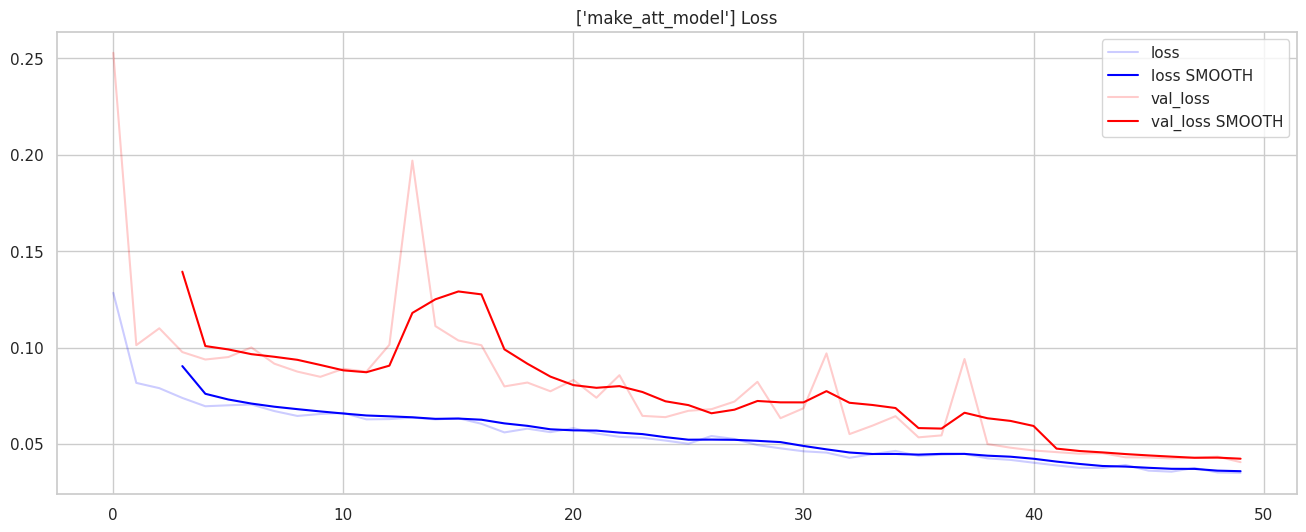

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


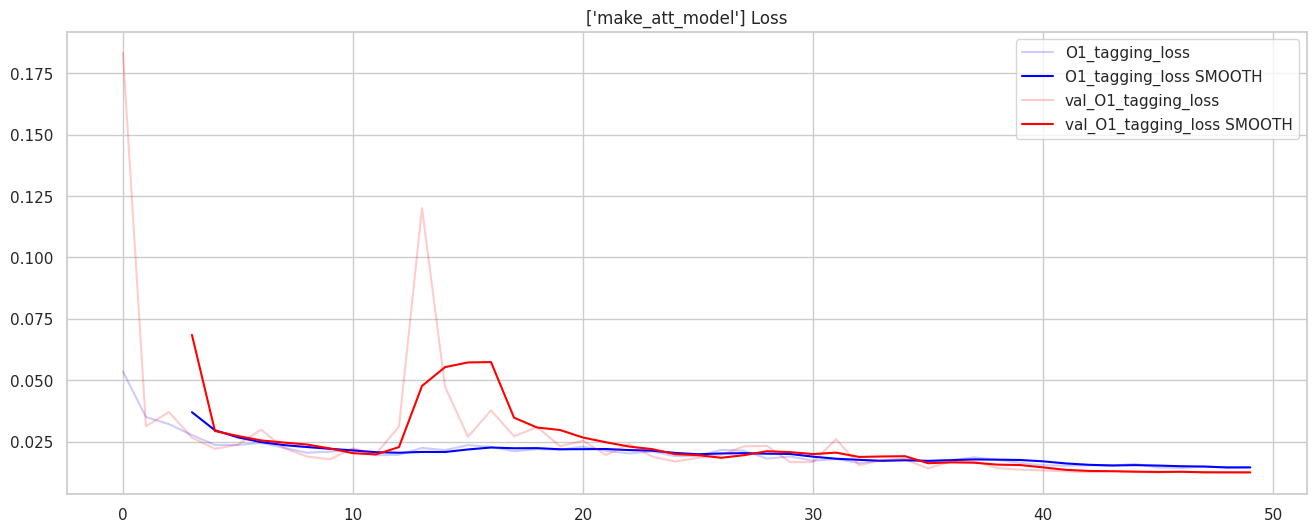

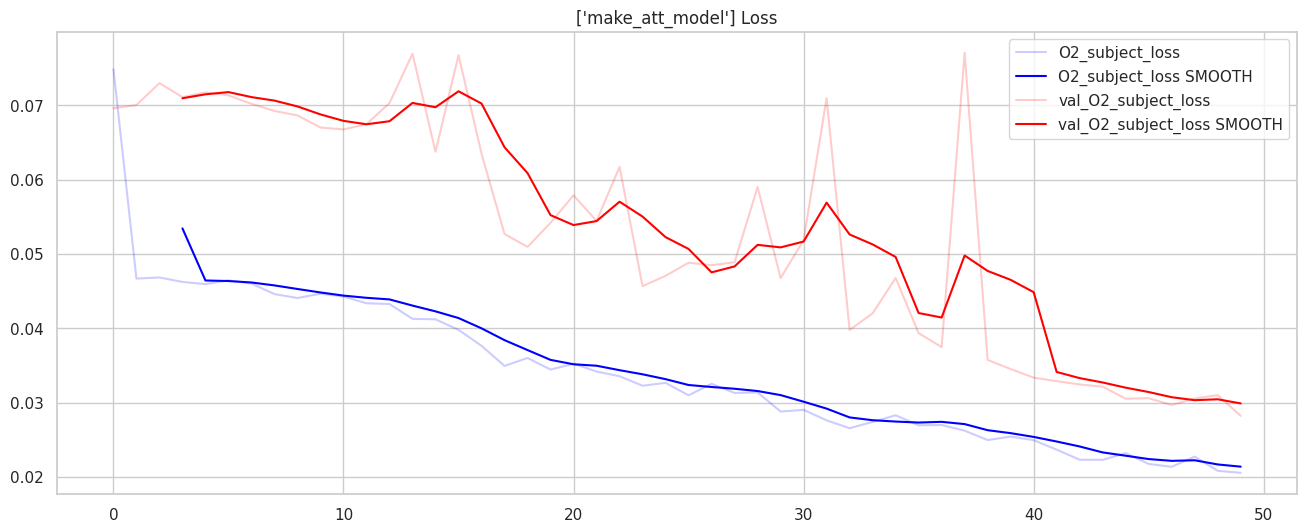

In [51]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [52]:
# umtm.stats
# semantic_map_keys_contract


5ec2b8da665f7603e03b1255


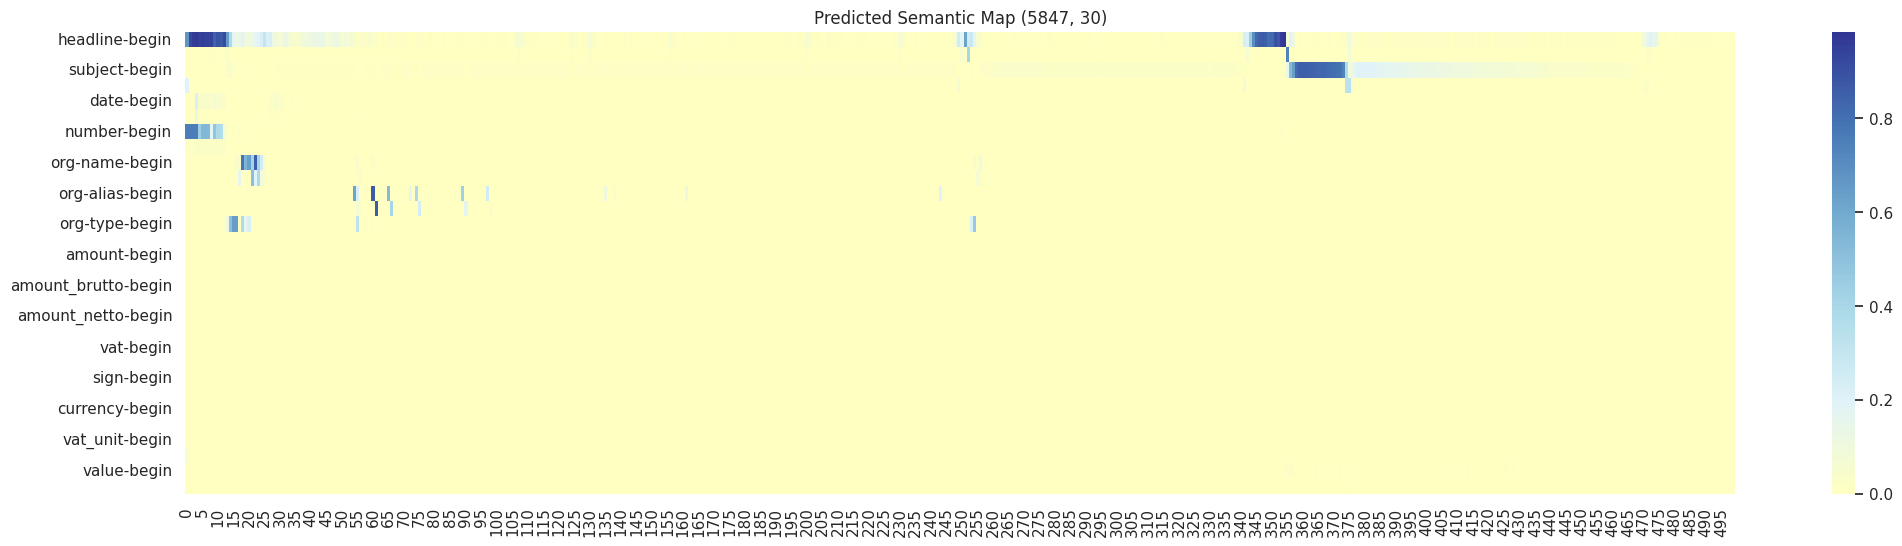

In [53]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [54]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [55]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'